# Transactions - Time Series Modelling

In [1]:
import os

import joblib
import numpy as np
import pandas as pd
import skops.io as sio
from tqdm import tqdm
import warnings

from helpers import (
    REPORTS_DATA_DIR, TRANSFORMED_DATA_DIR
)

## Load integrated data

In [2]:
df_transactions = pd.read_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt7_integrated.parquet')
df_transactions.head()

township                 building_type     tenure  \
34996             SENTOSA COURT                     APARTMENT  LEASEHOLD   
34997             SENTOSA COURT                     APARTMENT  LEASEHOLD   
34998             SENTOSA COURT                     APARTMENT  LEASEHOLD   
34999  BANDAR BARU SRI PETALING  TERRACE HOUSE - INTERMEDIATE  LEASEHOLD   
35000           BUKIT BANDARAYA  TERRACE HOUSE - INTERMEDIATE   FREEHOLD   

       floors     rooms  land_area  built_up  price_psf     price    year  \
34996     1.0  3.000000     1015.0    1015.0      128.0  129888.0  2000.0   
34997     1.0  3.000000     1007.0    1007.0      122.0  122888.0  2000.0   
34998     1.0  3.000000     1015.0    1015.0      122.0  123888.0  2000.0   
34999     2.0  2.000000      753.0     672.0      120.0   90000.0  2000.0   
35000     1.0  3.078282     1875.0    1126.0      180.0  338000.0  2000.0   

       ...  median_income  mean_income   n_households  wellbeing_index  \
34996  ...    3006.666667      4379.74  299566.666667            100.0   
34997  ...    3006.666667      4379.74  299566.666667            100.0   
34998  ...    3006.666667      4379.74  299566.666667            100.0   
34999  ...    3006.666667      4379.74  299566.666667            100.0   
35000  ...    3006.666667      4379.74  299566.666667            100.0   

       money_supply_millions  unemployment_rate  population_thousands  \
34996               458363.1                3.0                1416.0   
34997               458363.1                3.0                1416.0   
34998               458363.1                3.0                1416.0   
34999               458363.1                3.0                1416.0   
35000               458363.1                3.0                1416.0   

       n_crimes       date  interest_rate  
34996    8770.0 2000-01-01            5.5  
34997    8770.0 2000-01-01            5.5  
34998    8770.0 2000-01-02            5.5  
34999    8770.0 2000-01-02            5.5  
35000    8770.0 2000-01-02            5.5  

[5 rows x 23 columns]

In [3]:
df_transactions.columns

Index(['township', 'building_type', 'tenure', 'floors', 'rooms', 'land_area',
       'built_up', 'price_psf', 'price', 'year', 'month', 'day', 'cpi',
       'median_income', 'mean_income', 'n_households', 'wellbeing_index',
       'money_supply_millions', 'unemployment_rate', 'population_thousands',
       'n_crimes', 'date', 'interest_rate'],
      dtype='object')

## Data splitting

In [4]:
df_transactions = df_transactions.sort_values(by=['date'])
df_transactions.head()

township                 building_type     tenure  \
34996             SENTOSA COURT                     APARTMENT  LEASEHOLD   
34997             SENTOSA COURT                     APARTMENT  LEASEHOLD   
34998             SENTOSA COURT                     APARTMENT  LEASEHOLD   
34999  BANDAR BARU SRI PETALING  TERRACE HOUSE - INTERMEDIATE  LEASEHOLD   
35000           BUKIT BANDARAYA  TERRACE HOUSE - INTERMEDIATE   FREEHOLD   

       floors     rooms  land_area  built_up  price_psf     price    year  \
34996     1.0  3.000000     1015.0    1015.0      128.0  129888.0  2000.0   
34997     1.0  3.000000     1007.0    1007.0      122.0  122888.0  2000.0   
34998     1.0  3.000000     1015.0    1015.0      122.0  123888.0  2000.0   
34999     2.0  2.000000      753.0     672.0      120.0   90000.0  2000.0   
35000     1.0  3.078282     1875.0    1126.0      180.0  338000.0  2000.0   

       ...  median_income  mean_income   n_households  wellbeing_index  \
34996  ...    3006.666667      4379.74  299566.666667            100.0   
34997  ...    3006.666667      4379.74  299566.666667            100.0   
34998  ...    3006.666667      4379.74  299566.666667            100.0   
34999  ...    3006.666667      4379.74  299566.666667            100.0   
35000  ...    3006.666667      4379.74  299566.666667            100.0   

       money_supply_millions  unemployment_rate  population_thousands  \
34996               458363.1                3.0                1416.0   
34997               458363.1                3.0                1416.0   
34998               458363.1                3.0                1416.0   
34999               458363.1                3.0                1416.0   
35000               458363.1                3.0                1416.0   

       n_crimes       date  interest_rate  
34996    8770.0 2000-01-01            5.5  
34997    8770.0 2000-01-01            5.5  
34998    8770.0 2000-01-02            5.5  
34999    8770.0 2000-01-02            5.5  
35000    8770.0 2000-01-02            5.5  

[5 rows x 23 columns]

In [5]:
df_train = df_transactions.query('year <= 2020')
df_train['year'].value_counts().sort_index()

year
2000.0     6470
2001.0     6494
2002.0     7547
2003.0     8379
2004.0    10449
2005.0     9382
2006.0     8990
2007.0    11603
2008.0    11943
2009.0    13817
2010.0    13409
2011.0    14156
2012.0    12561
2013.0    14271
2014.0    12335
2015.0     9877
2016.0     8573
2017.0     9371
2018.0     8758
2019.0     7388
2020.0     6775
Name: count, dtype: int64

In [6]:
df_test = df_transactions.query('year >= 2021')
df_test['year'].value_counts().sort_index()

year
2021.0    7492
2022.0    8136
2023.0    2098
Name: count, dtype: int64

## Pre-modelling visualisation

Raw data contains 200k data, across 24 years (2000 - 2023). This means that there will be multiple data points for each date (timestamp). In order for traditional time series modelling to work, we need to aggregate the data. In this case, we try to aggregate the data by year, month and day.

In [7]:
df_yearly_price_psf_train = df_train[['year', 'price_psf']]
df_monthly_price_psf_train = df_train[['year', 'month', 'price_psf']]
df_daily_price_psf_train = df_train[['date', 'price_psf']]

### Aggregating data by year

<Axes: title={'center': 'Mean and Median Price per Square Feet per Year'}, xlabel='year'>

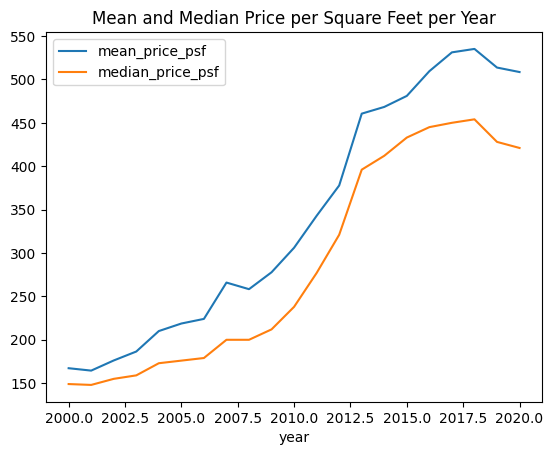

In [8]:
mean_yearly_price_psf_train = df_yearly_price_psf_train.groupby('year').mean()
median_yearly_price_psf_train = df_yearly_price_psf_train.groupby('year').median()

df_price_psf_per_year_train = pd.concat([mean_yearly_price_psf_train, median_yearly_price_psf_train], axis=1)
df_price_psf_per_year_train.columns = ['mean_price_psf', 'median_price_psf']

df_price_psf_per_year_train.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Year',
)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

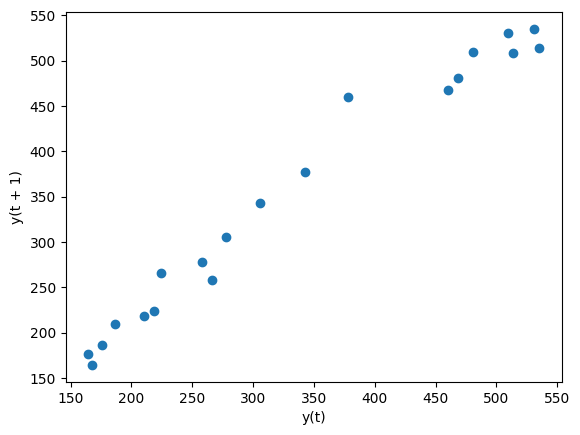

In [9]:
from pandas.plotting import autocorrelation_plot, lag_plot

lag_plot(mean_yearly_price_psf_train['price_psf'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

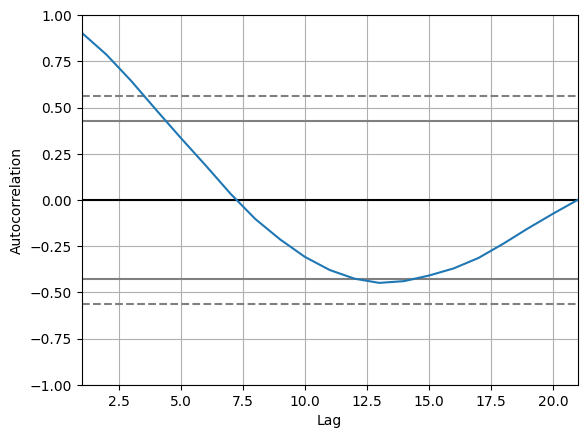

In [10]:
autocorrelation_plot(mean_yearly_price_psf_train['price_psf'])

Although the aggregated data has a reasonable time plot, there were only 21 data points. This is not enough for time series modelling. Further granulatity is required.

### Aggregating data by month

In [11]:
df_monthly_price_psf_train['year_month'] = pd.to_datetime(df_monthly_price_psf_train[['year', 'month']].assign(day=1)) 
df_monthly_price_psf_train.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_25976\447924927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly_price_psf_train['year_month'] = pd.to_datetime(df_monthly_price_psf_train[['year', 'month']].assign(day=1))


year  month  price_psf year_month
34996  2000.0    1.0      128.0 2000-01-01
34997  2000.0    1.0      122.0 2000-01-01
34998  2000.0    1.0      122.0 2000-01-01
34999  2000.0    1.0      120.0 2000-01-01
35000  2000.0    1.0      180.0 2000-01-01

Number of months from 2000 to 2020: 252
Length of grouped dataframe: 252


<Axes: title={'center': 'Mean and Median Price per Square Feet per Month'}, xlabel='year_month'>

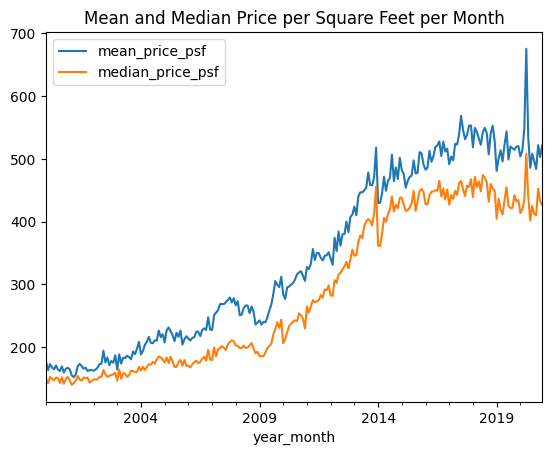

In [12]:
mean_monthly_price_psf_train = df_monthly_price_psf_train[['year_month', 'price_psf']].groupby('year_month').mean()
median_monthly_price_psf_train = df_monthly_price_psf_train[['year_month', 'price_psf']].groupby('year_month').median()

df_price_psf_per_month_train = pd.concat([mean_monthly_price_psf_train, median_monthly_price_psf_train], axis=1)
df_price_psf_per_month_train.columns = ['mean_price_psf', 'median_price_psf']

print(f'Number of months from 2000 to 2020: {12 * 21}')
print(f'Length of grouped dataframe: {len(df_price_psf_per_month_train)}')

df_price_psf_per_month_train.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month',
)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

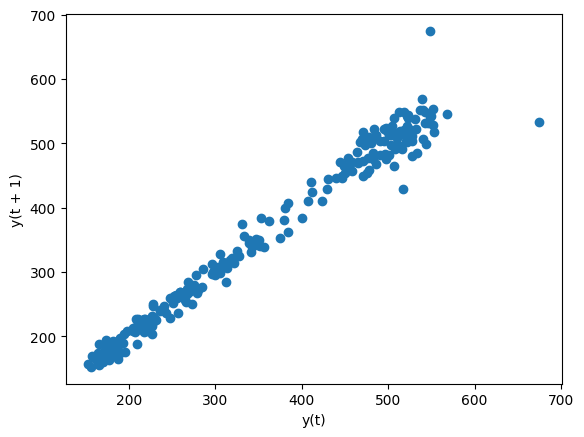

In [13]:
lag_plot(mean_monthly_price_psf_train['price_psf'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

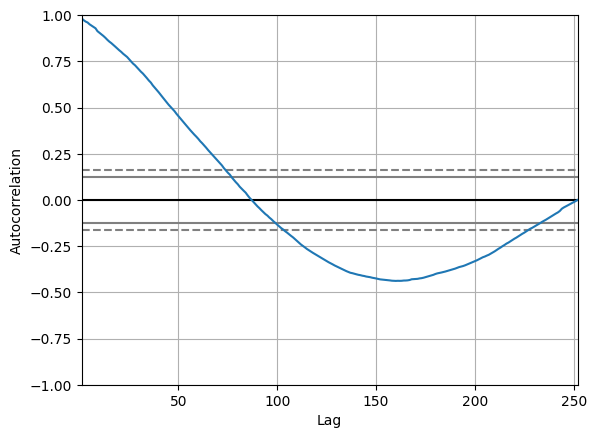

In [14]:
autocorrelation_plot(mean_monthly_price_psf_train['price_psf'])

By aggregating the data by month, we have 252 data points. This is a reasonable amount of data points for time series modelling. However, let's try to aggregate the data by day and see if this is a better option.

Moreover, the lag plot shows that there is a strong correlation between the current month's `price_psf` and the previous month's `price_psf`. This is a good sign for time series modelling.

### Aggregating data by date

Number of days from 2000 to 2020: 7665
Length of grouped dataframe: 7093


<Axes: title={'center': 'Mean and Median Price per Square Feet per Day'}, xlabel='date'>

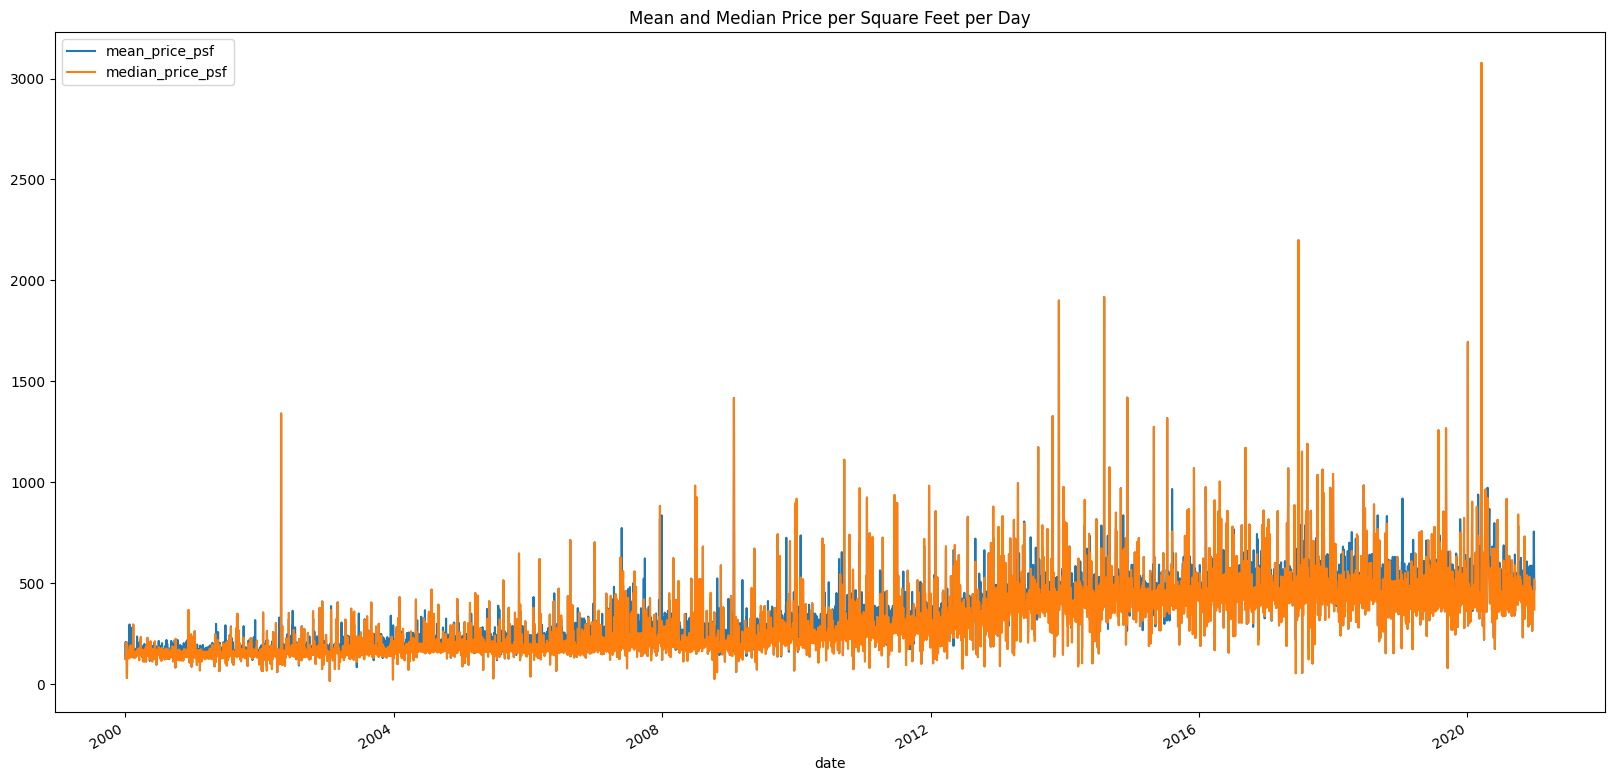

In [15]:
mean_daily_price_psf_train = df_daily_price_psf_train.groupby('date').mean()
median_daily_price_psf_train = df_daily_price_psf_train.groupby('date').median()

df_price_psf_per_day_train = pd.concat([mean_daily_price_psf_train, median_daily_price_psf_train], axis=1)
df_price_psf_per_day_train.columns = ['mean_price_psf', 'median_price_psf']

print(f'Number of days from 2000 to 2020: {365 * 21}')
print(f'Length of grouped dataframe: {len(df_price_psf_per_day_train)}')

df_price_psf_per_day_train.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Day',
    figsize=(20, 10)
)

There should be a minimum of 7665 transactions (one transaction per day) but we only have 7093 transactions. This means that there are days with no transactions.

Additionally, based on the chart above, there are more than one transaction per day.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

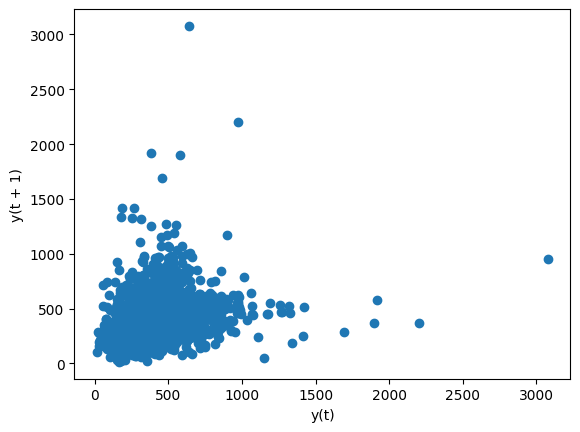

In [16]:
lag_plot(mean_daily_price_psf_train['price_psf'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

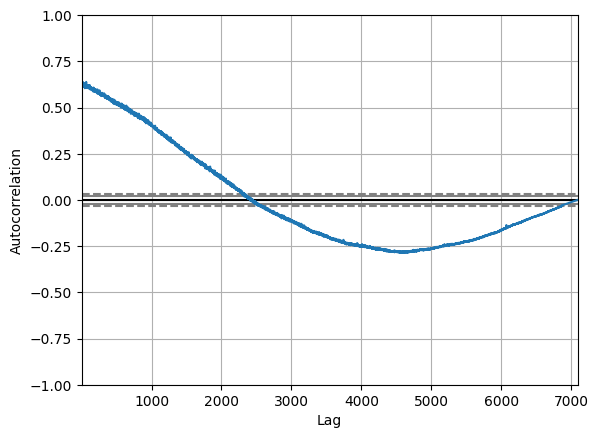

In [17]:
autocorrelation_plot(mean_daily_price_psf_train['price_psf'])

Although aggregating the data by day gives us the most granular data, the lag plot is fairly dispersed and there is no clear correlation between the current day's `price_psf` and the previous day's `price_psf`. This is not a good sign for time series modelling.

Moving forward, we will use monthly data for forecasting.

## Time series modelling

From the literature, the most popular methods are:
- Time series methods:
    1. ARIMA (Abidoye et al., 2019; Dejniak & Dąbrowski, 2017; Iliychovski et al., 2022; Y. Li et al., 2020; Liu & Wu, 2020; Samadani & Costa, 2021)
    2. SARIMA (Samadani & Costa, 2021)
    3. Holt’s exponential smoothing (Liu & Wu, 2020)
- Machine learning approaches :
    1. random forest regression (Ayyasamy et al., 2022)
    2. support vector regression (Ayyasamy et al., 2022; D.-Y. Li et al., 2009; Y. Li et al., 2020; Plakandaras et al., 2015)
    3. neural networks (Abidoye et al., 2019; Kang et al., 2020; Liu & Wu, 2020; Sa’at et al., 2021; Samadani & Costa, 2021; Xu & Zhang, 2021)

These techniques will be implemented in this study as they were not completely compared against each other in the prior studies.

As this is a time series study, traditional cross validation approach is unsuitable due to time dependencies. Bergmeir & Benítez (2012) suggested the use of blocked cross validation, where the time series data is divided into consecutive segments with fixed number of data points. In each segment, the data is divided into training and validation set. In this way, each data point is fully utilised.

There are two time series data in this study: mean price per square feet and median price per square feet. In the following analysis, we will perform time series modelling on mean price per square feet then followed by median price per square feet.

Let's check the normality, autocorrelation and partial autocorrelation of the time series.

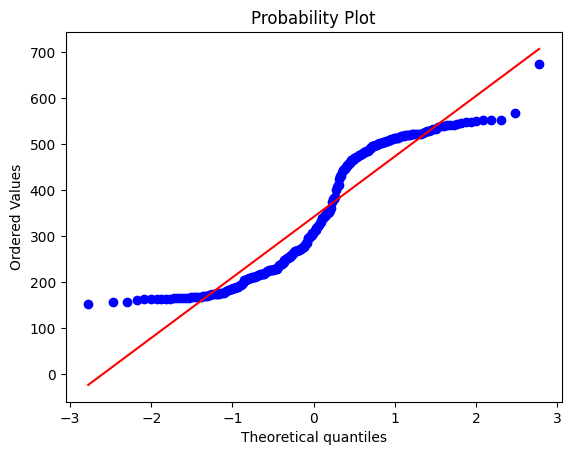

In [18]:
from scipy.stats import probplot
import matplotlib.pyplot as plt

probplot(mean_monthly_price_psf_train['price_psf'], plot=plt)
plt.show()

The time series is not normally distributed. This is expected for time series.

Let's check if the data is stationary.

In [19]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)

In [20]:
from statsmodels.tsa.stattools import adfuller

mean_monthly_price_psf_adf_result = adfuller(mean_monthly_price_psf_train)
print_adf_result(mean_monthly_price_psf_adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -0.717107
P-Value                   0.842268
# Lags Used              15.000000
# Observations Used     236.000000
Critical Value (1%)      -3.458366
Critical Value (5%)      -2.873866
Critical Value (10%)     -2.573339
dtype: float64


In [21]:
median_monthly_price_psf_adf_result = adfuller(median_monthly_price_psf_train)
print_adf_result(median_monthly_price_psf_adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -0.356427
P-Value                   0.917124
# Lags Used               6.000000
# Observations Used     245.000000
Critical Value (1%)      -3.457326
Critical Value (5%)      -2.873410
Critical Value (10%)     -2.573096
dtype: float64


The Augmented Dickey-Fuller (ADF) test is to test for stationarity. The null hypothesis H0 is that the time series is non-stationary, while the alternative hypothesis H1 is that the time series is stationary.

Since the computed p-value is more than 0.05, we fail to reject the null hypothesis H0 and conclude that the time series is non-stationary. We need to perform differencing as time series models like ARIMA expects the data series to be stationary. We can use the STL method to perform differencing or deseasonalising. However, we need to specify the period.

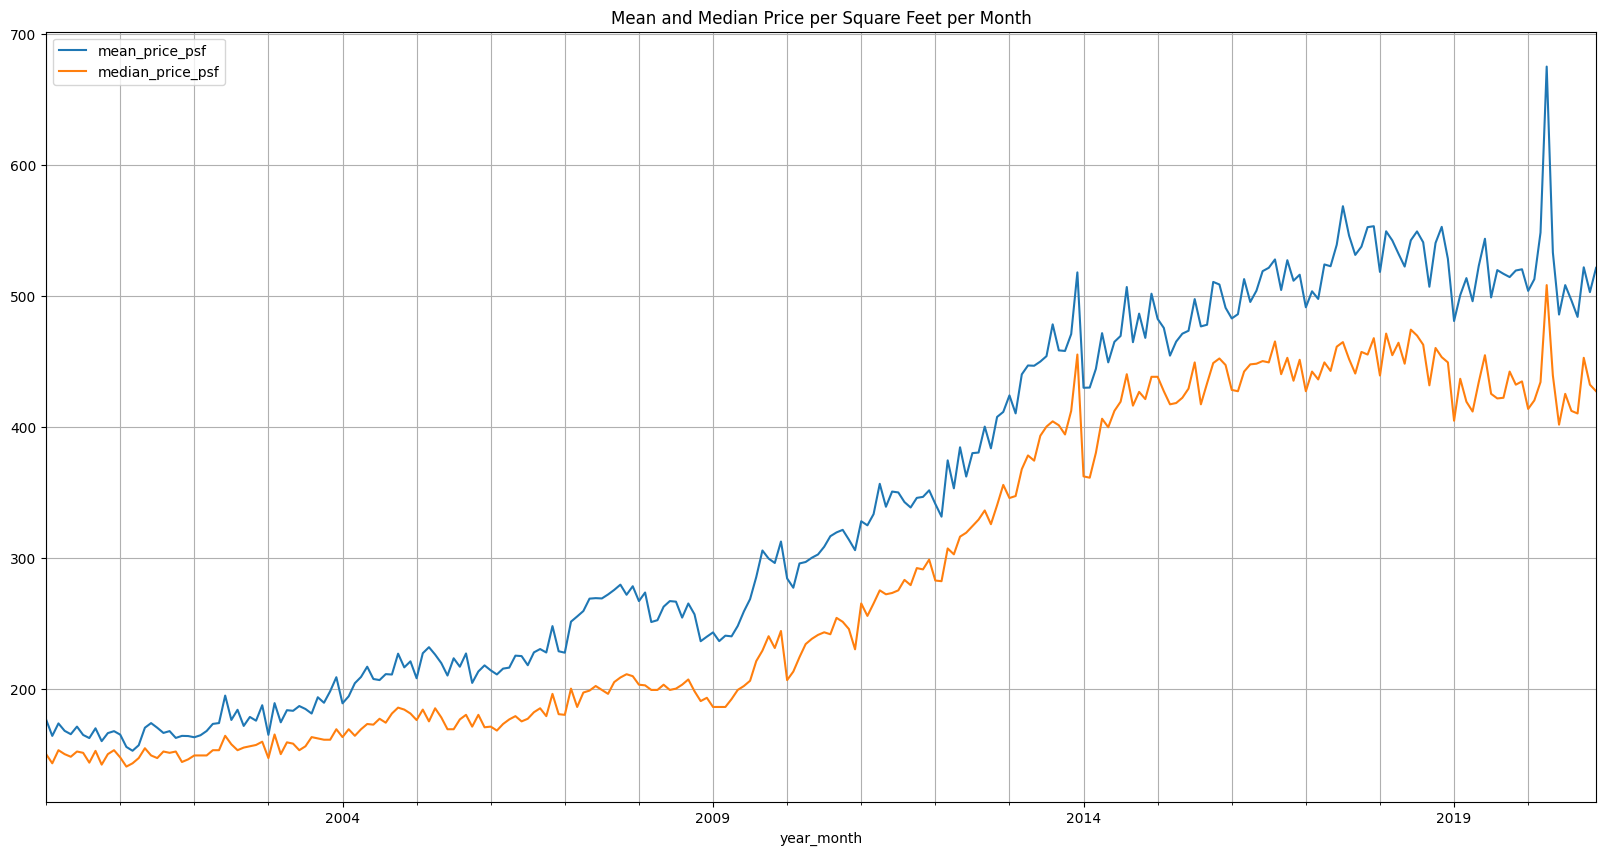

In [22]:
df_price_psf_per_month_train.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month',
    figsize=(20, 10),
    grid=True,
)
plt.grid(which='minor', axis='x')
plt.show()

In [23]:
print(f'The inferred frequency of monthly price psf is: {median_monthly_price_psf_train.index.inferred_freq}')

The inferred frequency of monthly price psf is: MS


Since this is a monthly data, we take the period to be 12 months. Let's perform decomposition and check the trend, seasonality and residuals.

### STL decomposition

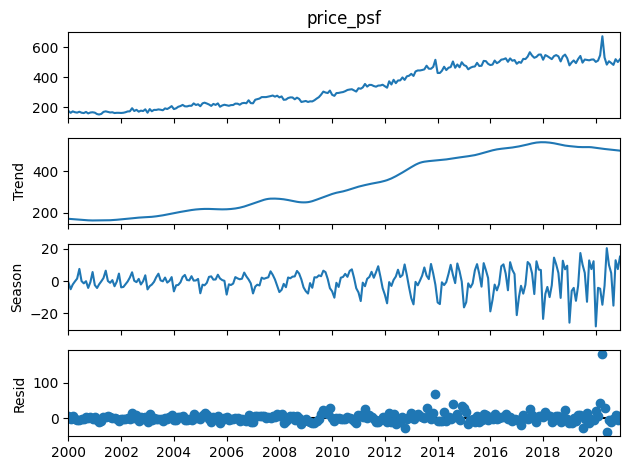

In [24]:
from statsmodels.tsa.seasonal import STL

mean_price_psf_stl = STL(mean_monthly_price_psf_train['price_psf'], period=12, robust=True, seasonal=13).fit()
mean_price_psf_stl.plot()
plt.show()

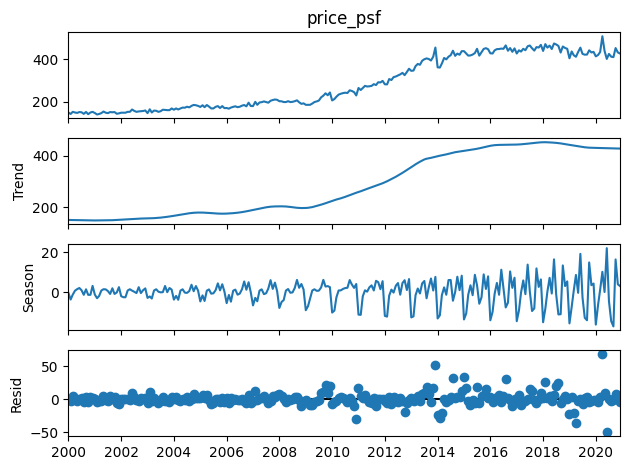

In [25]:
median_price_psf_stl = STL(median_monthly_price_psf_train['price_psf'], period=12, robust=True, seasonal=13).fit()
median_price_psf_stl.plot()
plt.show()

We will model both mean and median price per square feet.

Based on STL decomposition, there are increasing trend and seasonality:
1. The trend is flat until 2004, where it started to increase steadily until 2018. Then it plateaued until 2020.
2. The seasonality is flat until 2008, where it started to increase slightly at 2012. Seasonality spiked at 2019 onwards.
3. No pattern is spotted for residuals. However, there could be some noise at 2014, 2019 and 2020.

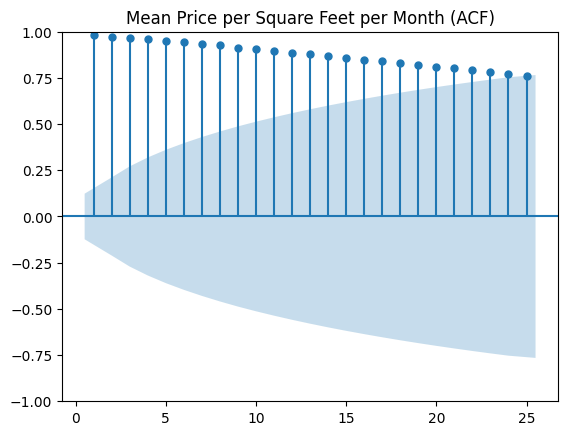

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(mean_monthly_price_psf_train['price_psf'], zero=False)
plt.title('Mean Price per Square Feet per Month (ACF)')
plt.show()

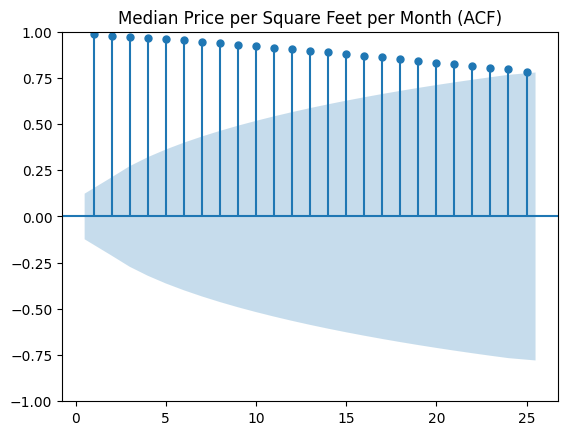

In [27]:
plot_acf(median_monthly_price_psf_train['price_psf'], zero=False)
plt.title('Median Price per Square Feet per Month (ACF)')
plt.show()

Based on the ACF plot, there are statistically significant lag from 1 to 24. This means that the monthly `price_psf` are highly correlated with each other. When the `price_psf` increases, it tends to continue rising; conversely, if it falls, it tends to continue to fall:
1. Might suggest a seasonal pattern with a periodicity of 24 time points (2 years)
2. May indicate that differencing is needed to achieve stationarity
3. Consider decomposing time series into its trend, seasonal, and residual components using methods like seasonal decomposition of time series (STL)
4. Evaluate fitted models using metrics like AIC or BIC

Let's perform differencing using `period=1` and `periods=2` and check if the differenced time series is stationary.

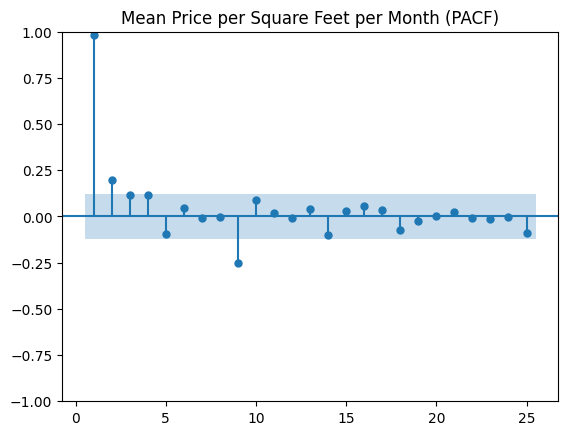

In [28]:
plot_pacf(mean_monthly_price_psf_train['price_psf'], zero=False)
plt.title('Mean Price per Square Feet per Month (PACF)')
plt.show()

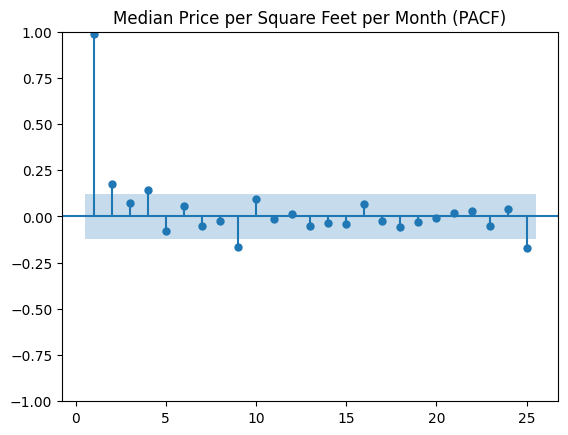

In [29]:
plot_pacf(median_monthly_price_psf_train['price_psf'], zero=False)
plt.title('Median Price per Square Feet per Month (PACF)')
plt.show()

In the original time series, the PACF plot shows statistically significant coefficient up to lag 2 for both mean and median `price_psf`. This means that the monthly `price_psf` are correlated with each other up to 2 months. 

### Differenced with `period=1`

In [30]:
mean_monthly_price_psf_train_diff_1 = mean_monthly_price_psf_train.diff(1).dropna()
mean_monthly_price_psf_train_diff_1_adf_result = adfuller(mean_monthly_price_psf_train_diff_1)
print_adf_result(mean_monthly_price_psf_train_diff_1_adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.227672
P-Value                   0.000591
# Lags Used              14.000000
# Observations Used     236.000000
Critical Value (1%)      -3.458366
Critical Value (5%)      -2.873866
Critical Value (10%)     -2.573339
dtype: float64


In [31]:
median_monthly_price_psf_train_diff_1 = median_monthly_price_psf_train.diff(1).dropna()
median_monthly_price_psf_train_diff_1_adf_result = adfuller(median_monthly_price_psf_train_diff_1)
print_adf_result(median_monthly_price_psf_train_diff_1_adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.495187e+00
P-Value                 4.398666e-11
# Lags Used             5.000000e+00
# Observations Used     2.450000e+02
Critical Value (1%)    -3.457326e+00
Critical Value (5%)    -2.873410e+00
Critical Value (10%)   -2.573096e+00
dtype: float64


For differenced mean monthly price psf, the p-value of ADF test is less than 0.05, therefore we reject the null hypothesis H0 and conclude that the differenced time series is stationary.

Let's check the autocorrelation and partial autocorrelation of the original and differenced time series.

[]

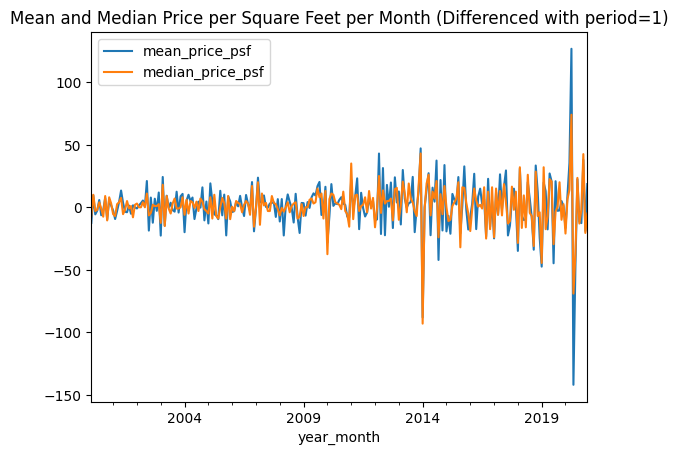

In [32]:
df_monthly_price_psf_train_diff_1 = pd.concat([mean_monthly_price_psf_train_diff_1, median_monthly_price_psf_train_diff_1], axis=1)
df_monthly_price_psf_train_diff_1.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month (Differenced with period=1)',
)
plt.legend(['mean_price_psf', 'median_price_psf'])
plt.plot()

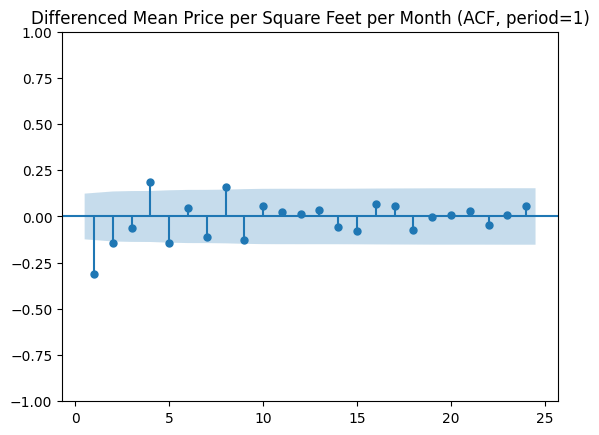

In [33]:
plot_acf(mean_monthly_price_psf_train_diff_1, zero=False)
plt.title('Differenced Mean Price per Square Feet per Month (ACF, period=1)')
plt.show()

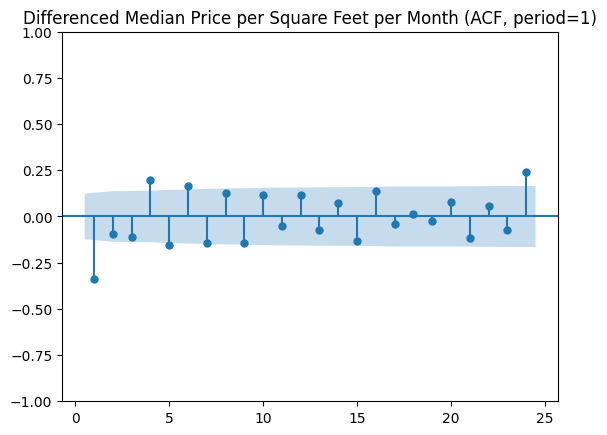

In [34]:
plot_acf(median_monthly_price_psf_train_diff_1, zero=False)
plt.title('Differenced Median Price per Square Feet per Month (ACF, period=1)')
plt.show()

After differencing with period of 1, the ACF plot shows statistically significant coefficient up to lag 2 for mean `price_psf` and lag 1 for median `price_psf`. This means that we can use `q=2` for ARIMA model on mean `price_psf` and `q=1` for median `price_psf`.

Let's do the same for PACF.

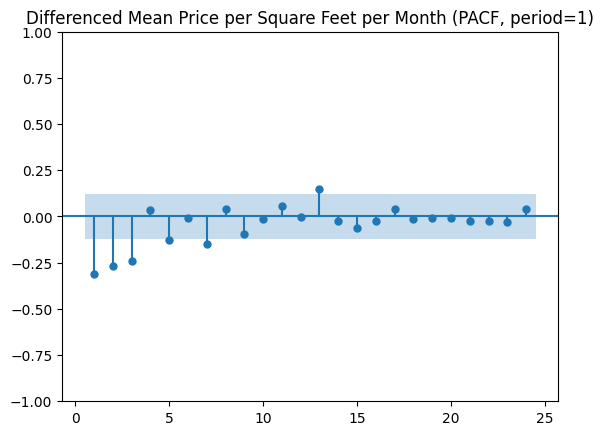

In [35]:
plot_pacf(mean_monthly_price_psf_train_diff_1, zero=False)
plt.title('Differenced Mean Price per Square Feet per Month (PACF, period=1)')
plt.show()

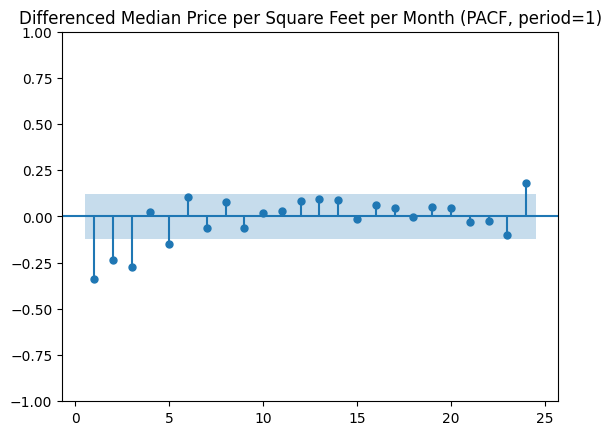

In [36]:
plot_pacf(median_monthly_price_psf_train_diff_1, zero=False)
plt.title('Differenced Median Price per Square Feet per Month (PACF, period=1)')
plt.show()

However, differenced time series shows statistically significant coefficient up to lag 3 for both mean and median `price_psf`. This means that we can use `p=3` for ARIMA model on both time series data.

For ARIMA model, we can use the following configurations:
- Mean `price_psf`: (p, d, q) = (3, 1, 2)
- Median `price_psf`: (p, d, q) = (3, 1, 1)

Let's try with `period=2` and check if the differenced time series is stationary.

### Differenced with `period=2`

In [37]:
mean_monthly_price_psf_train_diff_2 = mean_monthly_price_psf_train.diff(2).dropna()
mean_monthly_price_psf_train_diff_2_adf_result = adfuller(mean_monthly_price_psf_train_diff_2)
print_adf_result(mean_monthly_price_psf_train_diff_2_adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.313496
P-Value                   0.000421
# Lags Used              13.000000
# Observations Used     236.000000
Critical Value (1%)      -3.458366
Critical Value (5%)      -2.873866
Critical Value (10%)     -2.573339
dtype: float64


In [38]:
median_monthly_price_psf_train_diff_2 = median_monthly_price_psf_train.diff(2).dropna()
median_monthly_price_psf_train_diff_2_adf_result = adfuller(median_monthly_price_psf_train_diff_2)
print_adf_result(median_monthly_price_psf_train_diff_2_adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.137288
P-Value                   0.023914
# Lags Used              12.000000
# Observations Used     237.000000
Critical Value (1%)      -3.458247
Critical Value (5%)      -2.873814
Critical Value (10%)     -2.573311
dtype: float64


For differenced mean monthly price psf, the p-value of ADF test is less than 0.05, therefore we reject the null hypothesis H0 and conclude that the differenced time series is stationary. Although the differenced median monthly price psf is much higher than the mean monthly price psf, the p-value of ADF test is less than 0.05, therefore we reject the null hypothesis H0 and conclude that the differenced time series is stationary.

Let's check the autocorrelation and partial autocorrelation of the differenced time series.

[]

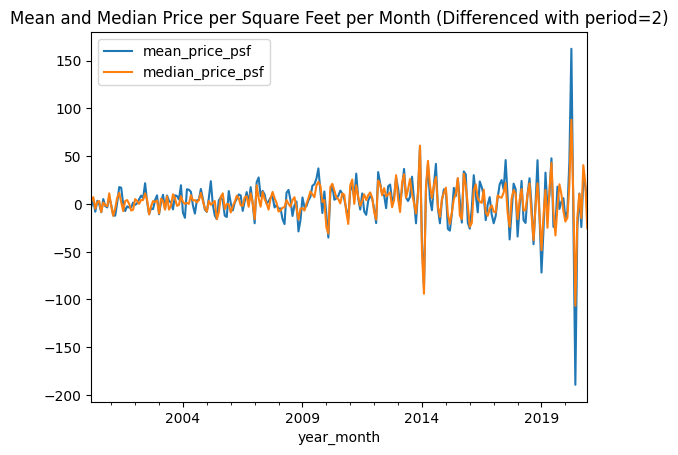

In [39]:
df_monthly_price_psf_train_diff_2 = pd.concat([mean_monthly_price_psf_train_diff_2, median_monthly_price_psf_train_diff_2], axis=1)
df_monthly_price_psf_train_diff_2.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month (Differenced with period=2)',
)
plt.legend(['mean_price_psf', 'median_price_psf'])
plt.plot()

Let's plot the ACF and PACF of the differenced time series.

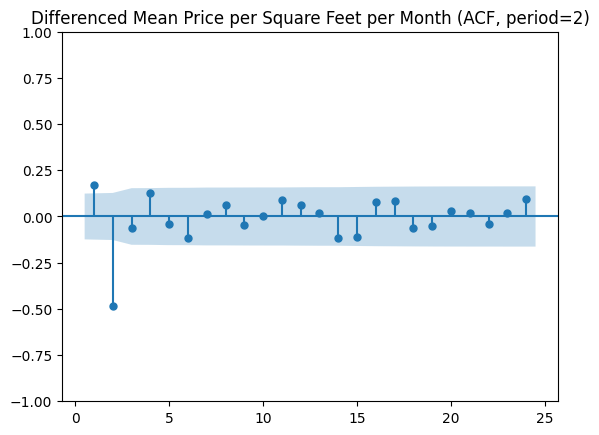

In [40]:
plot_acf(mean_monthly_price_psf_train_diff_2, zero=False)
plt.title('Differenced Mean Price per Square Feet per Month (ACF, period=2)')
plt.show()

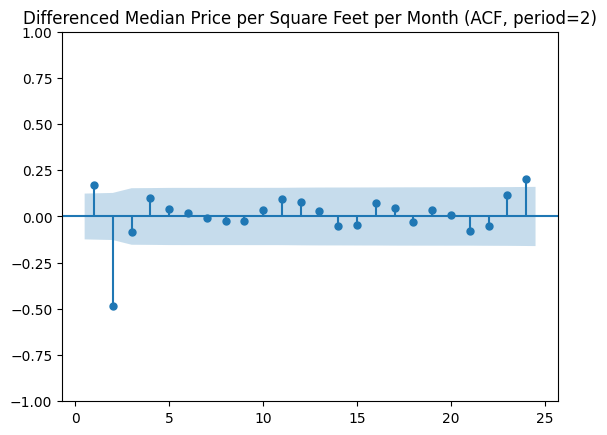

In [41]:
plot_acf(median_monthly_price_psf_train_diff_2, zero=False)
plt.title('Differenced Median Price per Square Feet per Month (ACF, period=2)')
plt.show()

After differencing with period of 2, the ACF plot shows statistically significant coefficient up to lag 2 for mean `price_psf` and lmedian `price_psf`. This means that we can use `q=2` for ARIMA model on mean `price_psf` and median `price_psf`.

Let's do the same for PACF.

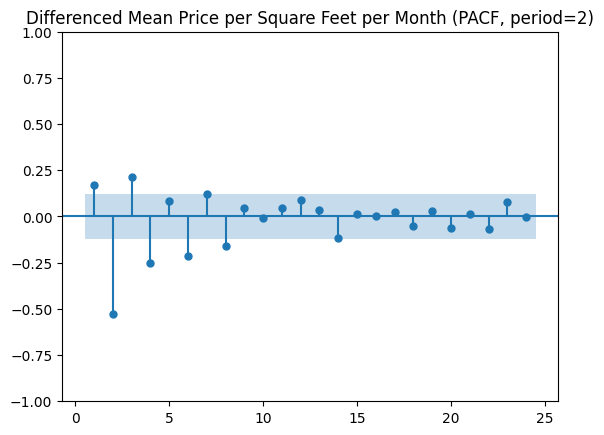

In [42]:
plot_pacf(mean_monthly_price_psf_train_diff_2, zero=False)
plt.title('Differenced Mean Price per Square Feet per Month (PACF, period=2)')
plt.show()

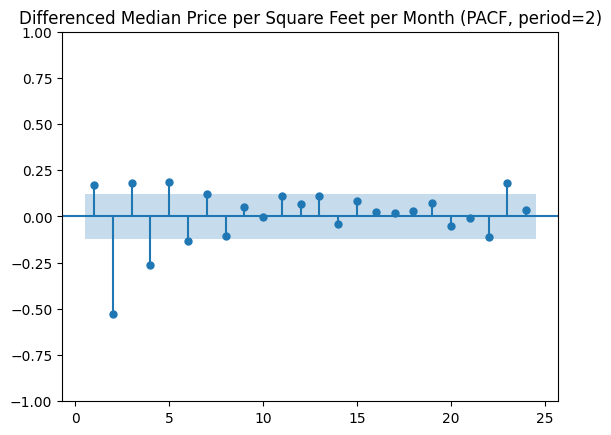

In [43]:
plot_pacf(median_monthly_price_psf_train_diff_2, zero=False)
plt.title('Differenced Median Price per Square Feet per Month (PACF, period=2)')
plt.show()

However, differenced time series shows statistically significant coefficient up to lag 4 for mean `price_psf` and lag 7 for median `price_psf`. This means that we can use `p=4` and `p=7` for ARIMA model on mean `price_psf` and median `price_psf` respectively.

For ARIMA model, we can use the following configurations:
- Mean `price_psf`: (p, d, q) = (4, 2, 2)
- Median `price_psf`: (p, d, q) = (7, 2, 2)

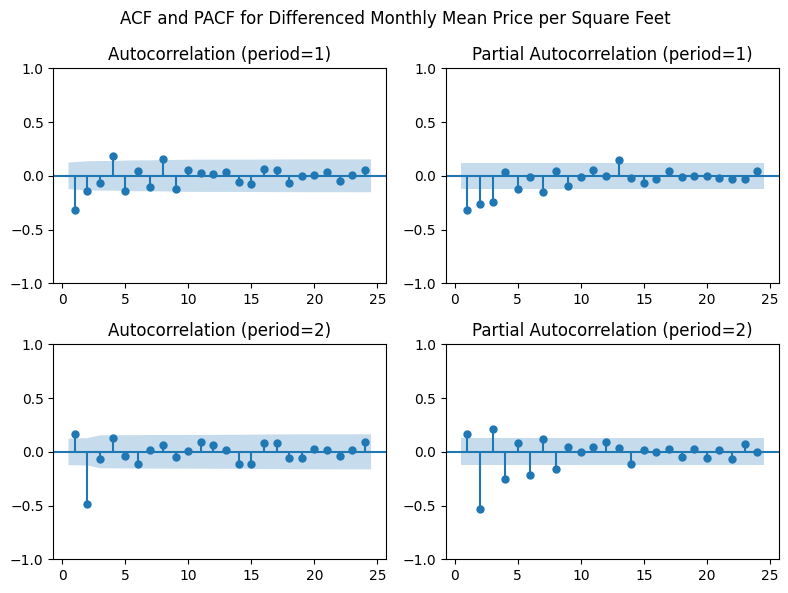

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
fig.suptitle('ACF and PACF for Differenced Monthly Mean Price per Square Feet')

plot_acf(
    mean_monthly_price_psf_train_diff_1,
    zero=False,
    title='Autocorrelation (period=1)',
    ax=axes[0, 0]
)

plot_pacf(
    mean_monthly_price_psf_train_diff_1, 
    zero=False,
    title='Partial Autocorrelation (period=1)',
    ax=axes[0, 1]
)

plot_acf(
    mean_monthly_price_psf_train_diff_2,
    zero=False,
    title='Autocorrelation (period=2)',
    ax=axes[1, 0]
)

plot_pacf(
    mean_monthly_price_psf_train_diff_2, 
    zero=False,
    title='Partial Autocorrelation (period=2)',
    ax=axes[1, 1]
)

plt.tight_layout()
plt.show()

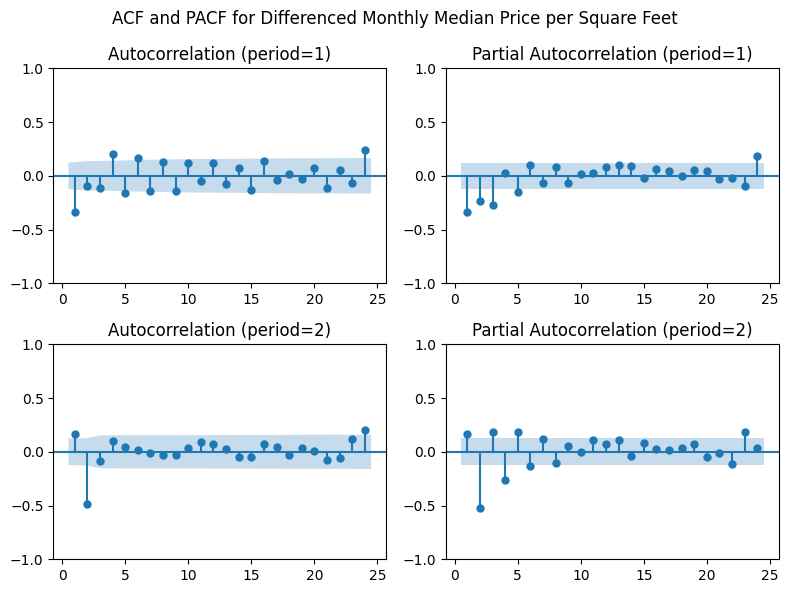

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
fig.suptitle('ACF and PACF for Differenced Monthly Median Price per Square Feet')

plot_acf(
    median_monthly_price_psf_train_diff_1, 
    zero=False,
    title='Autocorrelation (period=1)',
    ax=axes[0, 0]
)

plot_pacf(
    median_monthly_price_psf_train_diff_1, 
    zero=False,
    title='Partial Autocorrelation (period=1)',
    ax=axes[0, 1]
)

plot_acf(
    median_monthly_price_psf_train_diff_2, 
    zero=False,
    title='Autocorrelation (period=2)',
    ax=axes[1, 0]
)

plot_pacf(
    median_monthly_price_psf_train_diff_2, 
    zero=False,
    title='Partial Autocorrelation (period=2)',
    ax=axes[1, 1]
)

plt.tight_layout()
plt.show()

## Block cross validation

In [46]:
def block_cv(series: pd.Series, n_splits=5, test_sample_size=6, return_list=False):
    n = len(series)
    fold_size = int(n / n_splits)

    start = 0
    end = fold_size
    train_size = 1 - (test_sample_size / fold_size)

    for i in range(n_splits):
        split = series.iloc[start:start + fold_size]

        train = split[:int(fold_size * train_size)]
        test = split[int(fold_size * train_size):]

        if return_list:
            yield train.index.to_list(), test.index.to_list()
        else:
            yield train, test

        start += fold_size
        end += fold_size

In [47]:
def plot_cv_indices(X: pd.DataFrame, n_splits=5, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    _, ax = plt.subplots()

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(block_cv(X, n_splits=n_splits, return_list=True)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        print(f'Split {ii}: {tr}, {tt}')

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits, -0.2],
        title="Block cross validation of monthly price per square feet",
    )

    return ax

Split 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], [44, 45, 46, 47, 48, 49]
Split 1: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93], [94, 95, 96, 97, 98, 99]
Split 2: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143], [144, 145, 146, 147, 148, 149]
Split 3: [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193], [194, 195, 196, 197, 198, 199]
Split 4: [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21

<Axes: title={'center': 'Block cross validation of monthly price per square feet'}, xlabel='Sample index', ylabel='CV iteration'>

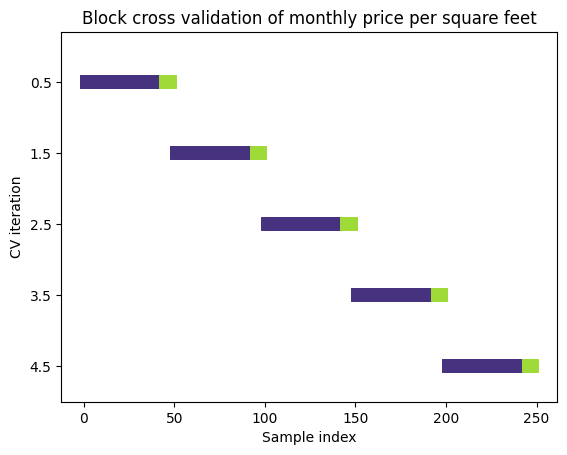

In [48]:
plot_cv_indices(mean_monthly_price_psf_train_diff_1.reset_index())

## Grid search with cross validation on mean `price_psf`
Based on the analysis with ACF and PACF plots above, we will use the following configurations for ARIMA model:
- Mean `price_psf`: (p, d, q) = (3, 1, 2), (4, 2, 2)
- Median `price_psf`: (p, d, q) = (3, 1, 1), (7, 2, 2)

We then compare the models using RMSE, AIM and BIC. The reason is due to:
- RMSE is the most popular metric for regression problems and it penalises large errors.
- AIC is a measure of the relative quality of a statistical model for a given set of data. AIC balances the goodness of fit of the model with the complexity or number of parameters in the model. A lower AIC value indicates a better balance between model fit and simplicity.
- BIC is similar to AIC but it penalises models with more parameters more severely.

In [49]:
from itertools import product

p = range(1,5)
i = range(1,3)
q = range(1,3)
orders = list(product(p, i, q))
print(f'Number of orders: {len(orders)}')

Number of orders: 16


In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_gamma_deviance, mean_poisson_deviance, max_error

def evaluate_model(y_true, y_pred, verbose=False):

    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    me = max_error(y_true, y_pred)
    rmsle = np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))
    mpd = mean_poisson_deviance(y_true, y_pred)
    mgd = mean_gamma_deviance(y_true, y_pred)
    
    if verbose:
        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"MAPE: {mape}")
        print(f"R2: {r2}")
        print(f"ME: {me}")
        print(f"RMSLE: {rmsle}")
        print(f"MPD: {mpd}")
        print(f"MGD: {mgd}")

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'me': me,
        'rmsle': rmsle,
        'mpd': mpd,
        'mgd': mgd,
    }

### ARIMA on mean `price_psf`

In [51]:
from statsmodels.tsa.arima.model import ARIMA
from statistics import mean

models, mse, rmse, mae, mape, r2, me, rmsle, mpd, mgd, aic, bic = [], [], [], [], [], [], [], [], [], [], [], []

for order in tqdm(orders, total=len(orders)):
    for fold, (train, val) in enumerate(block_cv(mean_monthly_price_psf_train['price_psf'], n_splits=2)):
        fold_mse, fold_rmse, fold_mae, fold_mape, fold_r2, fold_me, fold_rmsle, fold_mpd, fold_mgd, fold_aic, fold_bic = [], [], [], [], [], [], [], [], [], [], []
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                arima = ARIMA(train, order=order, freq=train.index.inferred_freq).fit()
                arima_forecast = arima.forecast(len(val))
                results = evaluate_model(val, arima_forecast)
                fold_mse.append(results['mse'])
                fold_rmse.append(results['rmse'])
                fold_mae.append(results['mae'])
                fold_mape.append(results['mape'])
                fold_r2.append(results['r2'])
                fold_me.append(results['me'])
                fold_rmsle.append(results['rmsle'])
                fold_mpd.append(results['mpd'])
                fold_mgd.append(results['mgd'])
                fold_aic.append(arima.aic)
                fold_bic.append(arima.bic)
            except:
                fold_mse.append(np.nan)
                fold_rmse.append(np.nan)
                fold_mae.append(np.nan)
                fold_mape.append(np.nan)
                fold_r2.append(np.nan)
                fold_me.append(np.nan)
                fold_rmsle.append(np.nan)
                fold_mpd.append(np.nan)
                fold_mgd.append(np.nan)
                fold_aic.append(np.nan)
                fold_bic.append(np.nan)

    models.append(f'ARIMA {order}')
    mse.append(mean(fold_mse))
    rmse.append(mean(fold_rmse))
    mae.append(mean(fold_mae))
    mape.append(mean(fold_mape))
    r2.append(mean(fold_r2))
    me.append(mean(fold_me))
    rmsle.append(mean(fold_rmsle))
    mpd.append(mean(fold_mpd))
    mgd.append(mean(fold_mgd))
    aic.append(mean(fold_aic))
    bic.append(mean(fold_bic))

df_arima_eval = pd.DataFrame({'model': models, 'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2, 'me': me, 'rmsle': rmsle, 'mpd': mpd, 'mgd': mgd, 'aic': aic, 'bic': bic})
df_arima_eval.sort_values(by=['rmse'], ascending=True).head(10)

 12%|█▎        | 2/16 [00:00<00:02,  6.51it/s]

100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


model          mse       rmse        mae      mape         r2  \
7   ARIMA (2, 2, 2)   154.787904  12.441379  10.933053  0.021463   0.137015   
2   ARIMA (1, 2, 1)   159.875610  12.644193  10.453818  0.020606   0.108649   
3   ARIMA (1, 2, 2)   677.732268  26.033292  23.513177  0.046033  -2.778544   
0   ARIMA (1, 1, 1)   784.248623  28.004439  24.413935  0.049032  -3.372402   
1   ARIMA (1, 1, 2)   933.909013  30.559925  27.247881  0.054652  -4.206800   
4   ARIMA (2, 1, 1)  1951.665784  44.177662  40.898657  0.081758  -9.881074   
6   ARIMA (2, 2, 1)  2289.483186  47.848544  45.944733  0.091365 -11.764499   
12  ARIMA (4, 1, 1)  3131.243311  55.957513  46.389841  0.092792 -16.457543   
9   ARIMA (3, 1, 2)  3135.306275  55.993806  46.283082  0.092565 -16.480195   
8   ARIMA (3, 1, 1)  3301.746006  57.460821  47.448609  0.094882 -17.408143   

            me     rmsle       mpd       mgd          aic          bic  
7    18.988822  0.024511  0.306651  0.000608  1120.627258  1134.480681  
2    18.899635  0.024974  0.316825  0.000628  1117.511619  1125.823673  
3    36.528500  0.052243  1.376984  0.002799  1123.078337  1134.161076  
0    47.624275  0.054632  1.513975  0.002924  1104.255703  1112.593074  
1    49.849709  0.059410  1.795569  0.003454  1105.029145  1116.145639  
4    63.880374  0.084346  3.670309  0.006908  1101.362530  1112.479024  
6    61.342093  0.090561  4.268326  0.007965  1105.045690  1116.128429  
12  104.348950  0.104031  5.684752  0.010346  1095.346203  1112.020944  
9   105.209556  0.104022  5.687492  0.010343  1095.565959  1112.240700  
8   107.610087  0.106540  5.974454  0.010839  1093.625560  1107.521177

In [52]:
def rank_models(df_rank: pd.DataFrame, metrics: list):

    for metric in metrics:
        if metric == 'r2':
            df_rank['rank_' + metric] = df_rank[metric].rank(ascending=False)
        else:
            df_rank['rank_' + metric] = df_rank[metric].rank(ascending=True)
    return df_rank

In [53]:
metrics = ['mse', 'rmse', 'mae', 'mape', 'r2', 'me', 'rmsle', 'mpd', 'mgd']

df_arima_eval = rank_models(df_arima_eval, metrics)

df_arima_eval['rank_mean'] = df_arima_eval[[col for col in df_arima_eval.columns if col.startswith('rank_')]].mean(axis=1)
df_top_10_arima_eval = df_arima_eval.sort_values(by=['rank_mean']).head(10)
df_top_10_arima_eval

model          mse       rmse        mae      mape         r2  \
7   ARIMA (2, 2, 2)   154.787904  12.441379  10.933053  0.021463   0.137015   
2   ARIMA (1, 2, 1)   159.875610  12.644193  10.453818  0.020606   0.108649   
3   ARIMA (1, 2, 2)   677.732268  26.033292  23.513177  0.046033  -2.778544   
0   ARIMA (1, 1, 1)   784.248623  28.004439  24.413935  0.049032  -3.372402   
1   ARIMA (1, 1, 2)   933.909013  30.559925  27.247881  0.054652  -4.206800   
4   ARIMA (2, 1, 1)  1951.665784  44.177662  40.898657  0.081758  -9.881074   
6   ARIMA (2, 2, 1)  2289.483186  47.848544  45.944733  0.091365 -11.764499   
12  ARIMA (4, 1, 1)  3131.243311  55.957513  46.389841  0.092792 -16.457543   
9   ARIMA (3, 1, 2)  3135.306275  55.993806  46.283082  0.092565 -16.480195   
8   ARIMA (3, 1, 1)  3301.746006  57.460821  47.448609  0.094882 -17.408143   

            me     rmsle       mpd       mgd  ...  rank_mse  rank_rmse  \
7    18.988822  0.024511  0.306651  0.000608  ...       1.0        1.0   
2    18.899635  0.024974  0.316825  0.000628  ...       2.0        2.0   
3    36.528500  0.052243  1.376984  0.002799  ...       3.0        3.0   
0    47.624275  0.054632  1.513975  0.002924  ...       4.0        4.0   
1    49.849709  0.059410  1.795569  0.003454  ...       5.0        5.0   
4    63.880374  0.084346  3.670309  0.006908  ...       6.0        6.0   
6    61.342093  0.090561  4.268326  0.007965  ...       7.0        7.0   
12  104.348950  0.104031  5.684752  0.010346  ...       8.0        8.0   
9   105.209556  0.104022  5.687492  0.010343  ...       9.0        9.0   
8   107.610087  0.106540  5.974454  0.010839  ...      10.0       10.0   

    rank_mae  rank_mape  rank_r2  rank_me  rank_rmsle  rank_mpd  rank_mgd  \
7        2.0        2.0      1.0      2.0         1.0       1.0       1.0   
2        1.0        1.0      2.0      1.0         2.0       2.0       2.0   
3        3.0        3.0      3.0      3.0         3.0       3.0       3.0   
0        4.0        4.0      4.0      4.0         4.0       4.0       4.0   
1        5.0        5.0      5.0      5.0         5.0       5.0       5.0   
4        6.0        6.0      6.0      7.0         6.0       6.0       6.0   
6        7.0        7.0      7.0      6.0         7.0       7.0       7.0   
12       9.0        9.0      8.0      9.0         9.0       8.0       9.0   
9        8.0        8.0      9.0     10.0         8.0       9.0       8.0   
8       10.0       10.0     10.0     11.0        10.0      10.0      10.0   

    rank_mean  
7    1.333333  
2    1.666667  
3    3.000000  
0    4.000000  
1    5.000000  
4    6.111111  
6    6.888889  
12   8.555556  
9    8.666667  
8   10.111111  

[10 rows x 22 columns]

The best order inferred from the grid search is (2, 2, 2), which is different from the order suggested by ACF and PACF plots. However if we consider AIC and BIC as well, the best model is (1, 1, 1), as it has competitive RMSE, as well as lowest AIC and BIC.

Despite the RMSE suggesting that ARIMA(2, 2, 2) is the best model, we should visualise it to see if it really is the best model. The model will be tasked to forecast 36 months ahead, aligns with the objective of forecasting 2021-2023 with 2000-2020 data.

In [54]:
def plot_train_set_mean_forecast(model, train_data, order, forecast_length=12, verbose=False):
    train = train_data.iloc[:-forecast_length]
    val = train_data.iloc[-forecast_length:]

    model = model(train, order=order, freq=train.index.inferred_freq)
    model_name = model.__class__.__name__

    model = model.fit()
    model_forecast = model.get_forecast(forecast_length).summary_frame()
    forecast = model_forecast['mean']
    if verbose:
        print(model.summary())
    print(f'RMSE with {model_name}{order}: {mean_squared_error(val, forecast, squared=False)}')

    train_data.plot(
        kind='line',
        title=f'Mean Price per Square Feet per Month - Forecasted with {model_name}{order}',
    )
    forecast.plot(
        kind='line',
    )
    plt.fill_between(model_forecast.index, model_forecast['mean_ci_lower'], model_forecast['mean_ci_upper'], color='k', alpha=0.1)
    plt.legend(['Actual', 'Forecast'])
    plt.show()

RMSE with ARIMA(2, 2, 2): 74.48348926444744


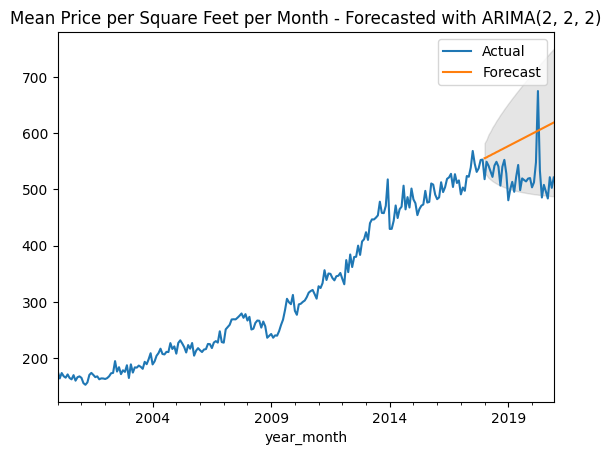

RMSE with ARIMA(1, 2, 1): 75.64405187880544


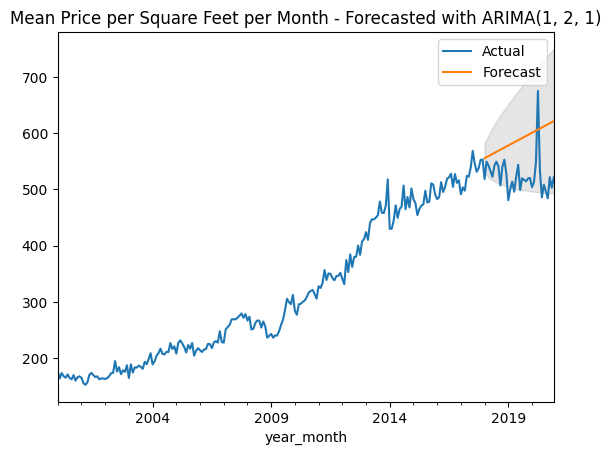

RMSE with ARIMA(1, 2, 2): 81.48754760807371


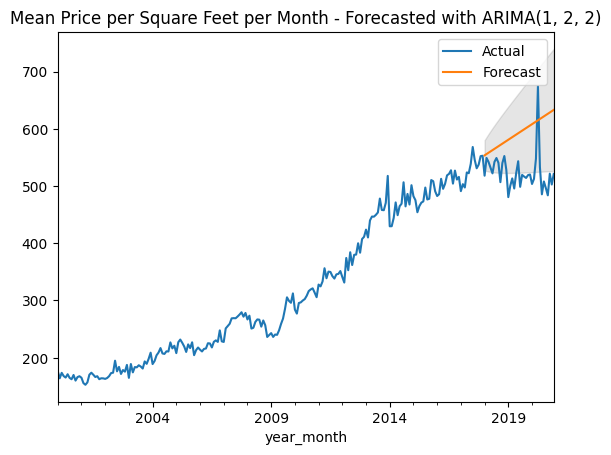

RMSE with ARIMA(1, 1, 1): 41.763953799773226


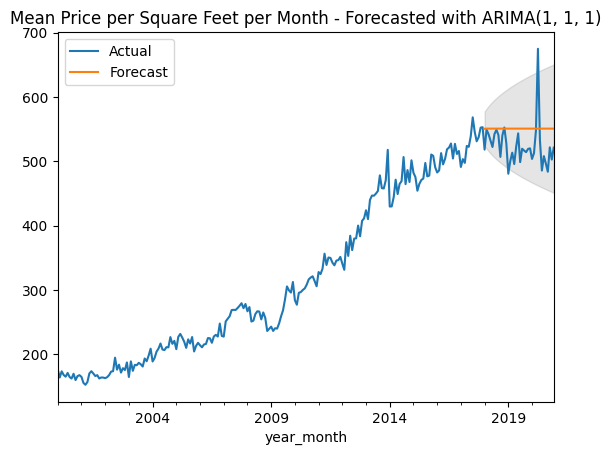

RMSE with ARIMA(1, 1, 2): 41.92501903260061


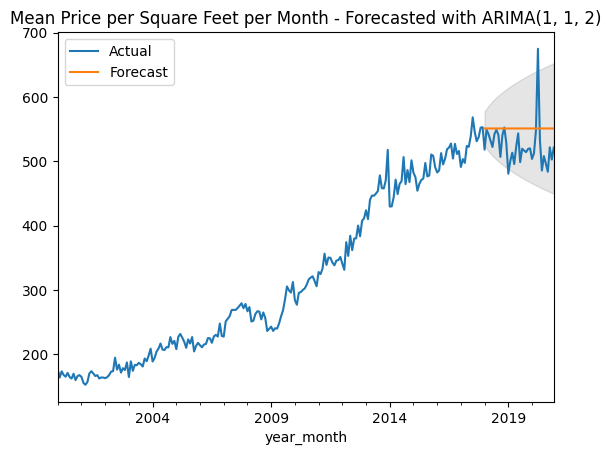

In [55]:
from ast import literal_eval

best_orders = [f'({order})' for order in df_top_10_arima_eval['model'].str.extract(r'\((\d+, \d+, \d+)\)', expand=False)][:5]
forecast_length = 12 * 3

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plot_train_set_mean_forecast(ARIMA, mean_monthly_price_psf_train['price_psf'], literal_eval(best_order), forecast_length)

- ARIMA(2, 2, 2) forecasted somewhat upward trend. However, the actual values are somewhat flat.
- ARIMA(3, 1, 2) forecasted a slightly flat trend, aligns with the actual values.
- Like ARIMA(2, 2, 2), ARIMA(1, 2, 1) forecasted somewhat upward trend.
- Similar to ARIMA(2, 2, 2), ARIMA(4, 2, 2) forecasted somewhat upward trend. However, the actual values are somewhat flat.

It seems that ARIMA(3, 1, 2) is the best model for mean `price_psf`, followed by ARIMA(1, 1, 1) and ARIMA(1, 1, 2) although ARIMA(2, 2, 2) has the least RMSE and ARIMA(1, 2, 1) has the least AIC and BIC.

### SARIMA on mean `price_psf`

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
models, mse, rmse, mae, mape, r2, me, rmsle, mpd, mgd, aic, bic = [], [], [], [], [], [], [], [], [], [], [], []

for order in tqdm(orders, total=len(orders)):
    for fold, (train, test) in enumerate(block_cv(mean_monthly_price_psf_train['price_psf'], n_splits=2)):
        fold_mse, fold_rmse, fold_mae, fold_mape, fold_r2, fold_me, fold_rmsle, fold_mpd, fold_mgd, fold_aic, fold_bic = [], [], [], [], [], [], [], [], [], [], []
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                sarima = SARIMAX(train, order=order, freq=train.index.inferred_freq).fit()
                sarima_forecast = sarima.forecast(len(test))
                results = evaluate_model(val, sarima_forecast)
                fold_mse.append(results['mse'])
                fold_rmse.append(results['rmse'])
                fold_mae.append(results['mae'])
                fold_mape.append(results['mape'])
                fold_r2.append(results['r2'])
                fold_me.append(results['me'])
                fold_rmsle.append(results['rmsle'])
                fold_mpd.append(results['mpd'])
                fold_mgd.append(results['mgd'])
                fold_aic.append(sarima.aic)
                fold_bic.append(sarima.bic)
            except:
                fold_mse.append(np.nan)
                fold_rmse.append(np.nan)
                fold_mae.append(np.nan)
                fold_mape.append(np.nan)
                fold_r2.append(np.nan)
                fold_me.append(np.nan)
                fold_rmsle.append(np.nan)
                fold_mpd.append(np.nan)
                fold_mgd.append(np.nan)
                fold_aic.append(np.nan)
                fold_bic.append(np.nan)

    models.append(f'SARIMAX {order}')
    mse.append(mean(fold_mse))
    rmse.append(mean(fold_rmse))
    mae.append(mean(fold_mae))
    mape.append(mean(fold_mape))
    r2.append(mean(fold_r2))
    me.append(mean(fold_me))
    rmsle.append(mean(fold_rmsle))
    mpd.append(mean(fold_mpd))
    mgd.append(mean(fold_mgd))
    aic.append(mean(fold_aic))
    bic.append(mean(fold_bic))

df_sarima_eval = pd.DataFrame({'model': models, 'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2, 'me': me, 'rmsle': rmsle, 'mpd': mpd, 'mgd': mgd, 'aic': aic, 'bic': bic})
df_sarima_eval.sort_values(by=['rmse'], ascending=True).head(10)

100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


model          mse       rmse        mae      mape         r2  \
7   SARIMAX (2, 2, 2)   154.787904  12.441379  10.933053  0.021463   0.137015   
2   SARIMAX (1, 2, 1)   159.875610  12.644193  10.453818  0.020606   0.108649   
3   SARIMAX (1, 2, 2)   677.732268  26.033292  23.513177  0.046033  -2.778544   
0   SARIMAX (1, 1, 1)   784.248623  28.004439  24.413935  0.049032  -3.372402   
1   SARIMAX (1, 1, 2)   933.909013  30.559925  27.247881  0.054652  -4.206800   
4   SARIMAX (2, 1, 1)  1951.665784  44.177662  40.898657  0.081758  -9.881074   
6   SARIMAX (2, 2, 1)  2289.483186  47.848544  45.944733  0.091365 -11.764499   
12  SARIMAX (4, 1, 1)  3131.243311  55.957513  46.389841  0.092792 -16.457543   
9   SARIMAX (3, 1, 2)  3135.306275  55.993806  46.283082  0.092565 -16.480195   
8   SARIMAX (3, 1, 1)  3301.746006  57.460821  47.448609  0.094882 -17.408143   

            me     rmsle       mpd       mgd          aic          bic  
7    18.988822  0.024511  0.306651  0.000608  1120.627258  1134.480681  
2    18.899635  0.024974  0.316825  0.000628  1117.511619  1125.823673  
3    36.528500  0.052243  1.376984  0.002799  1123.078337  1134.161076  
0    47.624275  0.054632  1.513975  0.002924  1104.255703  1112.593074  
1    49.849709  0.059410  1.795569  0.003454  1105.029145  1116.145639  
4    63.880374  0.084346  3.670309  0.006908  1101.362530  1112.479024  
6    61.342093  0.090561  4.268326  0.007965  1105.045690  1116.128429  
12  104.348950  0.104031  5.684752  0.010346  1095.346203  1112.020944  
9   105.209556  0.104022  5.687492  0.010343  1095.565959  1112.240700  
8   107.610087  0.106540  5.974454  0.010839  1093.625560  1107.521177

In [57]:
df_sarima_eval = rank_models(df_sarima_eval, metrics)

df_sarima_eval['rank_mean'] = df_sarima_eval[[col for col in df_sarima_eval.columns if col.startswith('rank_')]].mean(axis=1)
df_top_10_sarima_eval = df_sarima_eval.sort_values(by=['rank_mean']).head(10)
df_top_10_sarima_eval

model          mse       rmse        mae      mape         r2  \
7   SARIMAX (2, 2, 2)   154.787904  12.441379  10.933053  0.021463   0.137015   
2   SARIMAX (1, 2, 1)   159.875610  12.644193  10.453818  0.020606   0.108649   
3   SARIMAX (1, 2, 2)   677.732268  26.033292  23.513177  0.046033  -2.778544   
0   SARIMAX (1, 1, 1)   784.248623  28.004439  24.413935  0.049032  -3.372402   
1   SARIMAX (1, 1, 2)   933.909013  30.559925  27.247881  0.054652  -4.206800   
4   SARIMAX (2, 1, 1)  1951.665784  44.177662  40.898657  0.081758  -9.881074   
6   SARIMAX (2, 2, 1)  2289.483186  47.848544  45.944733  0.091365 -11.764499   
12  SARIMAX (4, 1, 1)  3131.243311  55.957513  46.389841  0.092792 -16.457543   
9   SARIMAX (3, 1, 2)  3135.306275  55.993806  46.283082  0.092565 -16.480195   
8   SARIMAX (3, 1, 1)  3301.746006  57.460821  47.448609  0.094882 -17.408143   

            me     rmsle       mpd       mgd  ...  rank_mse  rank_rmse  \
7    18.988822  0.024511  0.306651  0.000608  ...       1.0        1.0   
2    18.899635  0.024974  0.316825  0.000628  ...       2.0        2.0   
3    36.528500  0.052243  1.376984  0.002799  ...       3.0        3.0   
0    47.624275  0.054632  1.513975  0.002924  ...       4.0        4.0   
1    49.849709  0.059410  1.795569  0.003454  ...       5.0        5.0   
4    63.880374  0.084346  3.670309  0.006908  ...       6.0        6.0   
6    61.342093  0.090561  4.268326  0.007965  ...       7.0        7.0   
12  104.348950  0.104031  5.684752  0.010346  ...       8.0        8.0   
9   105.209556  0.104022  5.687492  0.010343  ...       9.0        9.0   
8   107.610087  0.106540  5.974454  0.010839  ...      10.0       10.0   

    rank_mae  rank_mape  rank_r2  rank_me  rank_rmsle  rank_mpd  rank_mgd  \
7        2.0        2.0      1.0      2.0         1.0       1.0       1.0   
2        1.0        1.0      2.0      1.0         2.0       2.0       2.0   
3        3.0        3.0      3.0      3.0         3.0       3.0       3.0   
0        4.0        4.0      4.0      4.0         4.0       4.0       4.0   
1        5.0        5.0      5.0      5.0         5.0       5.0       5.0   
4        6.0        6.0      6.0      7.0         6.0       6.0       6.0   
6        7.0        7.0      7.0      6.0         7.0       7.0       7.0   
12       9.0        9.0      8.0      9.0         9.0       8.0       9.0   
9        8.0        8.0      9.0     10.0         8.0       9.0       8.0   
8       10.0       10.0     10.0     11.0        10.0      10.0      10.0   

    rank_mean  
7    1.333333  
2    1.666667  
3    3.000000  
0    4.000000  
1    5.000000  
4    6.111111  
6    6.888889  
12   8.555556  
9    8.666667  
8   10.111111  

[10 rows x 22 columns]

The best order inferred from the grid search is (2, 2, 2), which is different from the order suggested by ACF and PACF plots. However if we consider AIC and BIC as well, the best model is (1, 2, 1), as it has competitive RMSE, as well as lowest AIC and BIC. This is similar to ARIMA.

RMSE with SARIMAX(2, 2, 2): 74.48348926444744


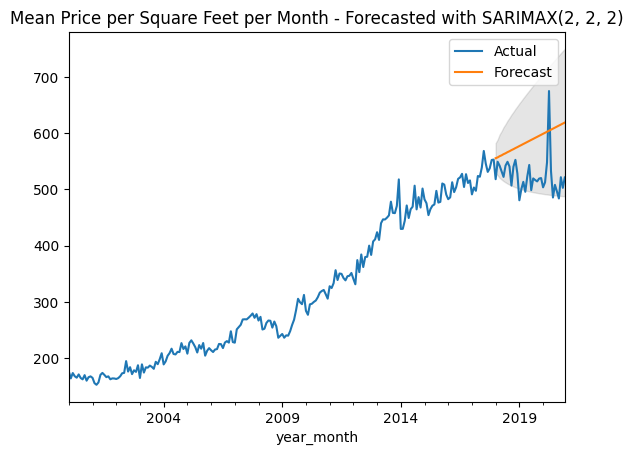

RMSE with SARIMAX(1, 2, 1): 75.64405187880544


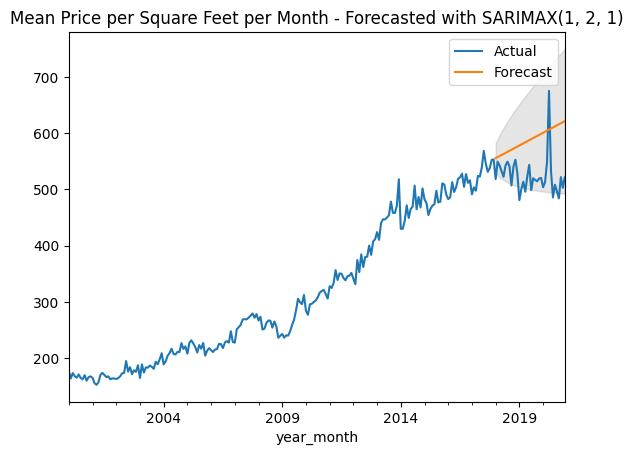

RMSE with SARIMAX(1, 2, 2): 81.48754760807371


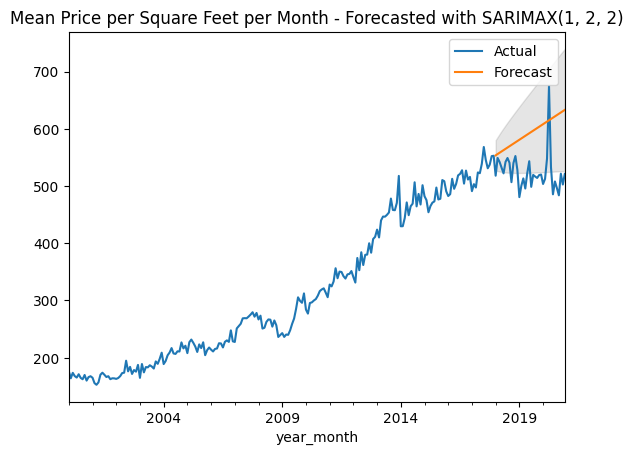

RMSE with SARIMAX(1, 1, 1): 41.763953799773226


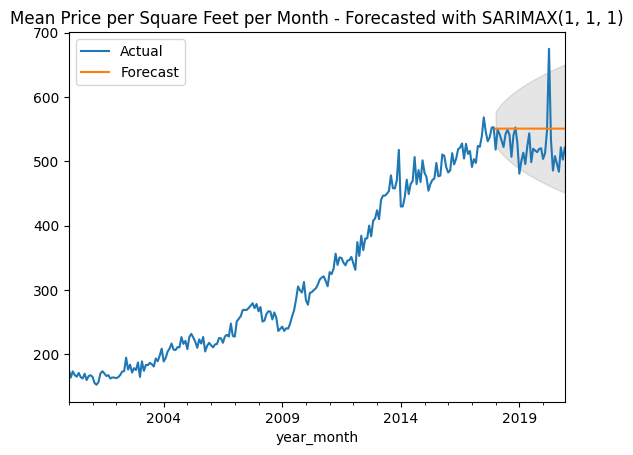

RMSE with SARIMAX(1, 1, 2): 41.92501903260061


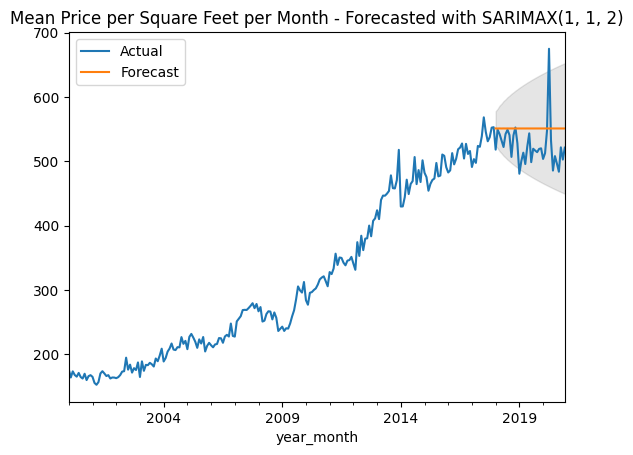

In [58]:
best_orders =[f'({order})' for order in df_top_10_sarima_eval['model'].str.extract(r'\((\d+, \d+, \d+)\)', expand=False)][:5]
forecast_length = 12 * 3

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plot_train_set_mean_forecast(SARIMAX, mean_monthly_price_psf_train['price_psf'], literal_eval(best_order), forecast_length)

From the plots above, similar to ARIMA, SARIMA(3, 1, 2) is the best model, followed by SARIMA(1, 1, 1) and SARIMA(1, 1, 2).

### Holt's exponential smoothing on mean `price_psf`

In [59]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

models, mse, rmse, mae, mape, r2, me, rmsle, mpd, mgd, aic, bic = [], [], [], [], [], [], [], [], [], [], [], []

periods = range(1,13)
for period in tqdm(periods, total=len(periods)):
    for fold, (train, test) in enumerate(block_cv(mean_monthly_price_psf_train['price_psf'], n_splits=2)):
        fold_mse, fold_rmse, fold_mae, fold_mape, fold_r2, fold_me, fold_rmsle, fold_mpd, fold_mgd, fold_aic, fold_bic = [], [], [], [], [], [], [], [], [], [], []
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                holt = ETSModel(
                    train, 
                    error='add', 
                    trend='mul', 
                    seasonal='mul', 
                    freq=train.index.inferred_freq, 
                    seasonal_periods=period, 
                    damped_trend=True
                ).fit()
                holt_forecast = holt.forecast(len(test))
                results = evaluate_model(val, holt_forecast)
                fold_mse.append(results['mse'])
                fold_rmse.append(results['rmse'])
                fold_mae.append(results['mae'])
                fold_mape.append(results['mape'])
                fold_r2.append(results['r2'])
                fold_me.append(results['me'])
                fold_rmsle.append(results['rmsle'])
                fold_mpd.append(results['mpd'])
                fold_mgd.append(results['mgd'])
                fold_aic.append(holt.aic)
                fold_bic.append(holt.bic)
            except:
                fold_mse.append(np.nan)
                fold_rmse.append(np.nan)
                fold_mae.append(np.nan)
                fold_mape.append(np.nan)
                fold_r2.append(np.nan)
                fold_me.append(np.nan)
                fold_rmsle.append(np.nan)
                fold_mpd.append(np.nan)
                fold_mgd.append(np.nan)
                fold_aic.append(np.nan)
                fold_bic.append(np.nan)

    models.append(f'Holt (p={period})')
    mse.append(mean(fold_mse))
    rmse.append(mean(fold_rmse))
    mae.append(mean(fold_mae))
    mape.append(mean(fold_mape))
    r2.append(mean(fold_r2))
    me.append(mean(fold_me))
    rmsle.append(mean(fold_rmsle))
    mpd.append(mean(fold_mpd))
    mgd.append(mean(fold_mgd))
    aic.append(mean(fold_aic))
    bic.append(mean(fold_bic))

df_holt_eval = pd.DataFrame({'model': models, 'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2, 'me': me, 'rmsle': rmsle, 'mpd': mpd, 'mgd': mgd, 'aic': aic, 'bic': bic})
df_holt_eval.sort_values(by=['rmse'], ascending=True).head(10)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:01<00:00,  7.04it/s]


model          mse       rmse        mae      mape        r2  \
10  Holt (p=11)   874.986626  29.580173  25.471040  0.051182 -3.878291   
8    Holt (p=9)  1139.263411  33.752976  30.504550  0.061120 -5.351707   
5    Holt (p=6)  1168.979081  34.190336  32.788255  0.065366 -5.517380   
1    Holt (p=2)  1288.226280  35.891869  34.003387  0.067889 -6.182216   
9   Holt (p=10)  1302.473212  36.089794  33.792005  0.067523 -6.261647   
2    Holt (p=3)  1346.547976  36.695340  34.521448  0.068984 -6.507376   
6    Holt (p=7)  1414.335299  37.607649  35.162152  0.070222 -6.885309   
4    Holt (p=5)  1446.067226  38.027191  34.736503  0.069566 -7.062223   
3    Holt (p=4)  1604.812224  40.060108  38.057298  0.075855 -7.947270   
7    Holt (p=8)  1608.378279  40.104592  38.668151  0.076964 -7.967152   

           me     rmsle       mpd       mgd          aic          bic  
10  49.012674  0.057568  1.683643  0.003241  1117.325874  1167.500725  
8   56.105061  0.065344  2.178871  0.004169  1122.030258  1166.630126  
5   49.127827  0.065986  2.231943  0.004264  1118.182723  1154.420115  
1   52.171815  0.069220  2.455488  0.004683  1113.516007  1138.603433  
9   49.122759  0.069568  2.481084  0.004729  1124.092098  1171.479458  
2   55.371520  0.070753  2.564979  0.004888  1117.758500  1145.633417  
6   50.149397  0.072279  2.684760  0.005100  1119.604801  1158.629685  
4   61.487374  0.073256  2.748218  0.005226  1120.011323  1153.461224  
3   55.248863  0.076675  3.032772  0.005735  1104.802267  1135.464676  
7   52.465575  0.076697  3.038110  0.005743  1111.965362  1153.777738

In [60]:
df_holt_eval = rank_models(df_holt_eval, metrics)

df_holt_eval['rank_mean'] = df_holt_eval[[col for col in df_holt_eval.columns if col.startswith('rank_')]].mean(axis=1)
df_top_10_holt_eval = df_holt_eval.sort_values(by=['rank_mean']).head(10)
df_top_10_holt_eval

model          mse       rmse        mae      mape        r2  \
10  Holt (p=11)   874.986626  29.580173  25.471040  0.051182 -3.878291   
8    Holt (p=9)  1139.263411  33.752976  30.504550  0.061120 -5.351707   
5    Holt (p=6)  1168.979081  34.190336  32.788255  0.065366 -5.517380   
1    Holt (p=2)  1288.226280  35.891869  34.003387  0.067889 -6.182216   
9   Holt (p=10)  1302.473212  36.089794  33.792005  0.067523 -6.261647   
2    Holt (p=3)  1346.547976  36.695340  34.521448  0.068984 -6.507376   
6    Holt (p=7)  1414.335299  37.607649  35.162152  0.070222 -6.885309   
4    Holt (p=5)  1446.067226  38.027191  34.736503  0.069566 -7.062223   
3    Holt (p=4)  1604.812224  40.060108  38.057298  0.075855 -7.947270   
7    Holt (p=8)  1608.378279  40.104592  38.668151  0.076964 -7.967152   

           me     rmsle       mpd       mgd  ...  rank_mse  rank_rmse  \
10  49.012674  0.057568  1.683643  0.003241  ...       1.0        1.0   
8   56.105061  0.065344  2.178871  0.004169  ...       2.0        2.0   
5   49.127827  0.065986  2.231943  0.004264  ...       3.0        3.0   
1   52.171815  0.069220  2.455488  0.004683  ...       4.0        4.0   
9   49.122759  0.069568  2.481084  0.004729  ...       5.0        5.0   
2   55.371520  0.070753  2.564979  0.004888  ...       6.0        6.0   
6   50.149397  0.072279  2.684760  0.005100  ...       7.0        7.0   
4   61.487374  0.073256  2.748218  0.005226  ...       8.0        8.0   
3   55.248863  0.076675  3.032772  0.005735  ...       9.0        9.0   
7   52.465575  0.076697  3.038110  0.005743  ...      10.0       10.0   

    rank_mae  rank_mape  rank_r2  rank_me  rank_rmsle  rank_mpd  rank_mgd  \
10       1.0        1.0      1.0      1.0         1.0       1.0       1.0   
8        2.0        2.0      2.0     10.0         2.0       2.0       2.0   
5        3.0        3.0      3.0      3.0         3.0       3.0       3.0   
1        5.0        5.0      4.0      5.0         4.0       4.0       4.0   
9        4.0        4.0      5.0      2.0         5.0       5.0       5.0   
2        6.0        6.0      6.0      9.0         6.0       6.0       6.0   
6        8.0        8.0      7.0      4.0         7.0       7.0       7.0   
4        7.0        7.0      8.0     11.0         8.0       8.0       8.0   
3        9.0        9.0      9.0      8.0         9.0       9.0       9.0   
7       10.0       10.0     10.0      6.0        10.0      10.0      10.0   

    rank_mean  
10   1.000000  
8    2.888889  
5    3.000000  
1    4.333333  
9    4.444444  
2    6.333333  
6    6.888889  
4    8.111111  
3    8.888889  
7    9.555556  

[10 rows x 22 columns]

Holt-Winter's exponential smoothing has lowest MAE and RMSE when period is 11.

In [61]:
def plot_train_set_mean_forecast_holt(train_data, period, forecast_length=12, verbose=False):

    train = train_data.iloc[:-forecast_length]
    val = train_data.iloc[-forecast_length:]

    holt = ETSModel(
        train, 
        error='add', 
        trend='mul', 
        seasonal='mul', 
        freq=train.index.inferred_freq, 
        seasonal_periods=period, 
        damped_trend=True
    ).fit()
    holt_forecast = holt.forecast(forecast_length)
    if verbose:
        print(holt.summary())
    print(f'RMSE with Holt(p={period}): {mean_squared_error(val, holt_forecast, squared=False)}')

    mean_monthly_price_psf_train.plot(
        kind='line',
        title='Mean Price per Square Feet per Month - Forecasted with Holt',
    )
    holt_forecast.plot(
        kind='line',
    )
    plt.legend(['Actual', 'Forecast'])
    plt.show()

RMSE with Holt(p=11): 64.65056528428616


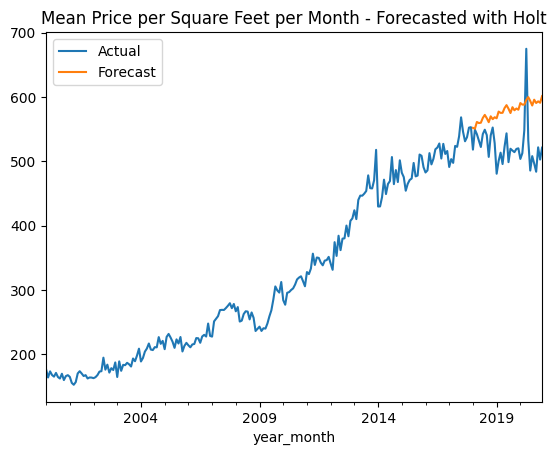

RMSE with Holt(p=9): 64.3605797833493


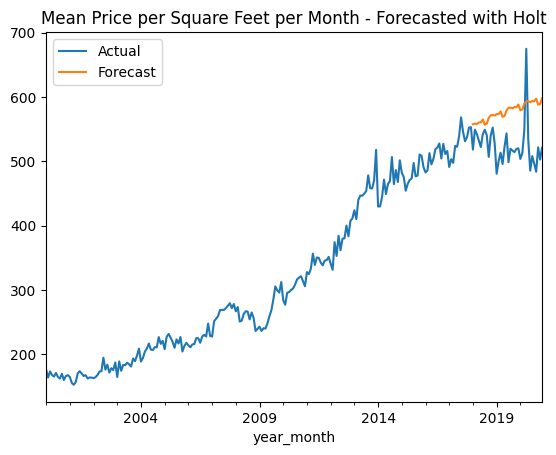

RMSE with Holt(p=6): 57.92777433226304


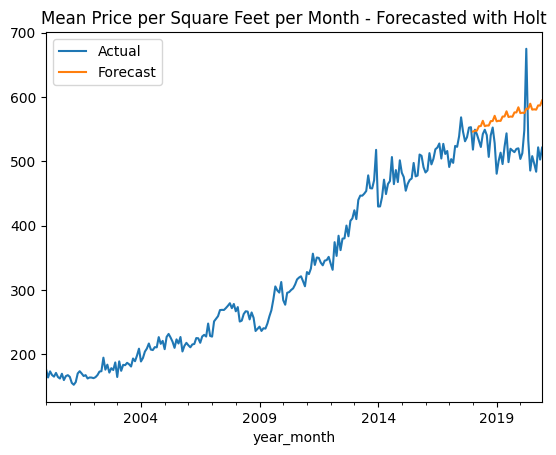

RMSE with Holt(p=2): 61.39926607217682


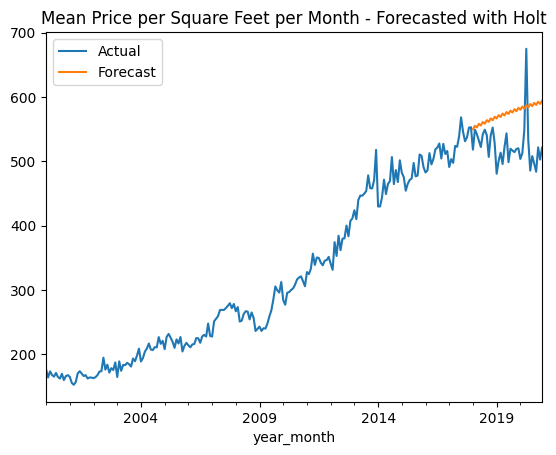

RMSE with Holt(p=10): 66.1622006504728


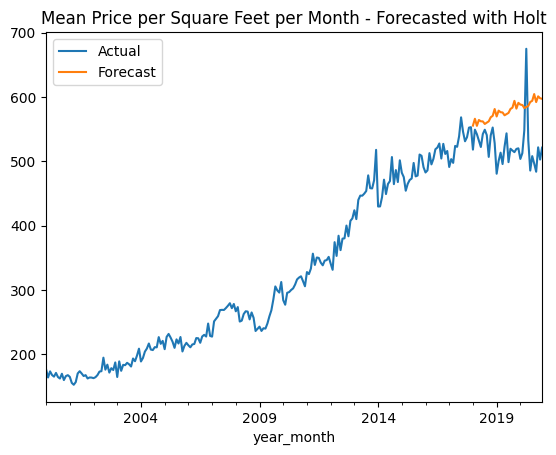

In [62]:
best_period = [period for period in df_top_10_holt_eval['model'].str.extract(r'\(p=(\d+)\)', expand=False)][:5]
forecast_length = 36

for period in best_period:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plot_train_set_mean_forecast_holt(mean_monthly_price_psf_train['price_psf'], literal_eval(period), forecast_length)

Unfortunately `ETSModel` does not support prediction intervals like `ARIMA` and `SARIMAX`. However, the best model for Holt has higher RMSE than best model of ARIMA/SARIMAX.

Let's evaluate on test set.

### Cross-validation results on mean `price_psf`

In [63]:
df_mean_price_psf_train_results = pd.concat([df_top_10_arima_eval[:5], df_top_10_sarima_eval[:5], df_top_10_holt_eval[:5]]).reset_index(drop=True)
df_mean_price_psf_train_results = rank_models(df_mean_price_psf_train_results, metrics)
df_mean_price_psf_train_results['rank_mean'] = df_mean_price_psf_train_results[[col for col in df_mean_price_psf_train_results.columns if col.startswith('rank_')]].mean(axis=1)
df_mean_price_psf_train_results

model          mse       rmse        mae      mape        r2  \
0     ARIMA (2, 2, 2)   154.787904  12.441379  10.933053  0.021463  0.137015   
1     ARIMA (1, 2, 1)   159.875610  12.644193  10.453818  0.020606  0.108649   
2     ARIMA (1, 2, 2)   677.732268  26.033292  23.513177  0.046033 -2.778544   
3     ARIMA (1, 1, 1)   784.248623  28.004439  24.413935  0.049032 -3.372402   
4     ARIMA (1, 1, 2)   933.909013  30.559925  27.247881  0.054652 -4.206800   
5   SARIMAX (2, 2, 2)   154.787904  12.441379  10.933053  0.021463  0.137015   
6   SARIMAX (1, 2, 1)   159.875610  12.644193  10.453818  0.020606  0.108649   
7   SARIMAX (1, 2, 2)   677.732268  26.033292  23.513177  0.046033 -2.778544   
8   SARIMAX (1, 1, 1)   784.248623  28.004439  24.413935  0.049032 -3.372402   
9   SARIMAX (1, 1, 2)   933.909013  30.559925  27.247881  0.054652 -4.206800   
10        Holt (p=11)   874.986626  29.580173  25.471040  0.051182 -3.878291   
11         Holt (p=9)  1139.263411  33.752976  30.504550  0.061120 -5.351707   
12         Holt (p=6)  1168.979081  34.190336  32.788255  0.065366 -5.517380   
13         Holt (p=2)  1288.226280  35.891869  34.003387  0.067889 -6.182216   
14        Holt (p=10)  1302.473212  36.089794  33.792005  0.067523 -6.261647   

           me     rmsle       mpd       mgd  ...  rank_mse  rank_rmse  \
0   18.988822  0.024511  0.306651  0.000608  ...       1.5        1.5   
1   18.899635  0.024974  0.316825  0.000628  ...       3.5        3.5   
2   36.528500  0.052243  1.376984  0.002799  ...       5.5        5.5   
3   47.624275  0.054632  1.513975  0.002924  ...       7.5        7.5   
4   49.849709  0.059410  1.795569  0.003454  ...      10.5       10.5   
5   18.988822  0.024511  0.306651  0.000608  ...       1.5        1.5   
6   18.899635  0.024974  0.316825  0.000628  ...       3.5        3.5   
7   36.528500  0.052243  1.376984  0.002799  ...       5.5        5.5   
8   47.624275  0.054632  1.513975  0.002924  ...       7.5        7.5   
9   49.849709  0.059410  1.795569  0.003454  ...      10.5       10.5   
10  49.012674  0.057568  1.683643  0.003241  ...       9.0        9.0   
11  56.105061  0.065344  2.178871  0.004169  ...      12.0       12.0   
12  49.127827  0.065986  2.231943  0.004264  ...      13.0       13.0   
13  52.171815  0.069220  2.455488  0.004683  ...      14.0       14.0   
14  49.122759  0.069568  2.481084  0.004729  ...      15.0       15.0   

    rank_mae  rank_mape  rank_r2  rank_me  rank_rmsle  rank_mpd  rank_mgd  \
0        3.5        3.5      1.5      3.5         1.5       1.5       1.5   
1        1.5        1.5      3.5      1.5         3.5       3.5       3.5   
2        5.5        5.5      5.5      5.5         5.5       5.5       5.5   
3        7.5        7.5      7.5      7.5         7.5       7.5       7.5   
4       10.5       10.5     10.5     12.5        10.5      10.5      10.5   
5        3.5        3.5      1.5      3.5         1.5       1.5       1.5   
6        1.5        1.5      3.5      1.5         3.5       3.5       3.5   
7        5.5        5.5      5.5      5.5         5.5       5.5       5.5   
8        7.5        7.5      7.5      7.5         7.5       7.5       7.5   
9       10.5       10.5     10.5     12.5        10.5      10.5      10.5   
10       9.0        9.0      9.0      9.0         9.0       9.0       9.0   
11      12.0       12.0     12.0     15.0        12.0      12.0      12.0   
12      13.0       13.0     13.0     11.0        13.0      13.0      13.0   
13      15.0       15.0     14.0     14.0        14.0      14.0      14.0   
14      14.0       14.0     15.0     10.0        15.0      15.0      15.0   

    rank_mean  
0    2.083333  
1    2.716667  
2    5.250000  
3    7.150000  
4   10.150000  
5    2.083333  
6    2.716667  
7    5.250000  
8    7.150000  
9   10.150000  
10   8.200000  
11  11.388889  
12  11.800000  
13  13.233333  
14  13.244444  

[15 rows x 22 columns]

In [64]:
df_mean_price_psf_train_metrics = df_mean_price_psf_train_results[metrics].T.rename(columns=df_mean_price_psf_train_results['model']).reset_index(drop=True)
df_mean_price_psf_train_metrics

ARIMA (2, 2, 2)  ARIMA (1, 2, 1)  ARIMA (1, 2, 2)  ARIMA (1, 1, 1)  \
0       154.787904       159.875610       677.732268       784.248623   
1        12.441379        12.644193        26.033292        28.004439   
2        10.933053        10.453818        23.513177        24.413935   
3         0.021463         0.020606         0.046033         0.049032   
4         0.137015         0.108649        -2.778544        -3.372402   
5        18.988822        18.899635        36.528500        47.624275   
6         0.024511         0.024974         0.052243         0.054632   
7         0.306651         0.316825         1.376984         1.513975   
8         0.000608         0.000628         0.002799         0.002924   

   ARIMA (1, 1, 2)  SARIMAX (2, 2, 2)  SARIMAX (1, 2, 1)  SARIMAX (1, 2, 2)  \
0       933.909013         154.787904         159.875610         677.732268   
1        30.559925          12.441379          12.644193          26.033292   
2        27.247881          10.933053          10.453818          23.513177   
3         0.054652           0.021463           0.020606           0.046033   
4        -4.206800           0.137015           0.108649          -2.778544   
5        49.849709          18.988822          18.899635          36.528500   
6         0.059410           0.024511           0.024974           0.052243   
7         1.795569           0.306651           0.316825           1.376984   
8         0.003454           0.000608           0.000628           0.002799   

   SARIMAX (1, 1, 1)  SARIMAX (1, 1, 2)  Holt (p=11)   Holt (p=9)  \
0         784.248623         933.909013   874.986626  1139.263411   
1          28.004439          30.559925    29.580173    33.752976   
2          24.413935          27.247881    25.471040    30.504550   
3           0.049032           0.054652     0.051182     0.061120   
4          -3.372402          -4.206800    -3.878291    -5.351707   
5          47.624275          49.849709    49.012674    56.105061   
6           0.054632           0.059410     0.057568     0.065344   
7           1.513975           1.795569     1.683643     2.178871   
8           0.002924           0.003454     0.003241     0.004169   

    Holt (p=6)   Holt (p=2)  Holt (p=10)  
0  1168.979081  1288.226280  1302.473212  
1    34.190336    35.891869    36.089794  
2    32.788255    34.003387    33.792005  
3     0.065366     0.067889     0.067523  
4    -5.517380    -6.182216    -6.261647  
5    49.127827    52.171815    49.122759  
6     0.065986     0.069220     0.069568  
7     2.231943     2.455488     2.481084  
8     0.004264     0.004683     0.004729

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

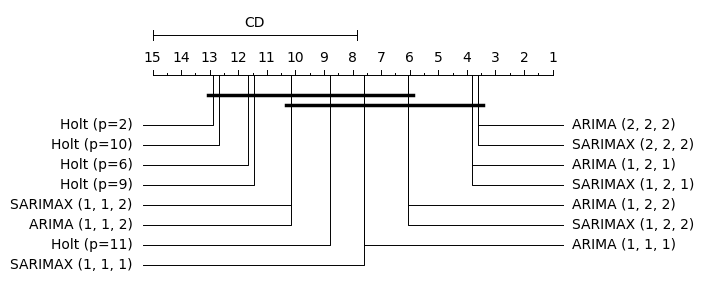

In [65]:
from autorank import autorank, plot_stats

result = autorank(df_mean_price_psf_train_metrics, alpha=0.05, verbose=False, order='ascending')
plot_stats(result)
plt.show()

On train set, ARIMA(2, 2, 2) has statistically significant better performance than Holt(p=6,9,10,2).

In [66]:
for metric in metrics:
    rank_col = f'rank_{metric}'
    df_mean_price_psf_train_results[f'{metric.upper()}'] = df_mean_price_psf_train_results[metric].astype(str) + ' (' + df_mean_price_psf_train_results[rank_col].astype(str) + ')'

df_mean_price_psf_train_results.to_excel(REPORTS_DATA_DIR / 'mean_price_psf_train_results_with_rank.xlsx', index=False)

## Evaluate models on mean `price_psf` test set

Length of grouped dataframe: 30


C:\Users\USER\AppData\Local\Temp\ipykernel_25976\619011678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly_price_psf_test['year_month'] = pd.to_datetime(df_monthly_price_psf_test[['year', 'month']].assign(day=1))


<Axes: title={'center': 'Mean and Median Price per Square Feet per Month (2020-2023)'}, xlabel='year_month'>

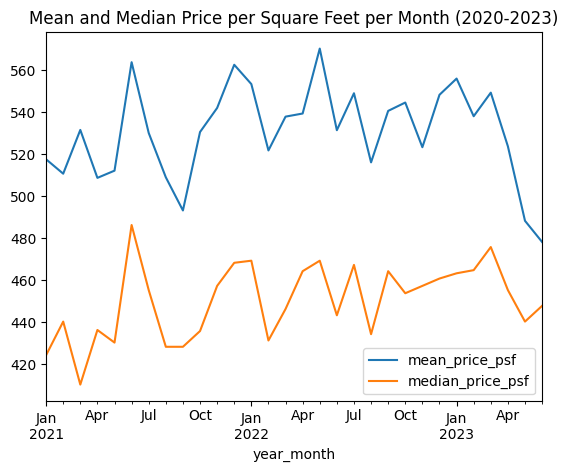

In [67]:
df_monthly_price_psf_test = df_test[['year', 'month', 'price_psf']]
df_monthly_price_psf_test['year_month'] = pd.to_datetime(df_monthly_price_psf_test[['year', 'month']].assign(day=1))

mean_monthly_price_psf_test = df_monthly_price_psf_test[['year_month', 'price_psf']].groupby('year_month').mean()
median_monthly_price_psf_test = df_monthly_price_psf_test[['year_month', 'price_psf']].groupby('year_month').median()

df_price_psf_per_month_test = pd.concat([mean_monthly_price_psf_test, median_monthly_price_psf_test], axis=1)
df_price_psf_per_month_test.columns = ['mean_price_psf', 'median_price_psf']

print(f'Length of grouped dataframe: {len(df_price_psf_per_month_test)}')

df_price_psf_per_month_test.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month (2020-2023)',
)

<Axes: title={'center': 'Mean and Median Price per Square Feet per Month (2000-2023)'}, xlabel='year_month'>

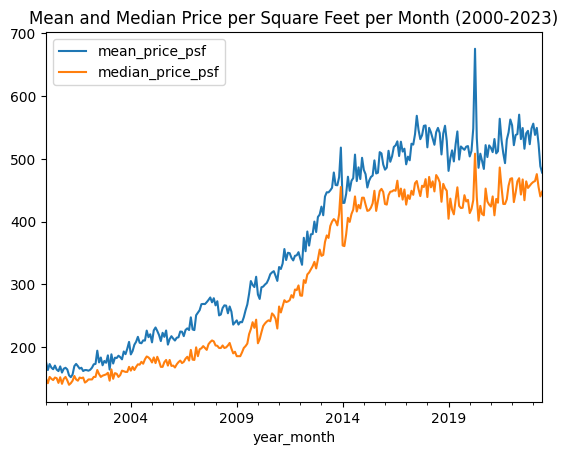

In [68]:
df_monthly_price_psf = pd.concat([df_price_psf_per_month_train, df_price_psf_per_month_test], axis=0)
monthly_price_psf = df_monthly_price_psf[['mean_price_psf', 'median_price_psf']]
monthly_price_psf.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month (2000-2023)',
)

In [69]:
def plot_arma_mean_forecast(model, data, order, forecast_length=12, verbose=False):
    train = data.iloc[:-forecast_length]
    val = data.iloc[-forecast_length:]

    model = model(train, order=order, freq=train.index.inferred_freq)
    model_name = model.__class__.__name__
    
    model = model.fit()
    model_forecast = model.get_forecast(forecast_length).summary_frame()
    forecast = model_forecast['mean']
    if verbose:
        print(model.summary())
    print(f'RMSE with {model_name}{order}: {mean_squared_error(val, forecast, squared=False)}')
    result = evaluate_model(val, forecast)

    data.plot(
        kind='line',
        title=f'Mean Price per Square Feet per Month (2000-2023) - Forecasted with {model_name}{order}',
    )
    forecast.plot(
        kind='line',
    )
    plt.fill_between(model_forecast.index, model_forecast['mean_ci_lower'], model_forecast['mean_ci_upper'], color='k', alpha=0.1)
    plt.legend(['Actual', 'Forecast'])
    plt.show()

    return {
        'model': f'{model_name} {str(order)}',
        **result,
    }

RMSE with ARIMA(2, 2, 2): 25.96724485910189


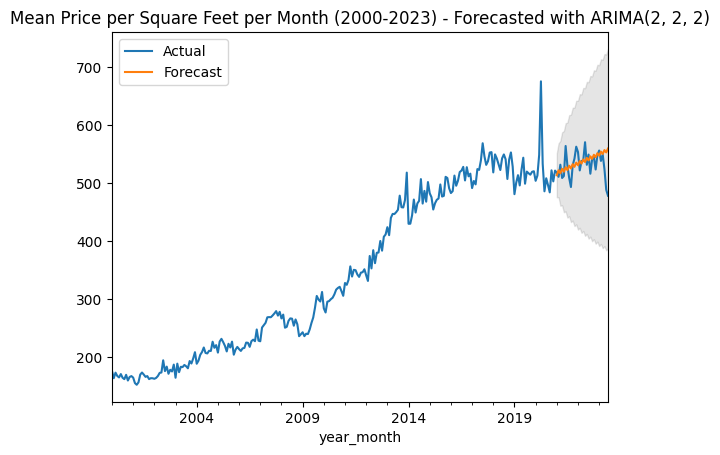

RMSE with ARIMA(1, 2, 1): 25.95401118056924


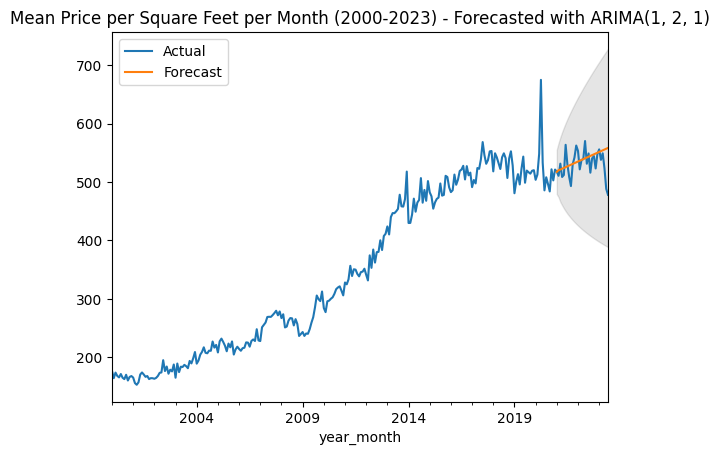

RMSE with ARIMA(1, 2, 2): 25.77010553009091


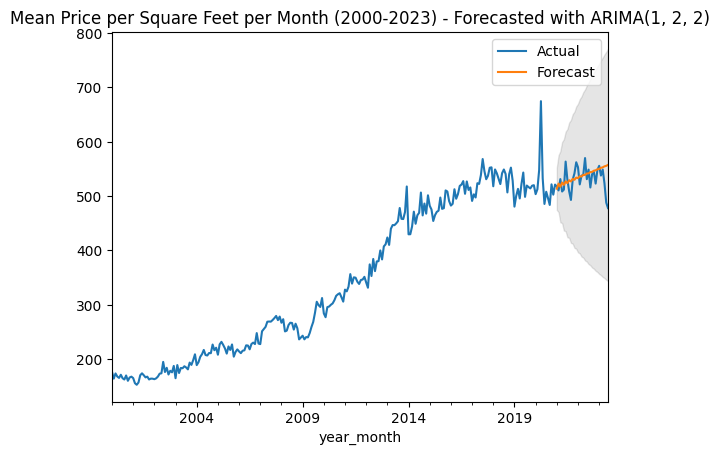

RMSE with ARIMA(1, 1, 1): 27.84509143451691


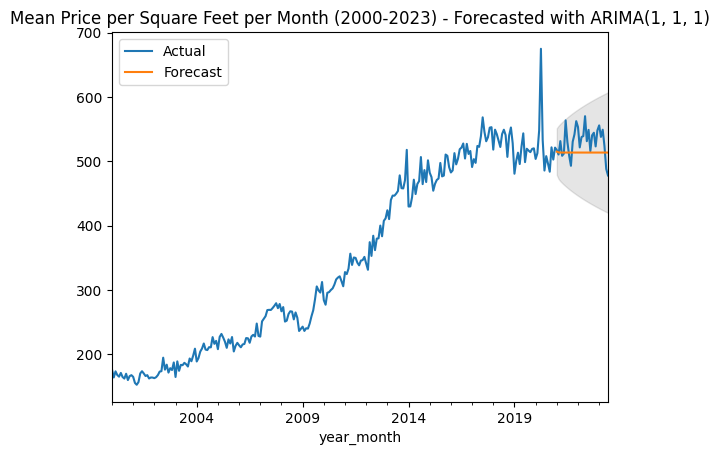

RMSE with ARIMA(1, 1, 2): 27.874815080642165


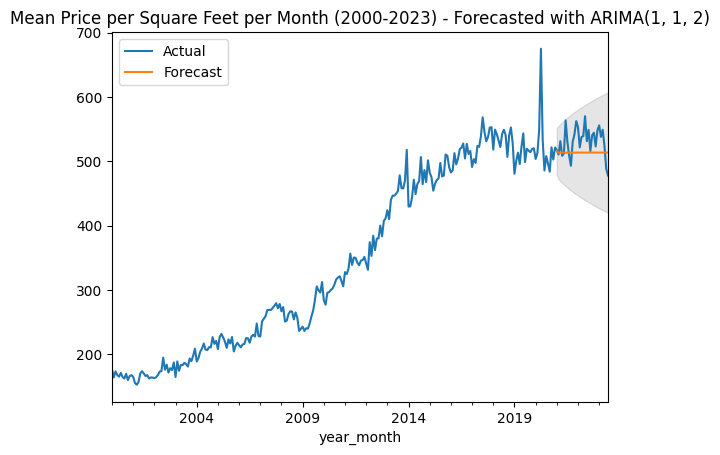

In [70]:
best_orders = [f'({order})' for order in df_top_10_arima_eval['model'].str.extract(r'\((\d+, \d+, \d+)\)', expand=False)][:5]
forecast_length = 30
arima_test_results = []

mean_monthly_price_psf = monthly_price_psf['mean_price_psf']

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        result = plot_arma_mean_forecast(ARIMA, mean_monthly_price_psf, literal_eval(best_order), forecast_length)
        arima_test_results.append(result)

RMSE with SARIMAX(2, 2, 2): 25.96724485910189


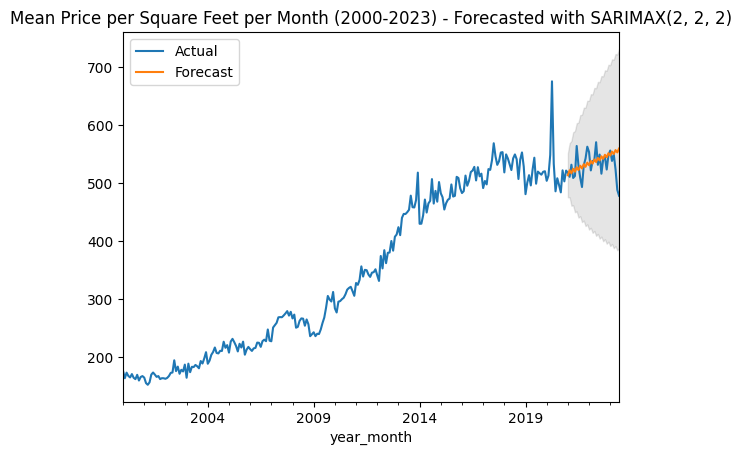

RMSE with SARIMAX(1, 2, 1): 25.95401118056924


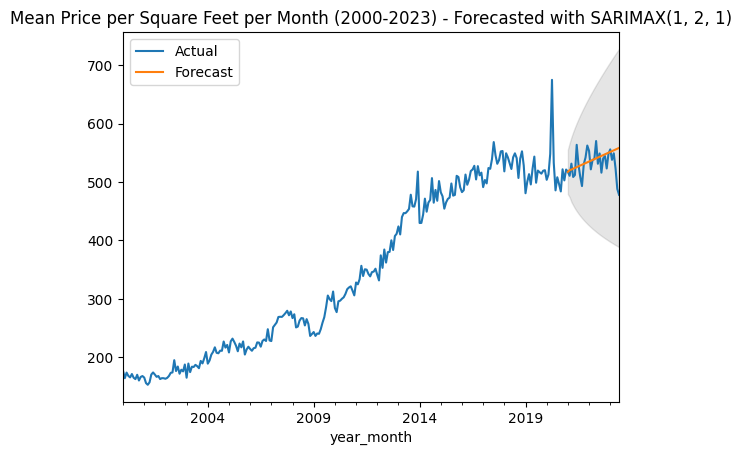

RMSE with SARIMAX(1, 2, 2): 25.77010553009091


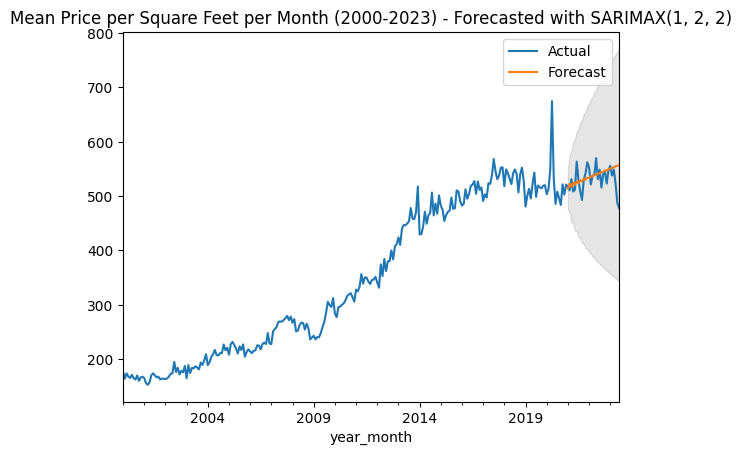

RMSE with SARIMAX(1, 1, 1): 27.84509143451691


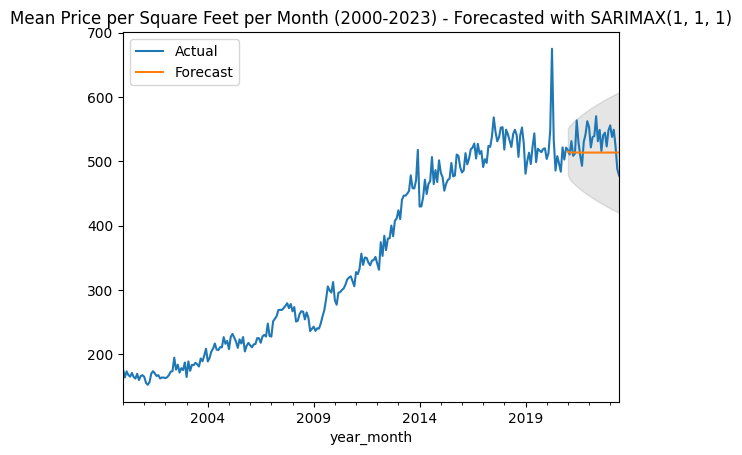

RMSE with SARIMAX(1, 1, 2): 27.874815080642165


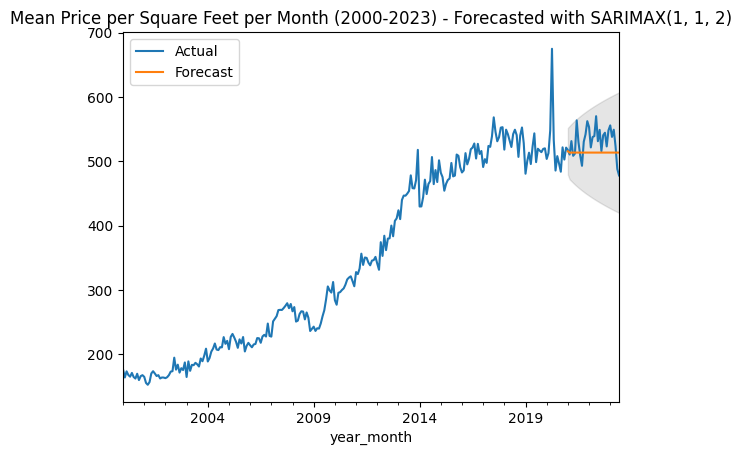

In [71]:
best_orders = [f'({order})' for order in df_top_10_sarima_eval['model'].str.extract(r'\((\d+, \d+, \d+)\)', expand=False)][:5]
sarima_test_results = []

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        result = plot_arma_mean_forecast(SARIMAX, mean_monthly_price_psf, literal_eval(best_order), forecast_length)
        sarima_test_results.append(result)

When evaluating on test set, it seems SARIMAX(4, 2, 2) has the lowest RMSE. SARIMAX(4, 2, 2) will be chosen as the best model.

In [72]:
def plot_holt_mean_forecast(data, period, forecast_length=12, verbose=False):
    train = data.iloc[:-forecast_length]
    val = data.iloc[-forecast_length:]

    holt = ETSModel(
        train, 
        error='add', 
        trend='mul', 
        seasonal='mul', 
        freq=train.index.inferred_freq, 
        seasonal_periods=period, 
        damped_trend=True
    ).fit()
    holt_forecast = holt.forecast(forecast_length)
    if verbose:
        print(holt.summary())
    print(f'RMSE: {mean_squared_error(val, holt_forecast, squared=False)}')
    result = evaluate_model(val, holt_forecast)

    data.plot(
        kind='line',
        title='Mean Price per Square Feet per Month (2000-2023) - Forecasted with Holt',
    )
    holt_forecast.plot(
        kind='line',
    )
    plt.legend(['Actual', 'Forecast'])
    plt.show()

    return {
        'model': f'Holt (p={period})',
        **result,
    }

RMSE: 26.783330703368865


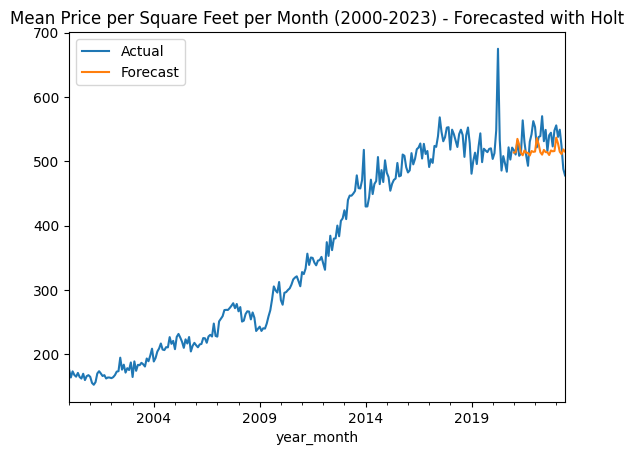

RMSE: 28.47186869008171


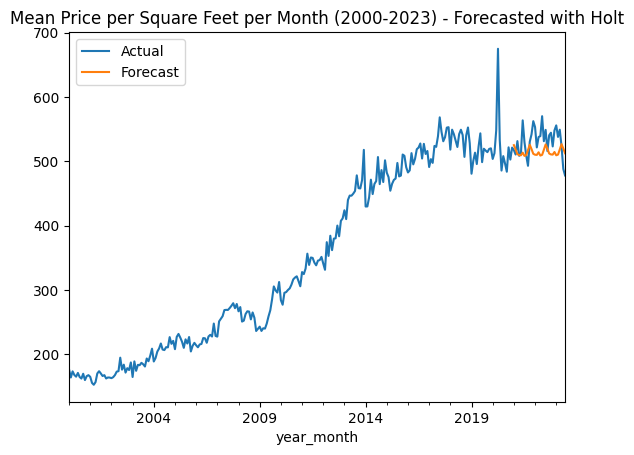

RMSE: 30.494440752528504


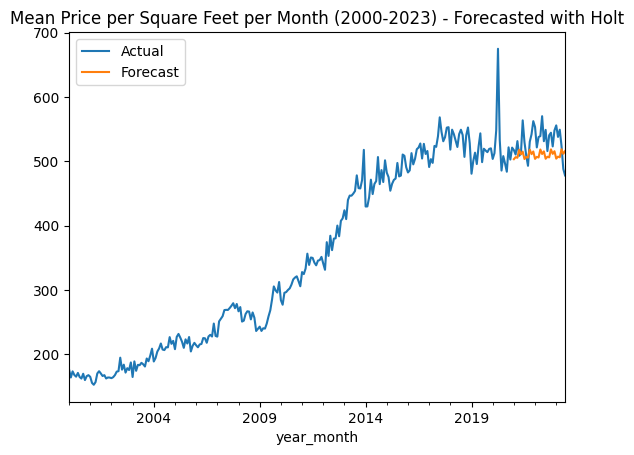

RMSE: 28.60682042833455


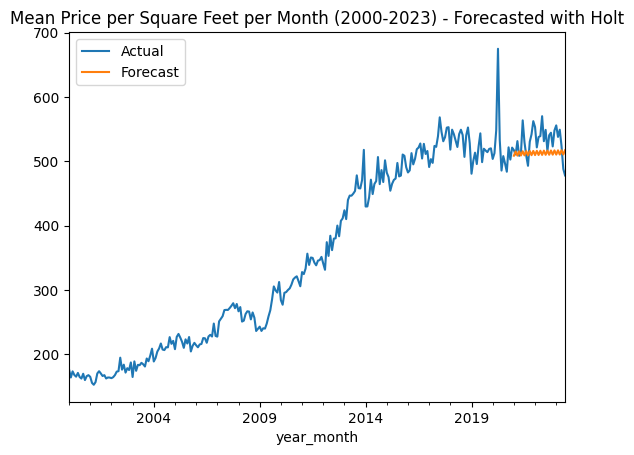

RMSE: 26.289381264658378


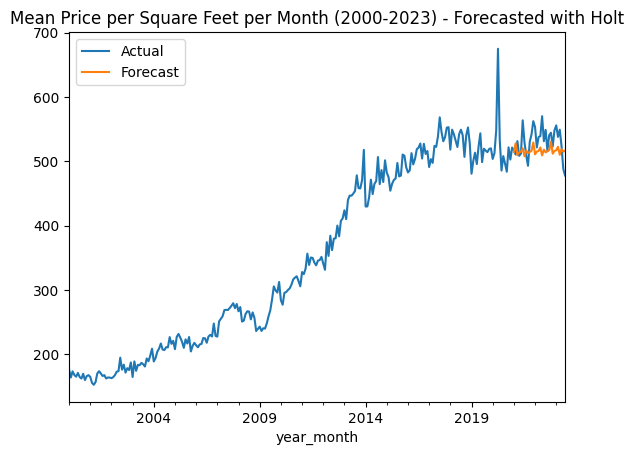

In [73]:
best_period = [period for period in df_top_10_holt_eval['model'].str.extract(r'\(p=(\d+)\)', expand=False)][:5]
holt_test_results = []

for period in best_period:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        result = plot_holt_mean_forecast(mean_monthly_price_psf, literal_eval(period), forecast_length)
        holt_test_results.append(result)

## Statistical evaluation on mean `price_psf` test set
We will employ three statistical tests to evaluate the performance of the models:
1. Friedman test
2. Iman-Davenport test
3. Nemenyi post-hoc test

These can be performed via the following steps as outlined in Zhan et al. (2023):
1. Ranking the performance of each algorithm according to different evaluation measures to obtain an average ranking for each algorithm;
2. Using Friedman and Iman–Davenport to test whether the algorithms all perform equally; 
3. Utilizing the Nemenyi post-hoc test to further distinguish between the algorithms.

In [74]:
mean_price_psf_test_results = arima_test_results + sarima_test_results + holt_test_results

df_mean_price_psf_test_results = pd.DataFrame(mean_price_psf_test_results)
df_mean_price_psf_test_results

model         mse       rmse        mae      mape        r2  \
0     ARIMA (2, 2, 2)  674.297806  25.967245  18.601215  0.035860 -0.380018   
1     ARIMA (1, 2, 1)  673.610696  25.954011  17.714812  0.034263 -0.378612   
2     ARIMA (1, 2, 2)  664.098339  25.770106  18.073931  0.034922 -0.359144   
3     ARIMA (1, 1, 1)  775.349117  27.845091  23.315712  0.043278 -0.586830   
4     ARIMA (1, 1, 2)  777.005316  27.874815  23.311949  0.043266 -0.590219   
5   SARIMAX (2, 2, 2)  674.297806  25.967245  18.601215  0.035860 -0.380018   
6   SARIMAX (1, 2, 1)  673.610696  25.954011  17.714812  0.034263 -0.378612   
7   SARIMAX (1, 2, 2)  664.098339  25.770106  18.073931  0.034922 -0.359144   
8   SARIMAX (1, 1, 1)  775.349117  27.845091  23.315712  0.043278 -0.586830   
9   SARIMAX (1, 1, 2)  777.005316  27.874815  23.311949  0.043266 -0.590219   
10        Holt (p=11)  717.346804  26.783331  21.853454  0.040678 -0.468122   
11         Holt (p=9)  810.647307  28.471869  23.505500  0.043671 -0.659071   
12         Holt (p=6)  929.910917  30.494441  25.834170  0.047939 -0.903156   
13         Holt (p=2)  818.350175  28.606820  23.990442  0.044534 -0.674836   
14        Holt (p=10)  691.131567  26.289381  21.954650  0.040889 -0.414470   

           me     rmsle       mpd       mgd  
0   81.248832  0.049272  1.264698  0.002374  
1   80.289443  0.049272  1.262742  0.002369  
2   79.517884  0.048942  1.245966  0.002340  
3   56.515116  0.052527  1.479490  0.002825  
4   56.567520  0.052584  1.482716  0.002831  
5   81.248832  0.049272  1.264698  0.002374  
6   80.289443  0.049272  1.262742  0.002369  
7   79.517884  0.048942  1.245966  0.002340  
8   56.515116  0.052527  1.479490  0.002825  
9   56.567520  0.052584  1.482716  0.002831  
10  59.761544  0.050559  1.368929  0.002614  
11  60.125137  0.053791  1.549436  0.002963  
12  58.763676  0.057750  1.783876  0.003424  
13  60.170631  0.054028  1.563987  0.002991  
14  60.914562  0.049628  1.318156  0.002516

### Assign rank to each model based on each evaluation metric

In [75]:
df_mean_price_psf_test_results = rank_models(df_mean_price_psf_test_results, metrics)
df_mean_price_psf_test_results

model         mse       rmse        mae      mape        r2  \
0     ARIMA (2, 2, 2)  674.297806  25.967245  18.601215  0.035860 -0.380018   
1     ARIMA (1, 2, 1)  673.610696  25.954011  17.714812  0.034263 -0.378612   
2     ARIMA (1, 2, 2)  664.098339  25.770106  18.073931  0.034922 -0.359144   
3     ARIMA (1, 1, 1)  775.349117  27.845091  23.315712  0.043278 -0.586830   
4     ARIMA (1, 1, 2)  777.005316  27.874815  23.311949  0.043266 -0.590219   
5   SARIMAX (2, 2, 2)  674.297806  25.967245  18.601215  0.035860 -0.380018   
6   SARIMAX (1, 2, 1)  673.610696  25.954011  17.714812  0.034263 -0.378612   
7   SARIMAX (1, 2, 2)  664.098339  25.770106  18.073931  0.034922 -0.359144   
8   SARIMAX (1, 1, 1)  775.349117  27.845091  23.315712  0.043278 -0.586830   
9   SARIMAX (1, 1, 2)  777.005316  27.874815  23.311949  0.043266 -0.590219   
10        Holt (p=11)  717.346804  26.783331  21.853454  0.040678 -0.468122   
11         Holt (p=9)  810.647307  28.471869  23.505500  0.043671 -0.659071   
12         Holt (p=6)  929.910917  30.494441  25.834170  0.047939 -0.903156   
13         Holt (p=2)  818.350175  28.606820  23.990442  0.044534 -0.674836   
14        Holt (p=10)  691.131567  26.289381  21.954650  0.040889 -0.414470   

           me     rmsle       mpd       mgd  rank_mse  rank_rmse  rank_mae  \
0   81.248832  0.049272  1.264698  0.002374       5.5        5.5       5.5   
1   80.289443  0.049272  1.262742  0.002369       3.5        3.5       1.5   
2   79.517884  0.048942  1.245966  0.002340       1.5        1.5       3.5   
3   56.515116  0.052527  1.479490  0.002825       9.5        9.5      11.5   
4   56.567520  0.052584  1.482716  0.002831      11.5       11.5       9.5   
5   81.248832  0.049272  1.264698  0.002374       5.5        5.5       5.5   
6   80.289443  0.049272  1.262742  0.002369       3.5        3.5       1.5   
7   79.517884  0.048942  1.245966  0.002340       1.5        1.5       3.5   
8   56.515116  0.052527  1.479490  0.002825       9.5        9.5      11.5   
9   56.567520  0.052584  1.482716  0.002831      11.5       11.5       9.5   
10  59.761544  0.050559  1.368929  0.002614       8.0        8.0       7.0   
11  60.125137  0.053791  1.549436  0.002963      13.0       13.0      13.0   
12  58.763676  0.057750  1.783876  0.003424      15.0       15.0      15.0   
13  60.170631  0.054028  1.563987  0.002991      14.0       14.0      14.0   
14  60.914562  0.049628  1.318156  0.002516       7.0        7.0       8.0   

    rank_mape  rank_r2  rank_me  rank_rmsle  rank_mpd  rank_mgd  
0         5.5      5.5     14.5         3.5       5.5       5.5  
1         1.5      3.5     12.5         5.5       3.5       3.5  
2         3.5      1.5     10.5         1.5       1.5       1.5  
3        11.5      9.5      1.5         9.5       9.5       9.5  
4         9.5     11.5      3.5        11.5      11.5      11.5  
5         5.5      5.5     14.5         3.5       5.5       5.5  
6         1.5      3.5     12.5         5.5       3.5       3.5  
7         3.5      1.5     10.5         1.5       1.5       1.5  
8        11.5      9.5      1.5         9.5       9.5       9.5  
9         9.5     11.5      3.5        11.5      11.5      11.5  
10        7.0      8.0      6.0         8.0       8.0       8.0  
11       13.0     13.0      7.0        13.0      13.0      13.0  
12       15.0     15.0      5.0        15.0      15.0      15.0  
13       14.0     14.0      8.0        14.0      14.0      14.0  
14        8.0      7.0      9.0         7.0       7.0       7.0

In [76]:
df_mean_price_psf_test_results['mean_rank'] = df_mean_price_psf_test_results[[col for col in df_mean_price_psf_test_results.columns if 'rank' in col]].mean(axis=1)
df_mean_price_psf_test_results

model         mse       rmse        mae      mape        r2  \
0     ARIMA (2, 2, 2)  674.297806  25.967245  18.601215  0.035860 -0.380018   
1     ARIMA (1, 2, 1)  673.610696  25.954011  17.714812  0.034263 -0.378612   
2     ARIMA (1, 2, 2)  664.098339  25.770106  18.073931  0.034922 -0.359144   
3     ARIMA (1, 1, 1)  775.349117  27.845091  23.315712  0.043278 -0.586830   
4     ARIMA (1, 1, 2)  777.005316  27.874815  23.311949  0.043266 -0.590219   
5   SARIMAX (2, 2, 2)  674.297806  25.967245  18.601215  0.035860 -0.380018   
6   SARIMAX (1, 2, 1)  673.610696  25.954011  17.714812  0.034263 -0.378612   
7   SARIMAX (1, 2, 2)  664.098339  25.770106  18.073931  0.034922 -0.359144   
8   SARIMAX (1, 1, 1)  775.349117  27.845091  23.315712  0.043278 -0.586830   
9   SARIMAX (1, 1, 2)  777.005316  27.874815  23.311949  0.043266 -0.590219   
10        Holt (p=11)  717.346804  26.783331  21.853454  0.040678 -0.468122   
11         Holt (p=9)  810.647307  28.471869  23.505500  0.043671 -0.659071   
12         Holt (p=6)  929.910917  30.494441  25.834170  0.047939 -0.903156   
13         Holt (p=2)  818.350175  28.606820  23.990442  0.044534 -0.674836   
14        Holt (p=10)  691.131567  26.289381  21.954650  0.040889 -0.414470   

           me     rmsle       mpd       mgd  rank_mse  rank_rmse  rank_mae  \
0   81.248832  0.049272  1.264698  0.002374       5.5        5.5       5.5   
1   80.289443  0.049272  1.262742  0.002369       3.5        3.5       1.5   
2   79.517884  0.048942  1.245966  0.002340       1.5        1.5       3.5   
3   56.515116  0.052527  1.479490  0.002825       9.5        9.5      11.5   
4   56.567520  0.052584  1.482716  0.002831      11.5       11.5       9.5   
5   81.248832  0.049272  1.264698  0.002374       5.5        5.5       5.5   
6   80.289443  0.049272  1.262742  0.002369       3.5        3.5       1.5   
7   79.517884  0.048942  1.245966  0.002340       1.5        1.5       3.5   
8   56.515116  0.052527  1.479490  0.002825       9.5        9.5      11.5   
9   56.567520  0.052584  1.482716  0.002831      11.5       11.5       9.5   
10  59.761544  0.050559  1.368929  0.002614       8.0        8.0       7.0   
11  60.125137  0.053791  1.549436  0.002963      13.0       13.0      13.0   
12  58.763676  0.057750  1.783876  0.003424      15.0       15.0      15.0   
13  60.170631  0.054028  1.563987  0.002991      14.0       14.0      14.0   
14  60.914562  0.049628  1.318156  0.002516       7.0        7.0       8.0   

    rank_mape  rank_r2  rank_me  rank_rmsle  rank_mpd  rank_mgd  mean_rank  
0         5.5      5.5     14.5         3.5       5.5       5.5   6.277778  
1         1.5      3.5     12.5         5.5       3.5       3.5   4.277778  
2         3.5      1.5     10.5         1.5       1.5       1.5   2.944444  
3        11.5      9.5      1.5         9.5       9.5       9.5   9.055556  
4         9.5     11.5      3.5        11.5      11.5      11.5  10.166667  
5         5.5      5.5     14.5         3.5       5.5       5.5   6.277778  
6         1.5      3.5     12.5         5.5       3.5       3.5   4.277778  
7         3.5      1.5     10.5         1.5       1.5       1.5   2.944444  
8        11.5      9.5      1.5         9.5       9.5       9.5   9.055556  
9         9.5     11.5      3.5        11.5      11.5      11.5  10.166667  
10        7.0      8.0      6.0         8.0       8.0       8.0   7.555556  
11       13.0     13.0      7.0        13.0      13.0      13.0  12.333333  
12       15.0     15.0      5.0        15.0      15.0      15.0  13.888889  
13       14.0     14.0      8.0        14.0      14.0      14.0  13.333333  
14        8.0      7.0      9.0         7.0       7.0       7.0   7.444444

In [77]:
for metric in metrics:
    rank_col = f'rank_{metric}'
    df_mean_price_psf_test_results[f'{metric.upper()}'] = df_mean_price_psf_test_results[metric].astype(str) + ' (' + df_mean_price_psf_test_results[rank_col].astype(str) + ')'

df_mean_price_psf_test_results.to_excel(REPORTS_DATA_DIR / 'mean_price_psf_test_results_with_rank.xlsx', index=False)

### Friedman test

H0: All models perform equally well.

H1: At least one model performs differently.

In [78]:
number_of_models = len(df_mean_price_psf_test_results)
number_of_metrics = len(metrics)

t_chi_square = 12 * number_of_metrics / (number_of_metrics * (number_of_metrics + 1)) * \
    sum((df_mean_price_psf_test_results['mean_rank'] - ((number_of_models * + 1) / 2)) ** 2)
print(f'Degrees of freedom (k-1): {number_of_models - 1}')
print(f't_chi_square: {t_chi_square}')

Degrees of freedom (k-1): 14
t_chi_square: 219.04074074074077


With DOF = 14 at alpha = 0.05, the critical value is 23.68 (see [link](https://people.smp.uq.edu.au/YoniNazarathy/stat_models_B_course_spring_07/distributions/chisqtab.pdf)).

Since the computed statistic (219.04) > critical value (23.68), we reject the null hypothesis H0 and conclude that there is statistically significant difference in the performance of all algorithms.

In [79]:
from scipy.stats import friedmanchisquare

friedmanchisquare(*df_mean_price_psf_test_results[metrics].values)

FriedmanchisquareResult(statistic=42.67827827827827, pvalue=9.643086403807553e-05)

Using the Friedman test from Scipy, the p-value is 9e-05, which is less than 0.05. This means that we reject the null hypothesis H0 and conclude that there is statistically significant difference in the performance of all algorithms.

### Iman-Davenport test

H0: All models perform equally well.

H1: At least one model performs differently.

In [80]:
t_F = (number_of_metrics - 1) * t_chi_square / (number_of_metrics * (number_of_models - 1) - t_chi_square)
print(f'Degrees of freedom 1 (d-1): {number_of_metrics - 1}')
print(f'Degrees of freedom 2 (d-1)(k-1): {(number_of_metrics - 1) * (number_of_models - 1)}')
print(f't_F: {t_F}')

Degrees of freedom 1 (d-1): 8
Degrees of freedom 2 (d-1)(k-1): 112
t_F: -18.83396361609808


With DOF1 = 8 and DOF2 = 112 at alpha = 0.05, the critical value is 2.056 (see [link](https://www.stat.purdue.edu/~lfindsen/stat503/F_alpha_05.pdf)).

In [81]:
critical_value_8_100 = 2.032
critical_value_8_120 = 2.016

critical_value_8_112 = (112 - 100) / (120 - 100) * (critical_value_8_120 - critical_value_8_100) + critical_value_8_100
critical_value_8_112

2.0224

Since the computed statistic (115.74) > critical value (2.056), we reject the null hypothesis H0 and conclude that there is statistically significant difference in the performance of all algorithms.

Note that the Iman-Davenport test is only useful when there are more evaluation metrics (> 5), as 𝑇𝜒2 will gradually be biased towards chi-square random variables with degrees of freedom 𝑘 − 1.

### Nemenyi post-hoc test

We can conduct the Nemenyi post-hoc test to find exactly which groups have different means.

In [82]:
df_mean_price_psf_test_metrics = df_mean_price_psf_test_results[metrics].T.rename(columns=df_mean_price_psf_test_results['model']).reset_index(drop=True)
df_mean_price_psf_test_metrics

ARIMA (2, 2, 2)  ARIMA (1, 2, 1)  ARIMA (1, 2, 2)  ARIMA (1, 1, 1)  \
0       674.297806       673.610696       664.098339       775.349117   
1        25.967245        25.954011        25.770106        27.845091   
2        18.601215        17.714812        18.073931        23.315712   
3         0.035860         0.034263         0.034922         0.043278   
4        -0.380018        -0.378612        -0.359144        -0.586830   
5        81.248832        80.289443        79.517884        56.515116   
6         0.049272         0.049272         0.048942         0.052527   
7         1.264698         1.262742         1.245966         1.479490   
8         0.002374         0.002369         0.002340         0.002825   

   ARIMA (1, 1, 2)  SARIMAX (2, 2, 2)  SARIMAX (1, 2, 1)  SARIMAX (1, 2, 2)  \
0       777.005316         674.297806         673.610696         664.098339   
1        27.874815          25.967245          25.954011          25.770106   
2        23.311949          18.601215          17.714812          18.073931   
3         0.043266           0.035860           0.034263           0.034922   
4        -0.590219          -0.380018          -0.378612          -0.359144   
5        56.567520          81.248832          80.289443          79.517884   
6         0.052584           0.049272           0.049272           0.048942   
7         1.482716           1.264698           1.262742           1.245966   
8         0.002831           0.002374           0.002369           0.002340   

   SARIMAX (1, 1, 1)  SARIMAX (1, 1, 2)  Holt (p=11)  Holt (p=9)  Holt (p=6)  \
0         775.349117         777.005316   717.346804  810.647307  929.910917   
1          27.845091          27.874815    26.783331   28.471869   30.494441   
2          23.315712          23.311949    21.853454   23.505500   25.834170   
3           0.043278           0.043266     0.040678    0.043671    0.047939   
4          -0.586830          -0.590219    -0.468122   -0.659071   -0.903156   
5          56.515116          56.567520    59.761544   60.125137   58.763676   
6           0.052527           0.052584     0.050559    0.053791    0.057750   
7           1.479490           1.482716     1.368929    1.549436    1.783876   
8           0.002825           0.002831     0.002614    0.002963    0.003424   

   Holt (p=2)  Holt (p=10)  
0  818.350175   691.131567  
1   28.606820    26.289381  
2   23.990442    21.954650  
3    0.044534     0.040889  
4   -0.674836    -0.414470  
5   60.170631    60.914562  
6    0.054028     0.049628  
7    1.563987     1.318156  
8    0.002991     0.002516

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

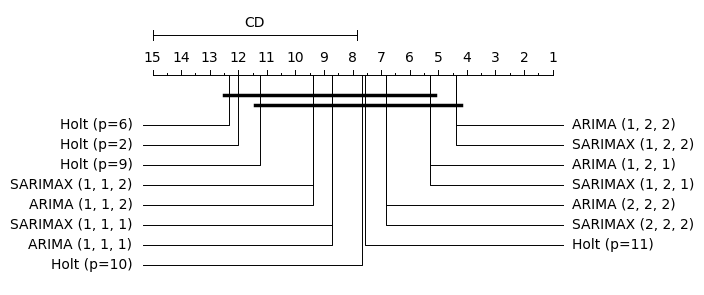

In [83]:
result = autorank(df_mean_price_psf_test_metrics, alpha=0.05, verbose=False, order='ascending')
plot_stats(result)
plt.show()

At alpha = 0.05, ARIMA/SARIMAX(1, 2, 2) has statistically significant better performance than Holt (p=2,6) only.

## Grid search with cross validation on median `price_psf`
Based on the analysis with ACF and PACF plots above, we will use the following configurations for ARIMA and SARIMA model:
- Mean `price_psf`: (p, d, q) = (3, 1, 2), (4, 2, 2)
- Median `price_psf`: (p, d, q) = (3, 1, 1), (7, 2, 2)

Similar to median `price_psf`, we then compare the models using RMSE, AIM and BIC.

In [84]:
from itertools import product

p = range(1,8)
i = range(1,3)
q = range(1,3)
orders = list(product(p, i, q))
print(f'Number of orders: {len(orders)}')

Number of orders: 28


### ARIMA on median `price_psf`

In [85]:
from statsmodels.tsa.arima.model import ARIMA
from statistics import mean
models, mse, rmse, mae, mape, r2, me, rmsle, mpd, mgd, aic, bic = [], [], [], [], [], [], [], [], [], [], [], []

for order in tqdm(orders, total=len(orders)):
    for fold, (train, val) in enumerate(block_cv(median_monthly_price_psf_train['price_psf'], n_splits=2)):
        fold_mse, fold_rmse, fold_mae, fold_mape, fold_r2, fold_me, fold_rmsle, fold_mpd, fold_mgd, fold_aic, fold_bic = [], [], [], [], [], [], [], [], [], [], []
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                arima = ARIMA(train, order=order, freq=train.index.inferred_freq).fit()
                arima_forecast = arima.forecast(len(val))
                results = evaluate_model(val, arima_forecast)
                fold_mse.append(results['mse'])
                fold_rmse.append(results['rmse'])
                fold_mae.append(results['mae'])
                fold_mape.append(results['mape'])
                fold_r2.append(results['r2'])
                fold_me.append(results['me'])
                fold_rmsle.append(results['rmsle'])
                fold_mpd.append(results['mpd'])
                fold_mgd.append(results['mgd'])
                fold_aic.append(arima.aic)
                fold_bic.append(arima.bic)
            except:
                fold_mse.append(np.nan)
                fold_rmse.append(np.nan)
                fold_mae.append(np.nan)
                fold_mape.append(np.nan)
                fold_r2.append(np.nan)
                fold_me.append(np.nan)
                fold_rmsle.append(np.nan)
                fold_mpd.append(np.nan)
                fold_mgd.append(np.nan)
                fold_aic.append(np.nan)
                fold_bic.append(np.nan)

    models.append(f'ARIMA {order}')
    mse.append(mean(fold_mse))
    rmse.append(mean(fold_rmse))
    mae.append(mean(fold_mae))
    mape.append(mean(fold_mape))
    r2.append(mean(fold_r2))
    me.append(mean(fold_me))
    rmsle.append(mean(fold_rmsle))
    mpd.append(mean(fold_mpd))
    mgd.append(mean(fold_mgd))
    aic.append(mean(fold_aic))
    bic.append(mean(fold_bic))

df_arima_eval = pd.DataFrame({'model': models, 'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2, 'me': me, 'rmsle': rmsle, 'mpd': mpd, 'mgd': mgd, 'aic': aic, 'bic': bic})
df_top_10_arima_eval = df_arima_eval.sort_values(by=['rmse'], ascending=True).head(10)
df_top_10_arima_eval

100%|██████████| 28/28 [00:11<00:00,  2.35it/s]


model         mse       rmse        mae      mape        r2  \
5   ARIMA (2, 1, 2)  195.612067  13.986138  12.515858  0.029147  0.014721   
0   ARIMA (1, 1, 1)  198.903755  14.103324  10.667647  0.024982 -0.001859   
1   ARIMA (1, 1, 2)  206.327485  14.364104  11.021327  0.025862 -0.039251   
6   ARIMA (2, 2, 1)  229.117939  15.136642  12.703918  0.029880 -0.154045   
4   ARIMA (2, 1, 1)  295.005168  17.175714  14.139231  0.033427 -0.485912   
2   ARIMA (1, 2, 1)  365.518962  19.118550  14.232574  0.032458 -0.841083   
9   ARIMA (3, 1, 2)  564.421995  23.757567  19.589676  0.046379 -1.842938   
7   ARIMA (2, 2, 2)  592.886152  24.349254  20.498529  0.047185 -1.986310   
8   ARIMA (3, 1, 1)  609.164305  24.681254  19.584806  0.046251 -2.068301   
12  ARIMA (4, 1, 1)  623.411954  24.968219  21.512507  0.050943 -2.140065   

           me     rmsle       mpd       mgd          aic          bic  
5   23.144528  0.032507  0.457180  0.001069  1032.344450  1046.240068  
0   23.721316  0.032780  0.463450  0.001080  1035.032863  1043.370234  
1   23.034162  0.033421  0.480755  0.001121  1036.609841  1047.726335  
6   21.969267  0.035201  0.532643  0.001239  1036.918225  1048.000964  
4   26.840270  0.040025  0.685154  0.001592  1034.749081  1045.865575  
2   39.566822  0.044443  0.862302  0.002035  1043.123789  1051.435843  
9   45.695971  0.054714  1.288088  0.002941  1022.280368  1038.955109  
7   41.586289  0.057455  1.420222  0.003404  1041.014831  1054.868254  
8   47.912232  0.056677  1.386936  0.003160  1021.387193  1035.282810  
12  45.961210  0.057561  1.424401  0.003257  1021.333470  1038.008211

In [86]:
df_arima_eval = rank_models(df_arima_eval, metrics)

df_arima_eval['rank_mean'] = df_arima_eval[[col for col in df_arima_eval.columns if col.startswith('rank_')]].mean(axis=1)
df_top_10_arima_eval = df_arima_eval.sort_values(by=['rank_mean']).head(10)
df_top_10_arima_eval

model         mse       rmse        mae      mape        r2  \
5   ARIMA (2, 1, 2)  195.612067  13.986138  12.515858  0.029147  0.014721   
0   ARIMA (1, 1, 1)  198.903755  14.103324  10.667647  0.024982 -0.001859   
1   ARIMA (1, 1, 2)  206.327485  14.364104  11.021327  0.025862 -0.039251   
6   ARIMA (2, 2, 1)  229.117939  15.136642  12.703918  0.029880 -0.154045   
4   ARIMA (2, 1, 1)  295.005168  17.175714  14.139231  0.033427 -0.485912   
2   ARIMA (1, 2, 1)  365.518962  19.118550  14.232574  0.032458 -0.841083   
9   ARIMA (3, 1, 2)  564.421995  23.757567  19.589676  0.046379 -1.842938   
8   ARIMA (3, 1, 1)  609.164305  24.681254  19.584806  0.046251 -2.068301   
7   ARIMA (2, 2, 2)  592.886152  24.349254  20.498529  0.047185 -1.986310   
18  ARIMA (5, 2, 1)  633.889541  25.177163  20.276395  0.048160 -2.192840   

           me     rmsle       mpd       mgd  ...  rank_mse  rank_rmse  \
5   23.144528  0.032507  0.457180  0.001069  ...       1.0        1.0   
0   23.721316  0.032780  0.463450  0.001080  ...       2.0        2.0   
1   23.034162  0.033421  0.480755  0.001121  ...       3.0        3.0   
6   21.969267  0.035201  0.532643  0.001239  ...       4.0        4.0   
4   26.840270  0.040025  0.685154  0.001592  ...       5.0        5.0   
2   39.566822  0.044443  0.862302  0.002035  ...       6.0        6.0   
9   45.695971  0.054714  1.288088  0.002941  ...       7.0        7.0   
8   47.912232  0.056677  1.386936  0.003160  ...       9.0        9.0   
7   41.586289  0.057455  1.420222  0.003404  ...       8.0        8.0   
18  47.568610  0.057973  1.444488  0.003294  ...      11.0       11.0   

    rank_mae  rank_mape  rank_r2  rank_me  rank_rmsle  rank_mpd  rank_mgd  \
5        3.0        3.0      1.0      3.0         1.0       1.0       1.0   
0        1.0        1.0      2.0      4.0         2.0       2.0       2.0   
1        2.0        2.0      3.0      2.0         3.0       3.0       3.0   
6        4.0        4.0      4.0      1.0         4.0       4.0       4.0   
4        5.0        6.0      5.0      5.0         5.0       5.0       5.0   
2        6.0        5.0      6.0      6.0         6.0       6.0       6.0   
9        8.0        8.0      7.0      8.0         7.0       7.0       7.0   
8        7.0        7.0      9.0     12.0         8.0       8.0       8.0   
7       11.0        9.0      8.0      7.0         9.0       9.0      12.0   
18       9.0       10.0     11.0     11.0        11.0      11.0      10.0   

    rank_mean  
5    1.666667  
0    2.000000  
1    2.666667  
6    3.666667  
4    5.111111  
2    5.888889  
9    7.333333  
8    8.555556  
7    9.000000  
18  10.555556  

[10 rows x 22 columns]

The best order inferred from the grid search is (2, 1, 2), which is different from the order suggested by ACF and PACF plots.

Despite the RMSE suggesting that ARIMA(2, 1, 2) is the best model, we should visualise it to see if it really is the best model. The model will be tasked to forecast 36 months ahead, aligns with the objective of forecasting 2021-2023 with 2000-2020 data.

In [87]:
def plot_train_set_median_forecast(model, train_data, order, forecast_length=12, verbose=False):
    train = train_data.iloc[:-forecast_length]
    val = train_data.iloc[-forecast_length:]

    model = model(train, order=order, freq=train.index.inferred_freq)
    model_name = model.__class__.__name__

    model = model.fit()
    model_forecast = model.get_forecast(forecast_length).summary_frame()
    forecast = model_forecast['mean']
    if verbose:
        print(model.summary())
    print(f'RMSE with {model_name}{order}: {mean_squared_error(val, forecast, squared=False)}')

    train_data.plot(
        kind='line',
        title=f'Median Price per Square Feet per Month - Forecasted with {model_name}{order}',
    )
    forecast.plot(
        kind='line',
    )
    plt.fill_between(model_forecast.index, model_forecast['mean_ci_lower'], model_forecast['mean_ci_upper'], color='k', alpha=0.1)
    plt.legend(['Actual', 'Forecast'])
    plt.show()

RMSE with ARIMA(2, 1, 2): 31.978924758830107


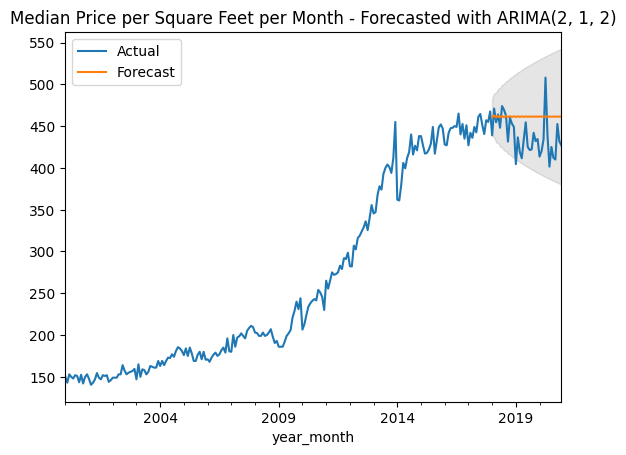

RMSE with ARIMA(1, 1, 1): 32.43227009620376


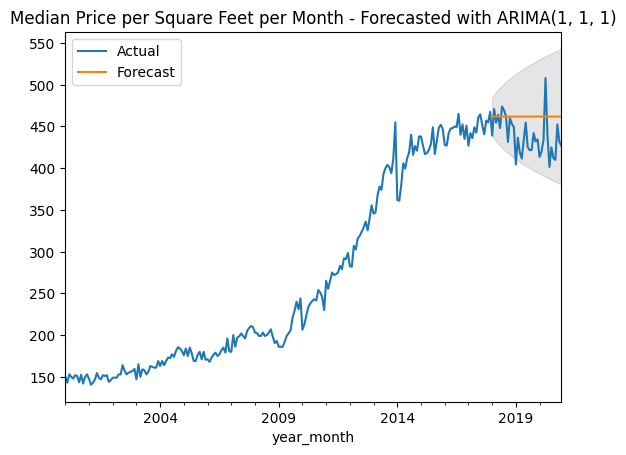

RMSE with ARIMA(1, 1, 2): 32.42784877289636


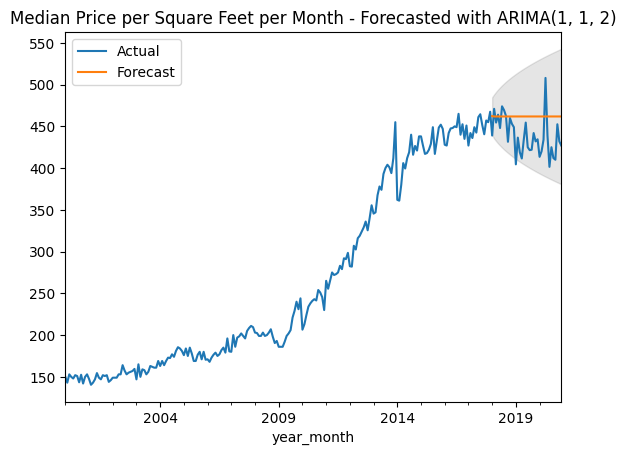

RMSE with ARIMA(2, 2, 1): 68.82649494573607


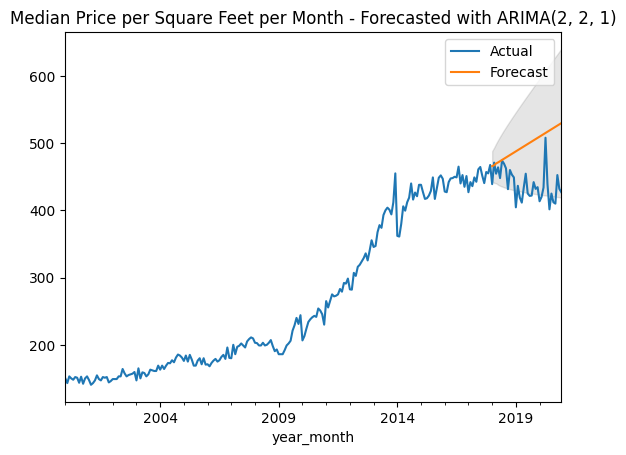

RMSE with ARIMA(2, 1, 1): 32.481083515891896


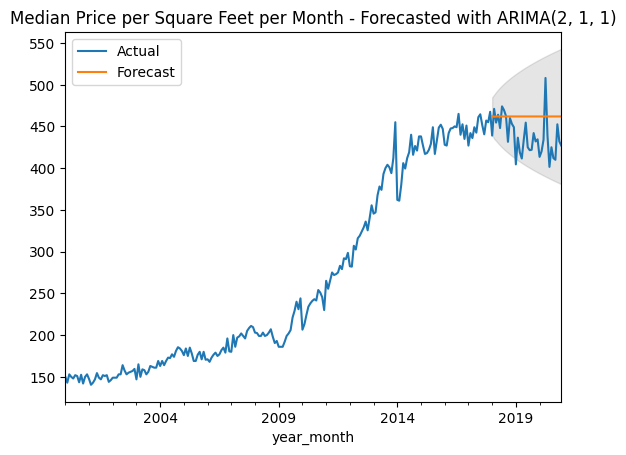

In [88]:
best_orders = [f'({order})' for order in df_top_10_arima_eval['model'].str.extract(r'\((\d+, \d+, \d+)\)', expand=False)][:5]
forecast_length = 12 * 3

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plot_train_set_median_forecast(ARIMA, median_monthly_price_psf_train['price_psf'], literal_eval(best_order), forecast_length)

- ARIMA(2, 1, 2), ARIMA(3, 1, 1) and ARIMA(1, 2, 1) forecasted a slightly flat trend, aligns with the actual values.
- ARIMA(7, 2, 2) forecasted somewhat upward trend. However, the actual values are somewhat flat.

It seems that ARIMA(2, 1, 2) is the best model for median `price_psf``, followed by ARIMA(3, 1, 1).

### SARIMA on median `price_psf`

In [89]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
models, mse, rmse, mae, mape, r2, me, rmsle, mpd, mgd, aic, bic = [], [], [], [], [], [], [], [], [], [], [], []

for order in tqdm(orders, total=len(orders)):
    for fold, (train, test) in enumerate(block_cv(median_monthly_price_psf_train['price_psf'], n_splits=2)):
        fold_mse, fold_rmse, fold_mae, fold_mape, fold_r2, fold_me, fold_rmsle, fold_mpd, fold_mgd, fold_aic, fold_bic = [], [], [], [], [], [], [], [], [], [], []
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                sarima = SARIMAX(train, order=order, freq=train.index.inferred_freq).fit()
                sarima_forecast = sarima.forecast(len(test))
                results = evaluate_model(val, sarima_forecast)
                fold_mse.append(results['mse'])
                fold_rmse.append(results['rmse'])
                fold_mae.append(results['mae'])
                fold_mape.append(results['mape'])
                fold_r2.append(results['r2'])
                fold_me.append(results['me'])
                fold_rmsle.append(results['rmsle'])
                fold_mpd.append(results['mpd'])
                fold_mgd.append(results['mgd'])
                fold_aic.append(sarima.aic)
                fold_bic.append(sarima.bic)
            except:
                fold_mse.append(np.nan)
                fold_rmse.append(np.nan)
                fold_mae.append(np.nan)
                fold_mape.append(np.nan)
                fold_r2.append(np.nan)
                fold_me.append(np.nan)
                fold_rmsle.append(np.nan)
                fold_mpd.append(np.nan)
                fold_mgd.append(np.nan)
                fold_aic.append(np.nan)
                fold_bic.append(np.nan)

    models.append(f'SARIMAX {order}')
    mse.append(mean(fold_mse))
    rmse.append(mean(fold_rmse))
    mae.append(mean(fold_mae))
    mape.append(mean(fold_mape))
    r2.append(mean(fold_r2))
    me.append(mean(fold_me))
    rmsle.append(mean(fold_rmsle))
    mpd.append(mean(fold_mpd))
    mgd.append(mean(fold_mgd))
    aic.append(mean(fold_aic))
    bic.append(mean(fold_bic))

df_sarima_eval = pd.DataFrame({'model': models, 'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2, 'me': me, 'rmsle': rmsle, 'mpd': mpd, 'mgd': mgd, 'aic': aic, 'bic': bic})
df_top_10_sarima_eval = df_sarima_eval.sort_values(by=['rmse'], ascending=True).head(10)
df_top_10_sarima_eval

100%|██████████| 28/28 [00:11<00:00,  2.41it/s]


model         mse       rmse        mae      mape        r2  \
5   SARIMAX (2, 1, 2)  195.612067  13.986138  12.515858  0.029147  0.014721   
0   SARIMAX (1, 1, 1)  198.903755  14.103324  10.667647  0.024982 -0.001859   
1   SARIMAX (1, 1, 2)  206.327485  14.364104  11.021327  0.025862 -0.039251   
6   SARIMAX (2, 2, 1)  229.117939  15.136642  12.703918  0.029880 -0.154045   
4   SARIMAX (2, 1, 1)  295.005168  17.175714  14.139231  0.033427 -0.485912   
2   SARIMAX (1, 2, 1)  365.518962  19.118550  14.232574  0.032458 -0.841083   
9   SARIMAX (3, 1, 2)  564.421995  23.757567  19.589676  0.046379 -1.842938   
7   SARIMAX (2, 2, 2)  592.886152  24.349254  20.498529  0.047185 -1.986310   
8   SARIMAX (3, 1, 1)  609.164305  24.681254  19.584806  0.046251 -2.068301   
12  SARIMAX (4, 1, 1)  623.411954  24.968219  21.512507  0.050943 -2.140065   

           me     rmsle       mpd       mgd          aic          bic  
5   23.144528  0.032507  0.457180  0.001069  1032.344450  1046.240068  
0   23.721316  0.032780  0.463450  0.001080  1035.032863  1043.370234  
1   23.034162  0.033421  0.480755  0.001121  1036.609841  1047.726335  
6   21.969267  0.035201  0.532643  0.001239  1036.918225  1048.000964  
4   26.840270  0.040025  0.685154  0.001592  1034.749081  1045.865575  
2   39.566822  0.044443  0.862302  0.002035  1043.123789  1051.435843  
9   45.695971  0.054714  1.288088  0.002941  1022.280368  1038.955109  
7   41.586289  0.057455  1.420222  0.003404  1041.014831  1054.868254  
8   47.912232  0.056677  1.386936  0.003160  1021.387193  1035.282810  
12  45.961210  0.057561  1.424401  0.003257  1021.333470  1038.008211

In [90]:
df_sarima_eval = rank_models(df_sarima_eval, metrics)

df_sarima_eval['rank_mean'] = df_sarima_eval[[col for col in df_sarima_eval.columns if col.startswith('rank_')]].mean(axis=1)
df_top_10_sarima_eval = df_sarima_eval.sort_values(by=['rank_mean']).head(10)
df_top_10_sarima_eval

model         mse       rmse        mae      mape        r2  \
5   SARIMAX (2, 1, 2)  195.612067  13.986138  12.515858  0.029147  0.014721   
0   SARIMAX (1, 1, 1)  198.903755  14.103324  10.667647  0.024982 -0.001859   
1   SARIMAX (1, 1, 2)  206.327485  14.364104  11.021327  0.025862 -0.039251   
6   SARIMAX (2, 2, 1)  229.117939  15.136642  12.703918  0.029880 -0.154045   
4   SARIMAX (2, 1, 1)  295.005168  17.175714  14.139231  0.033427 -0.485912   
2   SARIMAX (1, 2, 1)  365.518962  19.118550  14.232574  0.032458 -0.841083   
9   SARIMAX (3, 1, 2)  564.421995  23.757567  19.589676  0.046379 -1.842938   
8   SARIMAX (3, 1, 1)  609.164305  24.681254  19.584806  0.046251 -2.068301   
7   SARIMAX (2, 2, 2)  592.886152  24.349254  20.498529  0.047185 -1.986310   
18  SARIMAX (5, 2, 1)  633.889541  25.177163  20.276395  0.048160 -2.192840   

           me     rmsle       mpd       mgd  ...  rank_mse  rank_rmse  \
5   23.144528  0.032507  0.457180  0.001069  ...       1.0        1.0   
0   23.721316  0.032780  0.463450  0.001080  ...       2.0        2.0   
1   23.034162  0.033421  0.480755  0.001121  ...       3.0        3.0   
6   21.969267  0.035201  0.532643  0.001239  ...       4.0        4.0   
4   26.840270  0.040025  0.685154  0.001592  ...       5.0        5.0   
2   39.566822  0.044443  0.862302  0.002035  ...       6.0        6.0   
9   45.695971  0.054714  1.288088  0.002941  ...       7.0        7.0   
8   47.912232  0.056677  1.386936  0.003160  ...       9.0        9.0   
7   41.586289  0.057455  1.420222  0.003404  ...       8.0        8.0   
18  47.568610  0.057973  1.444488  0.003294  ...      11.0       11.0   

    rank_mae  rank_mape  rank_r2  rank_me  rank_rmsle  rank_mpd  rank_mgd  \
5        3.0        3.0      1.0      3.0         1.0       1.0       1.0   
0        1.0        1.0      2.0      4.0         2.0       2.0       2.0   
1        2.0        2.0      3.0      2.0         3.0       3.0       3.0   
6        4.0        4.0      4.0      1.0         4.0       4.0       4.0   
4        5.0        6.0      5.0      5.0         5.0       5.0       5.0   
2        6.0        5.0      6.0      6.0         6.0       6.0       6.0   
9        8.0        8.0      7.0      8.0         7.0       7.0       7.0   
8        7.0        7.0      9.0     12.0         8.0       8.0       8.0   
7       11.0        9.0      8.0      7.0         9.0       9.0      12.0   
18       9.0       10.0     11.0     11.0        11.0      11.0      10.0   

    rank_mean  
5    1.666667  
0    2.000000  
1    2.666667  
6    3.666667  
4    5.111111  
2    5.888889  
9    7.333333  
8    8.555556  
7    9.000000  
18  10.555556  

[10 rows x 22 columns]

The best order inferred from the grid search is (2, 1, 2), which is different from the order suggested by ACF and PACF plots. This is similar to ARIMA.

RMSE with SARIMAX(2, 1, 2): 31.978924758830107


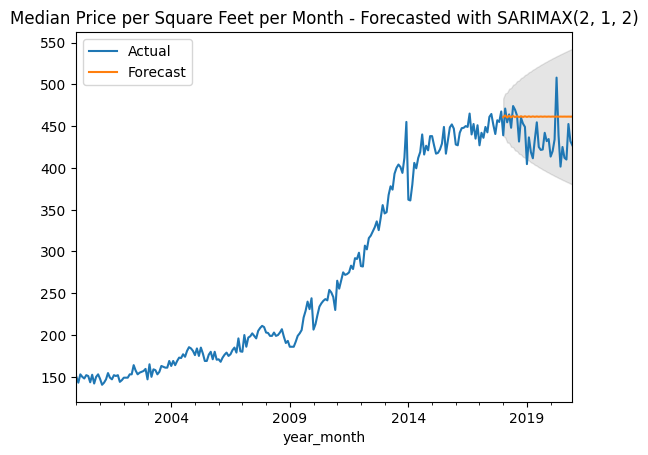

RMSE with SARIMAX(1, 1, 1): 32.43227009620376


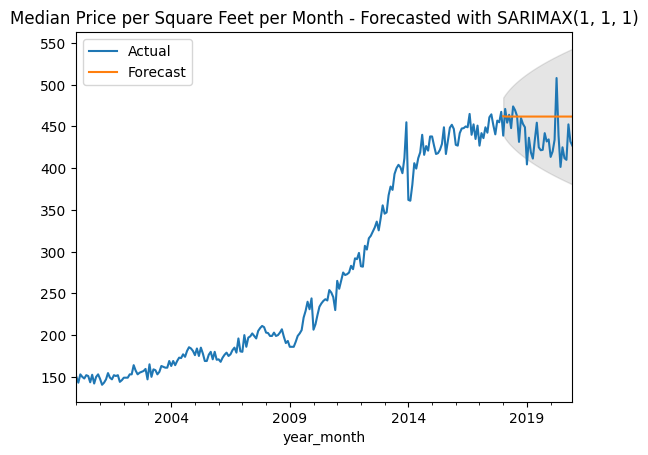

RMSE with SARIMAX(1, 1, 2): 32.42784877289636


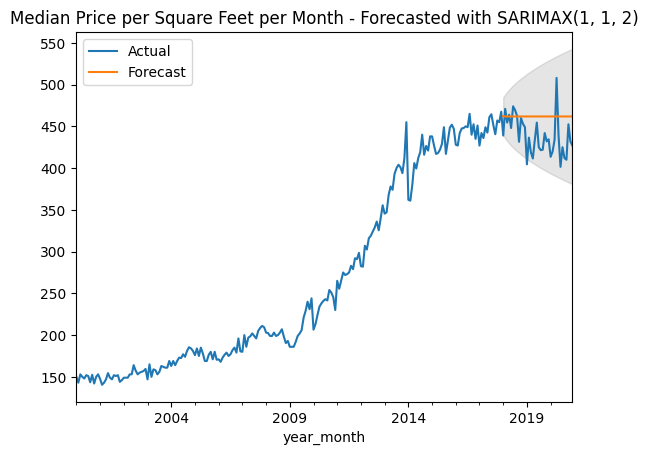

RMSE with SARIMAX(2, 2, 1): 68.82649494573607


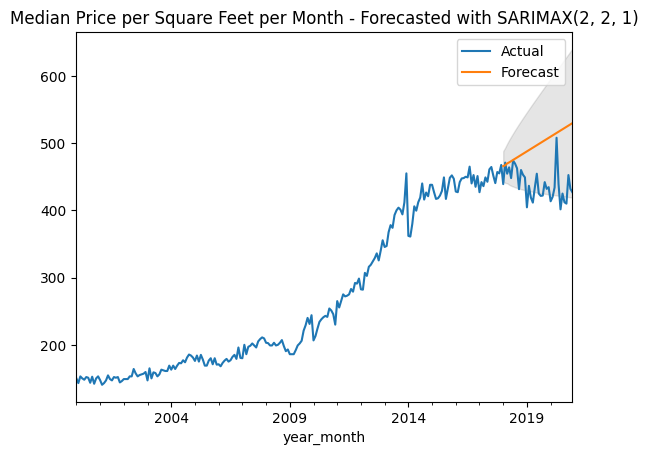

RMSE with SARIMAX(2, 1, 1): 32.481083515891896


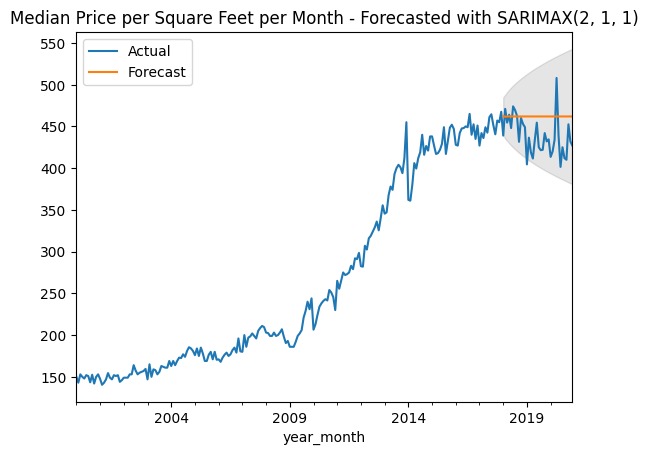

In [91]:
best_orders = best_orders = [f'({order})' for order in df_top_10_sarima_eval['model'].str.extract(r'\((\d+, \d+, \d+)\)', expand=False)][:5]
forecast_length = 12 * 3

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plot_train_set_median_forecast(SARIMAX, median_monthly_price_psf_train['price_psf'], literal_eval(best_order), forecast_length)

From the plots above, similar to ARIMA, SARIMA(2, 1, 2) is the best model.

### Holt's exponential smoothing on mean `price_psf`

In [92]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

models, mse, rmse, mae, mape, r2, me, rmsle, mpd, mgd, aic, bic = [], [], [], [], [], [], [], [], [], [], [], []
periods = range(1,13)
for period in tqdm(periods, total=len(periods)):
    for fold, (train, test) in enumerate(block_cv(median_monthly_price_psf_train['price_psf'], n_splits=2)):
        fold_mse, fold_rmse, fold_mae, fold_mape, fold_r2, fold_me, fold_rmsle, fold_mpd, fold_mgd, fold_aic, fold_bic = [], [], [], [], [], [], [], [], [], [], []
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                holt = ETSModel(
                    train, 
                    error='add', 
                    trend='mul', 
                    seasonal='mul', 
                    freq=train.index.inferred_freq, 
                    seasonal_periods=period, 
                    damped_trend=True
                ).fit()
                holt_forecast = holt.forecast(len(test))
                results = evaluate_model(val, holt_forecast)
                fold_mse.append(results['mse'])
                fold_rmse.append(results['rmse'])
                fold_mae.append(results['mae'])
                fold_mape.append(results['mape'])
                fold_r2.append(results['r2'])
                fold_me.append(results['me'])
                fold_rmsle.append(results['rmsle'])
                fold_mpd.append(results['mpd'])
                fold_mgd.append(results['mgd'])
                fold_aic.append(holt.aic)
                fold_bic.append(holt.bic)
            except:
                fold_mse.append(np.nan)
                fold_rmse.append(np.nan)
                fold_mae.append(np.nan)
                fold_mape.append(np.nan)
                fold_r2.append(np.nan)
                fold_me.append(np.nan)
                fold_rmsle.append(np.nan)
                fold_mpd.append(np.nan)
                fold_mgd.append(np.nan)
                fold_aic.append(np.nan)
                fold_bic.append(np.nan)

    models.append(f'Holt (p={period})')
    mse.append(mean(fold_mse))
    rmse.append(mean(fold_rmse))
    mae.append(mean(fold_mae))
    mape.append(mean(fold_mape))
    r2.append(mean(fold_r2))
    me.append(mean(fold_me))
    rmsle.append(mean(fold_rmsle))
    mpd.append(mean(fold_mpd))
    mgd.append(mean(fold_mgd))
    aic.append(mean(fold_aic))
    bic.append(mean(fold_bic))

df_holt_eval = pd.DataFrame({'model': models, 'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2, 'me': me, 'rmsle': rmsle, 'mpd': mpd, 'mgd': mgd, 'aic': aic, 'bic': bic})
df_top_10_holt_eval = df_holt_eval.sort_values(by=['rmse'], ascending=True).head(10)
df_top_10_holt_eval

100%|██████████| 12/12 [00:01<00:00,  7.82it/s]


model         mse       rmse        mae      mape        r2  \
5    Holt (p=6)  164.644582  12.831390  10.930475  0.025834  0.170701   
10  Holt (p=11)  218.007756  14.765086  11.663975  0.027463 -0.098084   
9   Holt (p=10)  243.420457  15.601938  13.041888  0.030920 -0.226085   
1    Holt (p=2)  248.773420  15.772553  13.182743  0.031287 -0.253047   
2    Holt (p=3)  278.605658  16.691485  14.730725  0.034902 -0.403309   
8    Holt (p=9)  288.546174  16.986647  14.474922  0.034143 -0.453379   
6    Holt (p=7)  298.377269  17.273600  16.066989  0.037876 -0.502897   
7    Holt (p=8)  314.089763  17.722578  15.589729  0.036799 -0.582039   
4    Holt (p=5)  320.605379  17.905457  15.578102  0.036931 -0.614858   
3    Holt (p=4)  329.144006  18.142326  16.326089  0.038577 -0.657866   

           me     rmsle       mpd       mgd          aic          bic  
5   18.111150  0.029986  0.383800  0.000895  1037.444718  1073.682111  
10  21.152983  0.034410  0.507835  0.001183  1043.964350  1094.139201  
9   28.666720  0.036404  0.565060  0.001312  1048.479115  1095.866475  
1   26.122962  0.036861  0.578550  0.001346  1035.946544  1061.033970  
2   26.486936  0.038981  0.647709  0.001506  1044.069229  1071.944146  
8   26.914494  0.039571  0.670621  0.001559  1050.124916  1094.724784  
6   23.515078  0.040217  0.692843  0.001609  1048.846048  1087.870933  
7   31.486449  0.041113  0.725083  0.001674  1038.403451  1080.215828  
4   26.985100  0.041765  0.743975  0.001727  1047.613951  1081.063852  
3   30.949232  0.042125  0.760356  0.001757  1030.658559  1061.320968

In [93]:
df_holt_eval = rank_models(df_holt_eval, metrics)

df_holt_eval['rank_mean'] = df_holt_eval[[col for col in df_holt_eval.columns if col.startswith('rank_')]].mean(axis=1)
df_top_10_holt_eval = df_holt_eval.sort_values(by=['rank_mean']).head(10)
df_top_10_holt_eval

model         mse       rmse        mae      mape        r2  \
5    Holt (p=6)  164.644582  12.831390  10.930475  0.025834  0.170701   
10  Holt (p=11)  218.007756  14.765086  11.663975  0.027463 -0.098084   
9   Holt (p=10)  243.420457  15.601938  13.041888  0.030920 -0.226085   
1    Holt (p=2)  248.773420  15.772553  13.182743  0.031287 -0.253047   
2    Holt (p=3)  278.605658  16.691485  14.730725  0.034902 -0.403309   
8    Holt (p=9)  288.546174  16.986647  14.474922  0.034143 -0.453379   
6    Holt (p=7)  298.377269  17.273600  16.066989  0.037876 -0.502897   
7    Holt (p=8)  314.089763  17.722578  15.589729  0.036799 -0.582039   
4    Holt (p=5)  320.605379  17.905457  15.578102  0.036931 -0.614858   
3    Holt (p=4)  329.144006  18.142326  16.326089  0.038577 -0.657866   

           me     rmsle       mpd       mgd  ...  rank_mse  rank_rmse  \
5   18.111150  0.029986  0.383800  0.000895  ...       1.0        1.0   
10  21.152983  0.034410  0.507835  0.001183  ...       2.0        2.0   
9   28.666720  0.036404  0.565060  0.001312  ...       3.0        3.0   
1   26.122962  0.036861  0.578550  0.001346  ...       4.0        4.0   
2   26.486936  0.038981  0.647709  0.001506  ...       5.0        5.0   
8   26.914494  0.039571  0.670621  0.001559  ...       6.0        6.0   
6   23.515078  0.040217  0.692843  0.001609  ...       7.0        7.0   
7   31.486449  0.041113  0.725083  0.001674  ...       8.0        8.0   
4   26.985100  0.041765  0.743975  0.001727  ...       9.0        9.0   
3   30.949232  0.042125  0.760356  0.001757  ...      10.0       10.0   

    rank_mae  rank_mape  rank_r2  rank_me  rank_rmsle  rank_mpd  rank_mgd  \
5        1.0        1.0      1.0      1.0         1.0       1.0       1.0   
10       2.0        2.0      2.0      2.0         2.0       2.0       2.0   
9        3.0        3.0      3.0      9.0         3.0       3.0       3.0   
1        4.0        4.0      4.0      4.0         4.0       4.0       4.0   
2        6.0        6.0      5.0      5.0         5.0       5.0       5.0   
8        5.0        5.0      6.0      6.0         6.0       6.0       6.0   
6        9.0        9.0      7.0      3.0         7.0       7.0       7.0   
7        8.0        7.0      8.0     11.0         8.0       8.0       8.0   
4        7.0        8.0      9.0      7.0         9.0       9.0       9.0   
3       10.0       10.0     10.0     10.0        10.0      10.0      10.0   

    rank_mean  
5    1.000000  
10   2.000000  
9    3.666667  
1    4.000000  
2    5.222222  
8    5.777778  
6    7.000000  
7    8.222222  
4    8.444444  
3   10.000000  

[10 rows x 22 columns]

Holt-Winter's exponential smoothing has lowest MAE and RMSE when period is 6.

In [94]:
def plot_train_set_median_forecast_holt(train_data, period, forecast_length=12, verbose=False):

    train = train_data.iloc[:-forecast_length]
    val = train_data.iloc[-forecast_length:]

    holt = ETSModel(
        train, 
        error='add', 
        trend='mul', 
        seasonal='mul', 
        freq=train.index.inferred_freq, 
        seasonal_periods=period, 
        damped_trend=True
    ).fit()
    holt_forecast = holt.forecast(forecast_length)
    if verbose:
        print(holt.summary())
    print(f'RMSE with Holt(p={period}): {mean_squared_error(val, holt_forecast, squared=False)}')

    median_monthly_price_psf_train.plot(
        kind='line',
        title='Median Price per Square Feet per Month - Forecasted with Holt',
    )
    holt_forecast.plot(
        kind='line',
    )
    plt.legend(['Actual', 'Forecast'])
    plt.show()

RMSE with Holt(p=6): 40.42117215591539


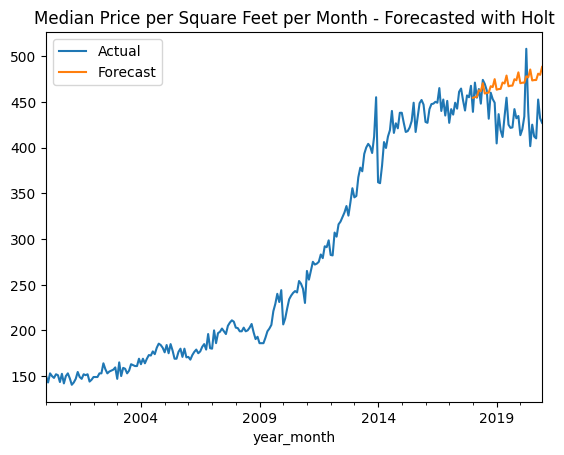

RMSE with Holt(p=11): 49.91949553957683


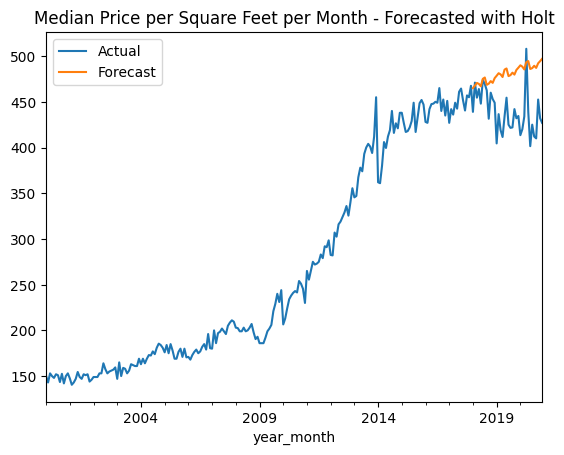

RMSE with Holt(p=10): 45.698720480308765


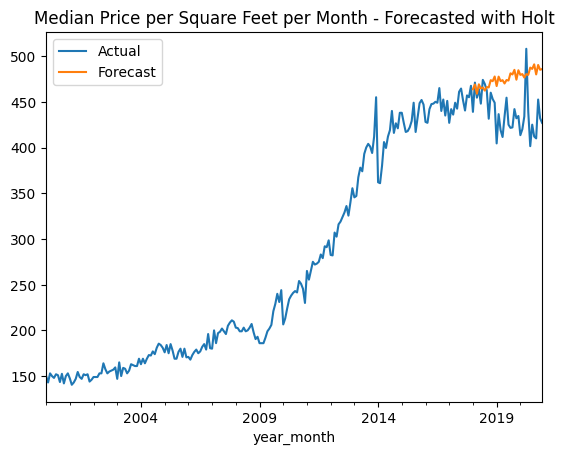

RMSE with Holt(p=2): 44.961916834701896


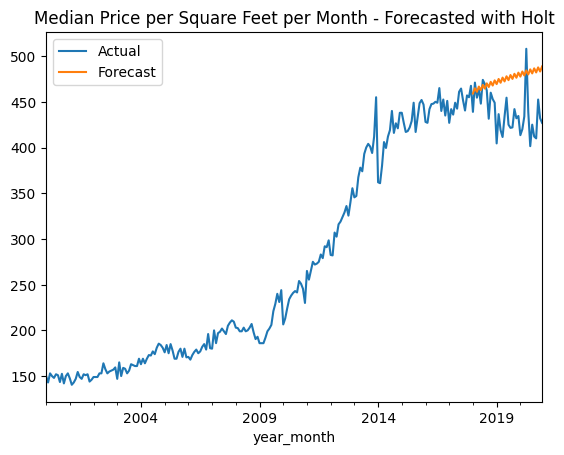

RMSE with Holt(p=3): 45.22594665868692


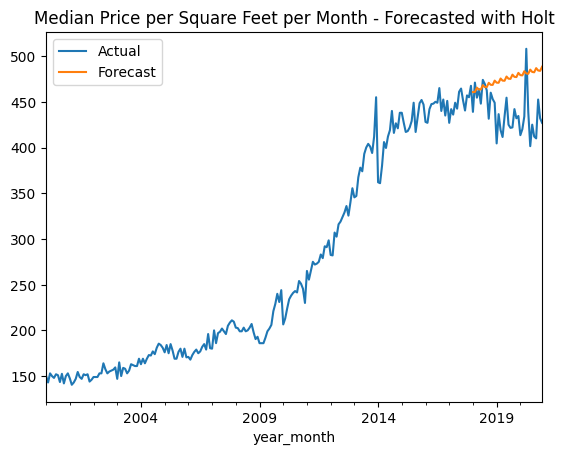

In [95]:
best_period = [period for period in df_top_10_holt_eval['model'].str.extract(r'\(p=(\d+)\)', expand=False)][:5]
forecast_length = 36

for period in best_period:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plot_train_set_median_forecast_holt(median_monthly_price_psf_train['price_psf'], literal_eval(period), forecast_length)

Unfortunately `ETSModel` does not support prediction intervals like `ARIMA` and `SARIMAX`. However, the best model for Holt has higher RMSE than best model of ARIMA/SARIMAX.

Let's evaluate on test set.

In [96]:
df_median_price_psf_train_results = pd.concat([df_top_10_arima_eval[:5], df_top_10_sarima_eval[:5], df_top_10_holt_eval[:5]]).reset_index(drop=True)
df_median_price_psf_train_results = rank_models(df_median_price_psf_train_results, metrics)
df_median_price_psf_train_results['rank_mean'] = df_median_price_psf_train_results[[col for col in df_median_price_psf_train_results.columns if col.startswith('rank_')]].mean(axis=1)
df_median_price_psf_train_results

model         mse       rmse        mae      mape        r2  \
0     ARIMA (2, 1, 2)  195.612067  13.986138  12.515858  0.029147  0.014721   
1     ARIMA (1, 1, 1)  198.903755  14.103324  10.667647  0.024982 -0.001859   
2     ARIMA (1, 1, 2)  206.327485  14.364104  11.021327  0.025862 -0.039251   
3     ARIMA (2, 2, 1)  229.117939  15.136642  12.703918  0.029880 -0.154045   
4     ARIMA (2, 1, 1)  295.005168  17.175714  14.139231  0.033427 -0.485912   
5   SARIMAX (2, 1, 2)  195.612067  13.986138  12.515858  0.029147  0.014721   
6   SARIMAX (1, 1, 1)  198.903755  14.103324  10.667647  0.024982 -0.001859   
7   SARIMAX (1, 1, 2)  206.327485  14.364104  11.021327  0.025862 -0.039251   
8   SARIMAX (2, 2, 1)  229.117939  15.136642  12.703918  0.029880 -0.154045   
9   SARIMAX (2, 1, 1)  295.005168  17.175714  14.139231  0.033427 -0.485912   
10         Holt (p=6)  164.644582  12.831390  10.930475  0.025834  0.170701   
11        Holt (p=11)  218.007756  14.765086  11.663975  0.027463 -0.098084   
12        Holt (p=10)  243.420457  15.601938  13.041888  0.030920 -0.226085   
13         Holt (p=2)  248.773420  15.772553  13.182743  0.031287 -0.253047   
14         Holt (p=3)  278.605658  16.691485  14.730725  0.034902 -0.403309   

           me     rmsle       mpd       mgd  ...  rank_mse  rank_rmse  \
0   23.144528  0.032507  0.457180  0.001069  ...       2.5        2.5   
1   23.721316  0.032780  0.463450  0.001080  ...       4.5        4.5   
2   23.034162  0.033421  0.480755  0.001121  ...       6.5        6.5   
3   21.969267  0.035201  0.532643  0.001239  ...       9.5        9.5   
4   26.840270  0.040025  0.685154  0.001592  ...      14.5       14.5   
5   23.144528  0.032507  0.457180  0.001069  ...       2.5        2.5   
6   23.721316  0.032780  0.463450  0.001080  ...       4.5        4.5   
7   23.034162  0.033421  0.480755  0.001121  ...       6.5        6.5   
8   21.969267  0.035201  0.532643  0.001239  ...       9.5        9.5   
9   26.840270  0.040025  0.685154  0.001592  ...      14.5       14.5   
10  18.111150  0.029986  0.383800  0.000895  ...       1.0        1.0   
11  21.152983  0.034410  0.507835  0.001183  ...       8.0        8.0   
12  28.666720  0.036404  0.565060  0.001312  ...      11.0       11.0   
13  26.122962  0.036861  0.578550  0.001346  ...      12.0       12.0   
14  26.486936  0.038981  0.647709  0.001506  ...      13.0       13.0   

    rank_mae  rank_mape  rank_r2  rank_me  rank_rmsle  rank_mpd  rank_mgd  \
0        7.5        7.5      2.5      7.5         2.5       2.5       2.5   
1        1.5        1.5      4.5      9.5         4.5       4.5       4.5   
2        4.5        4.5      6.5      5.5         6.5       6.5       6.5   
3        9.5        9.5      9.5      3.5         9.5       9.5       9.5   
4       13.5       13.5     14.5     13.5        14.5      14.5      14.5   
5        7.5        7.5      2.5      7.5         2.5       2.5       2.5   
6        1.5        1.5      4.5      9.5         4.5       4.5       4.5   
7        4.5        4.5      6.5      5.5         6.5       6.5       6.5   
8        9.5        9.5      9.5      3.5         9.5       9.5       9.5   
9       13.5       13.5     14.5     13.5        14.5      14.5      14.5   
10       3.0        3.0      1.0      1.0         1.0       1.0       1.0   
11       6.0        6.0      8.0      2.0         8.0       8.0       8.0   
12      11.0       11.0     11.0     15.0        11.0      11.0      11.0   
13      12.0       12.0     12.0     11.0        12.0      12.0      12.0   
14      15.0       15.0     13.0     12.0        13.0      13.0      13.0   

    rank_mean  
0    3.916667  
1    4.150000  
2    5.616667  
3    8.316667  
4   13.261111  
5    3.916667  
6    4.150000  
7    5.616667  
8    8.316667  
9   13.261111  
10   1.400000  
11   6.400000  
12  10.666667  
13  11.100000  
14  12.522222  

[15 rows x 22 columns]

In [97]:
df_median_price_psf_train_metrics = df_median_price_psf_train_results[metrics].T.rename(columns=df_median_price_psf_train_results['model']).reset_index(drop=True)
df_median_price_psf_train_metrics

ARIMA (2, 1, 2)  ARIMA (1, 1, 1)  ARIMA (1, 1, 2)  ARIMA (2, 2, 1)  \
0       195.612067       198.903755       206.327485       229.117939   
1        13.986138        14.103324        14.364104        15.136642   
2        12.515858        10.667647        11.021327        12.703918   
3         0.029147         0.024982         0.025862         0.029880   
4         0.014721        -0.001859        -0.039251        -0.154045   
5        23.144528        23.721316        23.034162        21.969267   
6         0.032507         0.032780         0.033421         0.035201   
7         0.457180         0.463450         0.480755         0.532643   
8         0.001069         0.001080         0.001121         0.001239   

   ARIMA (2, 1, 1)  SARIMAX (2, 1, 2)  SARIMAX (1, 1, 1)  SARIMAX (1, 1, 2)  \
0       295.005168         195.612067         198.903755         206.327485   
1        17.175714          13.986138          14.103324          14.364104   
2        14.139231          12.515858          10.667647          11.021327   
3         0.033427           0.029147           0.024982           0.025862   
4        -0.485912           0.014721          -0.001859          -0.039251   
5        26.840270          23.144528          23.721316          23.034162   
6         0.040025           0.032507           0.032780           0.033421   
7         0.685154           0.457180           0.463450           0.480755   
8         0.001592           0.001069           0.001080           0.001121   

   SARIMAX (2, 2, 1)  SARIMAX (2, 1, 1)  Holt (p=6)  Holt (p=11)  Holt (p=10)  \
0         229.117939         295.005168  164.644582   218.007756   243.420457   
1          15.136642          17.175714   12.831390    14.765086    15.601938   
2          12.703918          14.139231   10.930475    11.663975    13.041888   
3           0.029880           0.033427    0.025834     0.027463     0.030920   
4          -0.154045          -0.485912    0.170701    -0.098084    -0.226085   
5          21.969267          26.840270   18.111150    21.152983    28.666720   
6           0.035201           0.040025    0.029986     0.034410     0.036404   
7           0.532643           0.685154    0.383800     0.507835     0.565060   
8           0.001239           0.001592    0.000895     0.001183     0.001312   

   Holt (p=2)  Holt (p=3)  
0  248.773420  278.605658  
1   15.772553   16.691485  
2   13.182743   14.730725  
3    0.031287    0.034902  
4   -0.253047   -0.403309  
5   26.122962   26.486936  
6    0.036861    0.038981  
7    0.578550    0.647709  
8    0.001346    0.001506

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

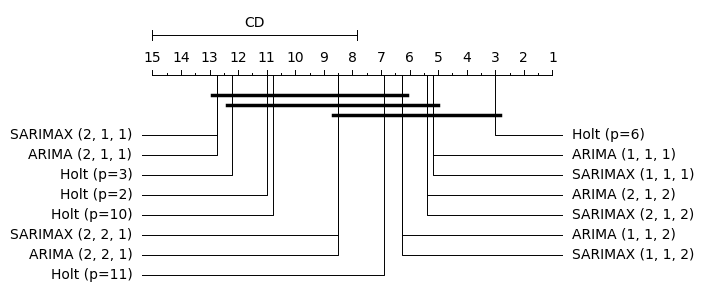

In [98]:
from autorank import autorank, plot_stats

result = autorank(df_median_price_psf_train_metrics, alpha=0.05, verbose=False, order='ascending')
plot_stats(result)
plt.show()

On train set, Holt(p=6) is statistically significant better than ARIMA/SARIMA(2, 1, 1).

In [99]:
for metric in metrics:
    rank_col = f'rank_{metric}'
    df_median_price_psf_train_results[f'{metric.upper()}'] = df_median_price_psf_train_results[metric].astype(str) + ' (' + df_median_price_psf_train_results[rank_col].astype(str) + ')'

df_median_price_psf_train_results.to_excel(REPORTS_DATA_DIR / 'median_price_psf_train_results_with_rank.xlsx', index=False)

## Evaluate models on median `price_psf` test set

In [100]:
def plot_arma_median_forecast(model, data, order, forecast_length=12, verbose=False):
    train = data.iloc[:-forecast_length]
    val = data.iloc[-forecast_length:]

    model = model(train, order=order, freq=train.index.inferred_freq)
    model_name = model.__class__.__name__

    model = model.fit()
    model_forecast = model.get_forecast(forecast_length).summary_frame()
    forecast = model_forecast['mean']
    if verbose:
        print(model.summary())
    print(f'RMSE with {model_name}{order}: {mean_squared_error(val, forecast, squared=False)}')
    result = evaluate_model(val, forecast)

    data.plot(
        kind='line',
        title=f'Median Price per Square Feet per Month (2000-2023) - Forecasted with {model_name}{order}',
    )
    forecast.plot(
        kind='line',
    )
    plt.fill_between(model_forecast.index, model_forecast['mean_ci_lower'], model_forecast['mean_ci_upper'], color='k', alpha=0.1)
    plt.legend(['Actual', 'Forecast'])
    plt.show()

    return {
        'model': f'{model_name} {str(order)}',
        **result,
    }

RMSE with ARIMA(2, 1, 2): 28.757711466829363


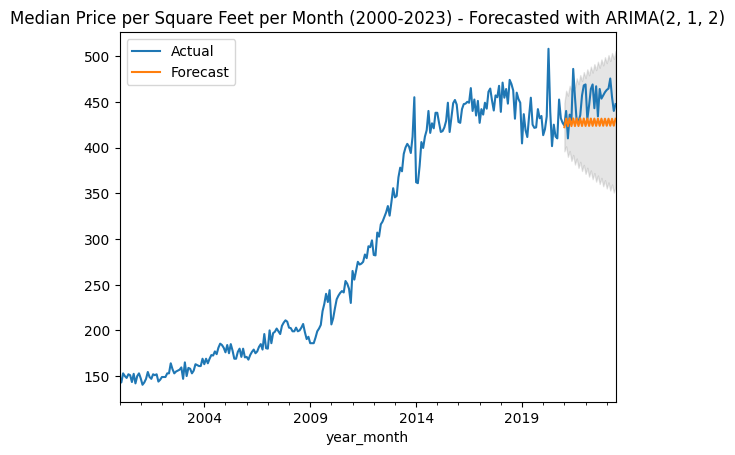

RMSE with ARIMA(1, 1, 1): 27.0093987838982


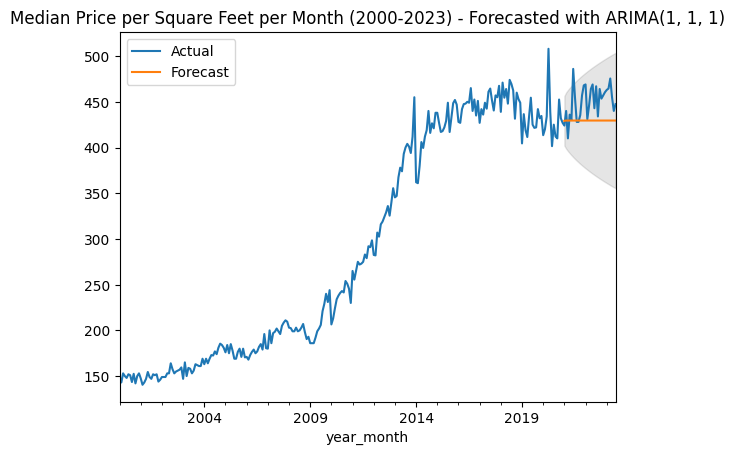

RMSE with ARIMA(1, 1, 2): 28.080987814726374


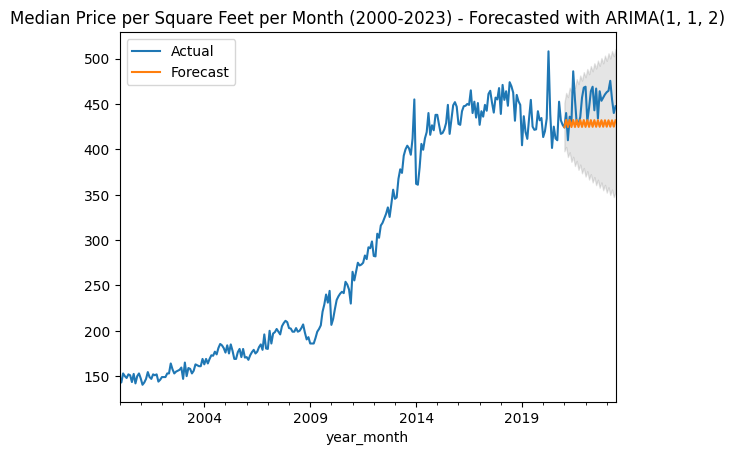

RMSE with ARIMA(2, 2, 1): 15.991703555885701


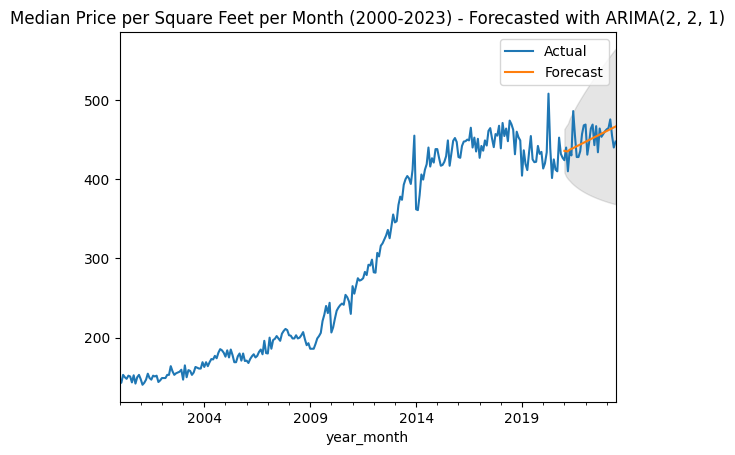

RMSE with ARIMA(2, 1, 1): 26.49044760185963


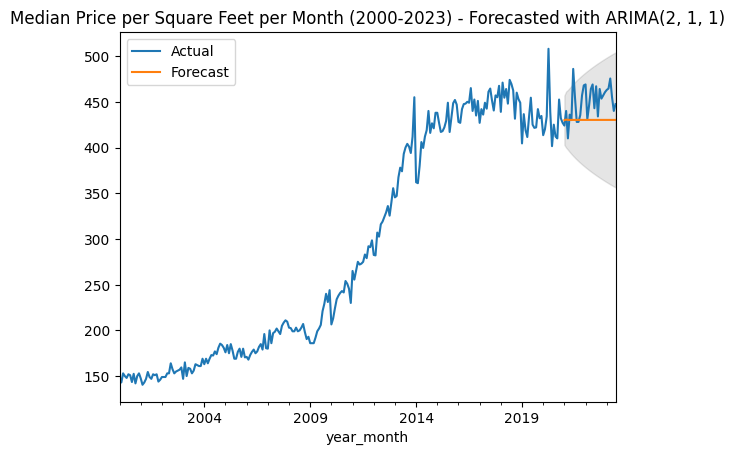

In [101]:
best_orders = [f'({order})' for order in df_top_10_arima_eval['model'].str.extract(r'\((\d+, \d+, \d+)\)', expand=False)][:5]
forecast_length = 30
arima_test_results = []

median_monthly_price_psf = monthly_price_psf['median_price_psf']

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        result = plot_arma_median_forecast(ARIMA, median_monthly_price_psf, literal_eval(best_order), forecast_length)
        arima_test_results.append(result)

When evaluating on test set, it seems ARIMA(3, 1, 1) has the lowest RMSE. ARIMA(3, 1, 1) will be chosen as the best model.

RMSE with SARIMAX(2, 1, 2): 28.757711466829363


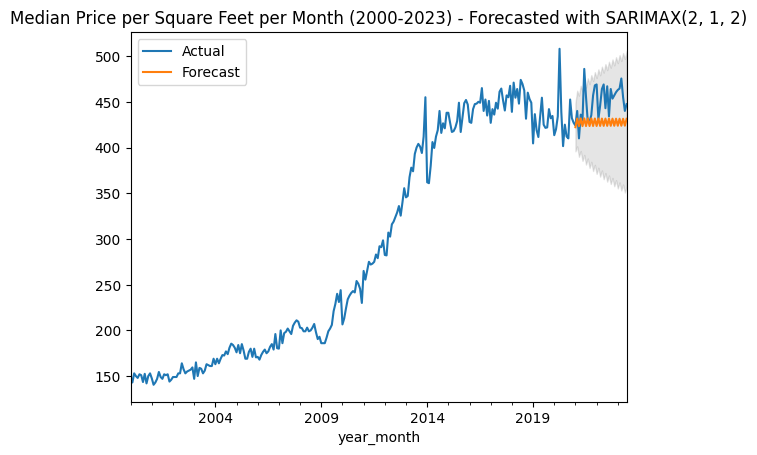

RMSE with SARIMAX(1, 1, 1): 27.0093987838982


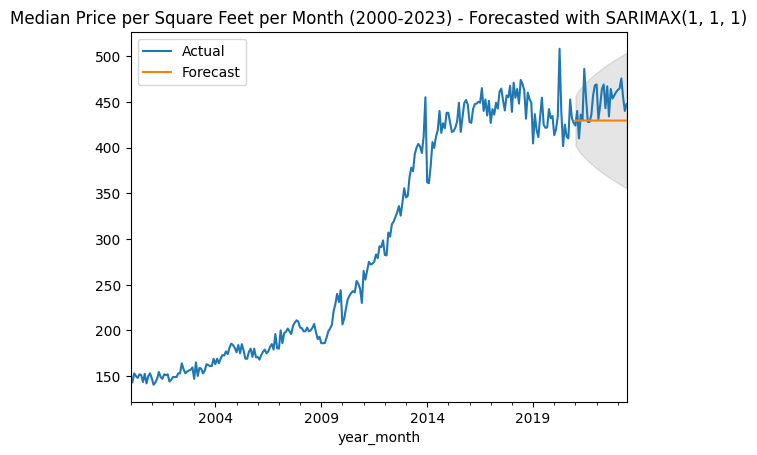

RMSE with SARIMAX(1, 1, 2): 28.080987814726374


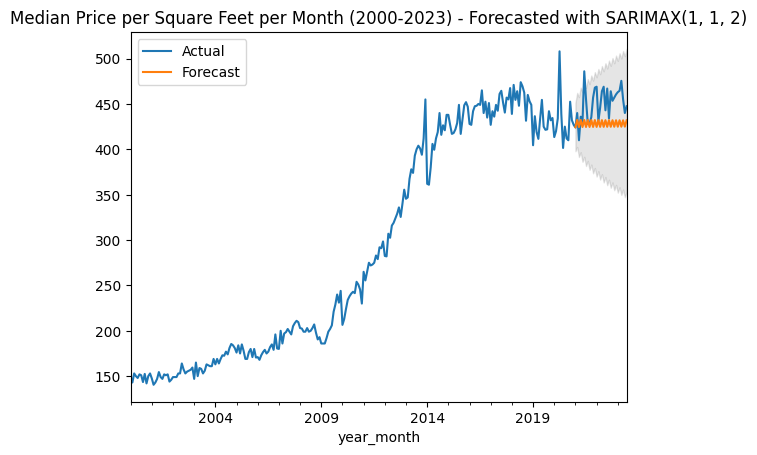

RMSE with SARIMAX(2, 2, 1): 15.991703555885701


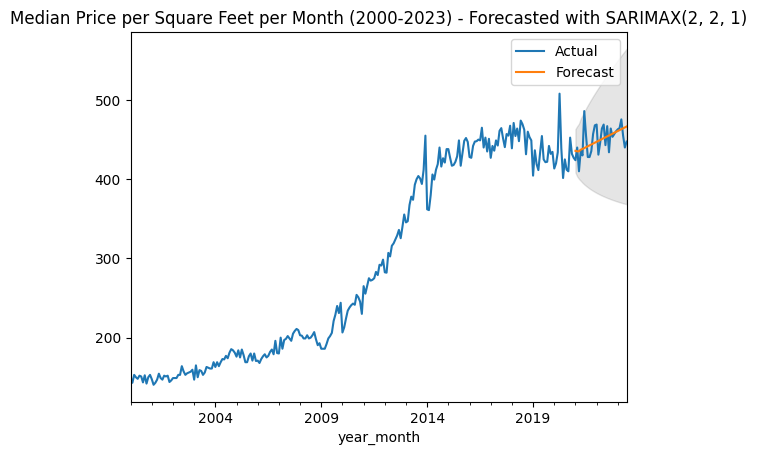

RMSE with SARIMAX(2, 1, 1): 26.49044760185963


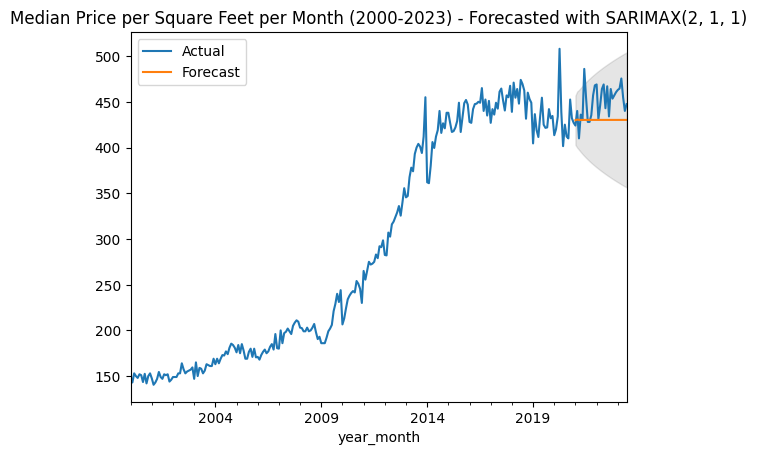

In [102]:
best_orders = [f'({order})' for order in df_top_10_sarima_eval['model'].str.extract(r'\((\d+, \d+, \d+)\)', expand=False)][:5]
sarima_test_results = []

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        result = plot_arma_median_forecast(SARIMAX, median_monthly_price_psf, literal_eval(best_order), forecast_length)
        sarima_test_results.append(result)

When evaluating on test set, it seems SARIMAX(3, 1, 1) has the lowest RMSE. SARIMAX(3, 1, 1) will be chosen as the best model.

In [103]:
def plot_holt_median_forecast(data, period, forecast_length=12, verbose=False):
    train = data.iloc[:-forecast_length]
    val = data.iloc[-forecast_length:]

    holt = ETSModel(
        train, 
        error='add', 
        trend='mul', 
        seasonal='mul', 
        freq=train.index.inferred_freq, 
        seasonal_periods=period, 
        damped_trend=True
    ).fit()
    holt_forecast = holt.forecast(forecast_length)
    if verbose:
        print(holt.summary())
    print(f'RMSE: {mean_squared_error(val, holt_forecast, squared=False)}')
    result = evaluate_model(val, holt_forecast)

    data.plot(
        kind='line',
        title='Median Price per Square Feet per Month (2000-2023) - Forecasted with Holt',
    )
    holt_forecast.plot(
        kind='line',
    )
    plt.legend(['Actual', 'Forecast'])
    plt.show()

    return {
        'model': f'Holt (p={period})',
        **result,
    }

RMSE: 32.737218158559706


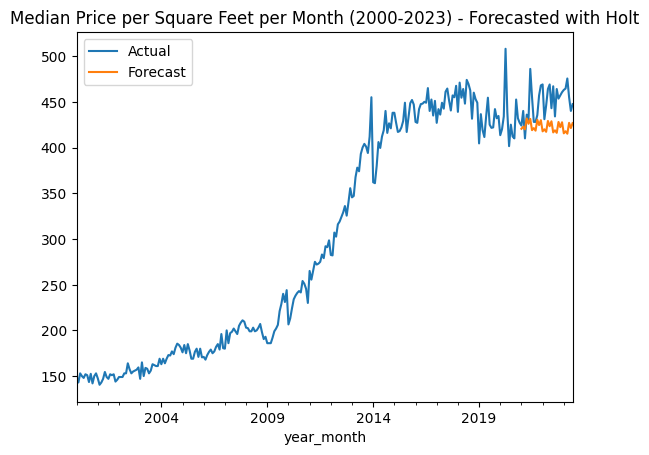

RMSE: 30.191063419087556


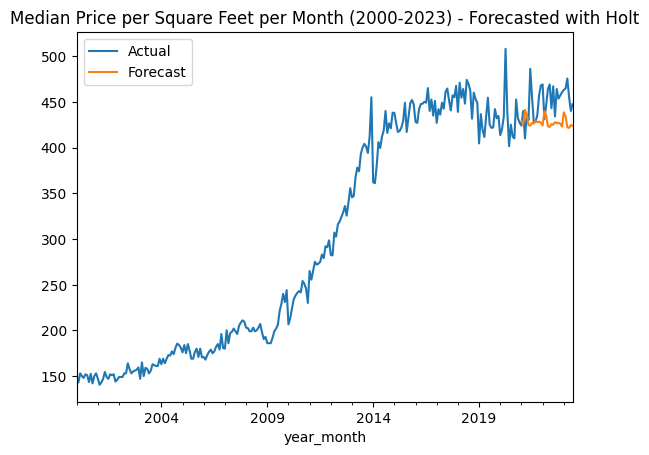

RMSE: 27.472453273521566


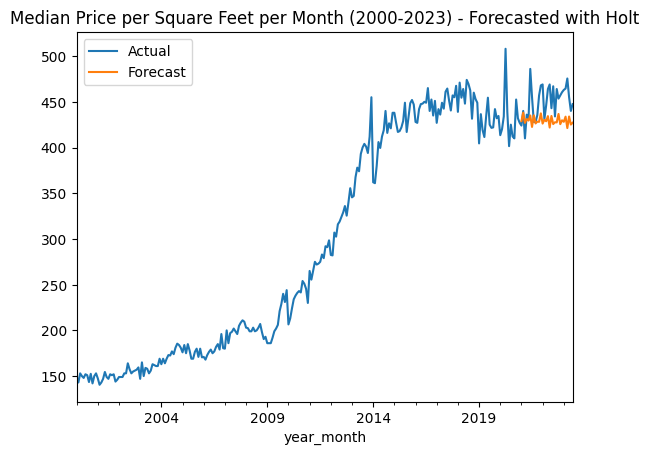

RMSE: 29.998513734580953


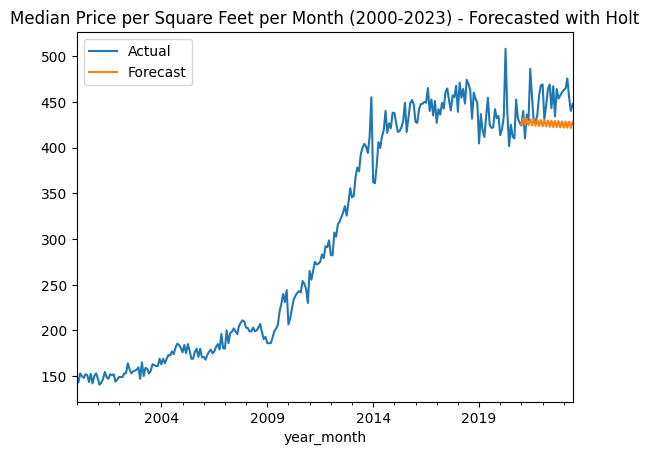

RMSE: 29.261853012786975


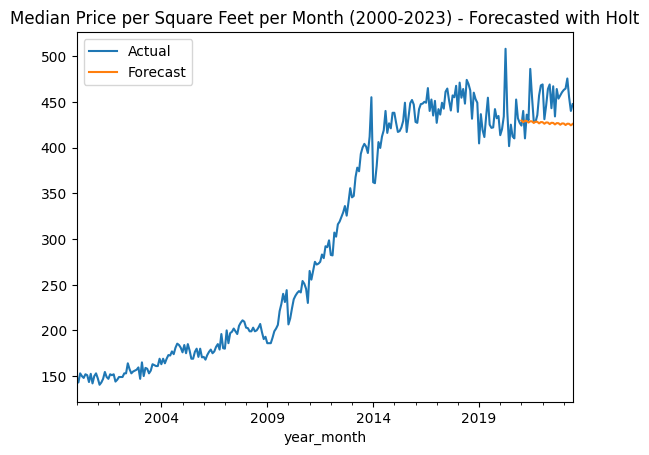

In [104]:
best_period = [period for period in df_top_10_holt_eval['model'].str.extract(r'\(p=(\d+)\)', expand=False)][:5]
holt_test_results = []

for period in best_period:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        result = plot_holt_median_forecast(median_monthly_price_psf, literal_eval(period), forecast_length)
        holt_test_results.append(result)

## Statistical evaluation on median `price_psf` test set

Similar to mean `price_psf`, We will employ three statistical tests to evaluate the performance of the models:
1. Friedman test
2. Iman-Davenport test
3. Nemenyi post-hoc test

These can be performed via the following steps as outlined in Zhan et al. (2023):
1. Ranking the performance of each algorithm according to different evaluation measures to obtain an average ranking for each algorithm;
2. Using Friedman and Iman–Davenport to test whether the algorithms all perform equally; 
3. Utilizing the Nemenyi post-hoc test to further distinguish between the algorithms.

In [105]:
median_price_psf_test_results = arima_test_results + sarima_test_results + holt_test_results

df_median_price_psf_test_results = pd.DataFrame(median_price_psf_test_results)
df_median_price_psf_test_results

model          mse       rmse        mae      mape        r2  \
0     ARIMA (2, 1, 2)   827.005969  28.757711  23.627482  0.051271 -1.678861   
1     ARIMA (1, 1, 1)   729.507623  27.009399  22.377705  0.048608 -1.363041   
2     ARIMA (1, 1, 2)   788.541877  28.080988  22.943334  0.049771 -1.554267   
3     ARIMA (2, 2, 1)   255.734583  15.991704  12.839578  0.028500  0.171617   
4     ARIMA (2, 1, 1)   701.743814  26.490448  21.879998  0.047528 -1.273108   
5   SARIMAX (2, 1, 2)   827.005969  28.757711  23.627482  0.051271 -1.678861   
6   SARIMAX (1, 1, 1)   729.507623  27.009399  22.377705  0.048608 -1.363041   
7   SARIMAX (1, 1, 2)   788.541877  28.080988  22.943334  0.049771 -1.554267   
8   SARIMAX (2, 2, 1)   255.734583  15.991704  12.839578  0.028500  0.171617   
9   SARIMAX (2, 1, 1)   701.743814  26.490448  21.879998  0.047528 -1.273108   
10         Holt (p=6)  1071.725453  32.737218  27.882078  0.060663 -2.471563   
11        Holt (p=11)   911.500310  30.191063  25.249627  0.054991 -1.952557   
12        Holt (p=10)   754.735689  27.472453  22.439257  0.048723 -1.444761   
13         Holt (p=2)   899.910826  29.998514  24.881878  0.054024 -1.915016   
14         Holt (p=3)   856.256042  29.261853  24.751676  0.053834 -1.773608   

           me     rmsle       mpd       mgd  
0   54.130237  0.064360  1.882033  0.004286  
1   56.482073  0.060242  1.652509  0.003745  
2   53.653082  0.062770  1.791751  0.004074  
3   46.753304  0.035356  0.568238  0.001264  
4   55.794861  0.059037  1.587921  0.003595  
5   54.130237  0.064360  1.882033  0.004286  
6   56.482073  0.060242  1.652509  0.003745  
7   53.653082  0.062770  1.791751  0.004074  
8   46.753304  0.035356  0.568238  0.001264  
9   55.794861  0.059037  1.587921  0.003595  
10  60.390817  0.073802  2.461028  0.005656  
11  62.088427  0.067739  2.079169  0.004746  
12  54.204249  0.061397  1.714242  0.003896  
13  54.987239  0.067269  2.052764  0.004685  
14  57.260716  0.065521  1.948780  0.004438

### Assign rank to each model based on each evaluation metric

In [106]:
df_median_price_psf_test_results = rank_models(df_median_price_psf_test_results, metrics)
df_median_price_psf_test_results

model          mse       rmse        mae      mape        r2  \
0     ARIMA (2, 1, 2)   827.005969  28.757711  23.627482  0.051271 -1.678861   
1     ARIMA (1, 1, 1)   729.507623  27.009399  22.377705  0.048608 -1.363041   
2     ARIMA (1, 1, 2)   788.541877  28.080988  22.943334  0.049771 -1.554267   
3     ARIMA (2, 2, 1)   255.734583  15.991704  12.839578  0.028500  0.171617   
4     ARIMA (2, 1, 1)   701.743814  26.490448  21.879998  0.047528 -1.273108   
5   SARIMAX (2, 1, 2)   827.005969  28.757711  23.627482  0.051271 -1.678861   
6   SARIMAX (1, 1, 1)   729.507623  27.009399  22.377705  0.048608 -1.363041   
7   SARIMAX (1, 1, 2)   788.541877  28.080988  22.943334  0.049771 -1.554267   
8   SARIMAX (2, 2, 1)   255.734583  15.991704  12.839578  0.028500  0.171617   
9   SARIMAX (2, 1, 1)   701.743814  26.490448  21.879998  0.047528 -1.273108   
10         Holt (p=6)  1071.725453  32.737218  27.882078  0.060663 -2.471563   
11        Holt (p=11)   911.500310  30.191063  25.249627  0.054991 -1.952557   
12        Holt (p=10)   754.735689  27.472453  22.439257  0.048723 -1.444761   
13         Holt (p=2)   899.910826  29.998514  24.881878  0.054024 -1.915016   
14         Holt (p=3)   856.256042  29.261853  24.751676  0.053834 -1.773608   

           me     rmsle       mpd       mgd  rank_mse  rank_rmse  rank_mae  \
0   54.130237  0.064360  1.882033  0.004286      10.5       10.5      10.5   
1   56.482073  0.060242  1.652509  0.003745       5.5        5.5       5.5   
2   53.653082  0.062770  1.791751  0.004074       8.5        8.5       8.5   
3   46.753304  0.035356  0.568238  0.001264       1.5        1.5       1.5   
4   55.794861  0.059037  1.587921  0.003595       3.5        3.5       3.5   
5   54.130237  0.064360  1.882033  0.004286      10.5       10.5      10.5   
6   56.482073  0.060242  1.652509  0.003745       5.5        5.5       5.5   
7   53.653082  0.062770  1.791751  0.004074       8.5        8.5       8.5   
8   46.753304  0.035356  0.568238  0.001264       1.5        1.5       1.5   
9   55.794861  0.059037  1.587921  0.003595       3.5        3.5       3.5   
10  60.390817  0.073802  2.461028  0.005656      15.0       15.0      15.0   
11  62.088427  0.067739  2.079169  0.004746      14.0       14.0      14.0   
12  54.204249  0.061397  1.714242  0.003896       7.0        7.0       7.0   
13  54.987239  0.067269  2.052764  0.004685      13.0       13.0      13.0   
14  57.260716  0.065521  1.948780  0.004438      12.0       12.0      12.0   

    rank_mape  rank_r2  rank_me  rank_rmsle  rank_mpd  rank_mgd  
0        10.5     10.5      5.5        10.5      10.5      10.5  
1         5.5      5.5     11.5         5.5       5.5       5.5  
2         8.5      8.5      3.5         8.5       8.5       8.5  
3         1.5      1.5      1.5         1.5       1.5       1.5  
4         3.5      3.5      9.5         3.5       3.5       3.5  
5        10.5     10.5      5.5        10.5      10.5      10.5  
6         5.5      5.5     11.5         5.5       5.5       5.5  
7         8.5      8.5      3.5         8.5       8.5       8.5  
8         1.5      1.5      1.5         1.5       1.5       1.5  
9         3.5      3.5      9.5         3.5       3.5       3.5  
10       15.0     15.0     14.0        15.0      15.0      15.0  
11       14.0     14.0     15.0        14.0      14.0      14.0  
12        7.0      7.0      7.0         7.0       7.0       7.0  
13       13.0     13.0      8.0        13.0      13.0      13.0  
14       12.0     12.0     13.0        12.0      12.0      12.0

In [107]:
df_median_price_psf_test_results['mean_rank'] = df_median_price_psf_test_results[[col for col in df_median_price_psf_test_results.columns if 'rank' in col]].mean(axis=1)
df_median_price_psf_test_results

model          mse       rmse        mae      mape        r2  \
0     ARIMA (2, 1, 2)   827.005969  28.757711  23.627482  0.051271 -1.678861   
1     ARIMA (1, 1, 1)   729.507623  27.009399  22.377705  0.048608 -1.363041   
2     ARIMA (1, 1, 2)   788.541877  28.080988  22.943334  0.049771 -1.554267   
3     ARIMA (2, 2, 1)   255.734583  15.991704  12.839578  0.028500  0.171617   
4     ARIMA (2, 1, 1)   701.743814  26.490448  21.879998  0.047528 -1.273108   
5   SARIMAX (2, 1, 2)   827.005969  28.757711  23.627482  0.051271 -1.678861   
6   SARIMAX (1, 1, 1)   729.507623  27.009399  22.377705  0.048608 -1.363041   
7   SARIMAX (1, 1, 2)   788.541877  28.080988  22.943334  0.049771 -1.554267   
8   SARIMAX (2, 2, 1)   255.734583  15.991704  12.839578  0.028500  0.171617   
9   SARIMAX (2, 1, 1)   701.743814  26.490448  21.879998  0.047528 -1.273108   
10         Holt (p=6)  1071.725453  32.737218  27.882078  0.060663 -2.471563   
11        Holt (p=11)   911.500310  30.191063  25.249627  0.054991 -1.952557   
12        Holt (p=10)   754.735689  27.472453  22.439257  0.048723 -1.444761   
13         Holt (p=2)   899.910826  29.998514  24.881878  0.054024 -1.915016   
14         Holt (p=3)   856.256042  29.261853  24.751676  0.053834 -1.773608   

           me     rmsle       mpd       mgd  rank_mse  rank_rmse  rank_mae  \
0   54.130237  0.064360  1.882033  0.004286      10.5       10.5      10.5   
1   56.482073  0.060242  1.652509  0.003745       5.5        5.5       5.5   
2   53.653082  0.062770  1.791751  0.004074       8.5        8.5       8.5   
3   46.753304  0.035356  0.568238  0.001264       1.5        1.5       1.5   
4   55.794861  0.059037  1.587921  0.003595       3.5        3.5       3.5   
5   54.130237  0.064360  1.882033  0.004286      10.5       10.5      10.5   
6   56.482073  0.060242  1.652509  0.003745       5.5        5.5       5.5   
7   53.653082  0.062770  1.791751  0.004074       8.5        8.5       8.5   
8   46.753304  0.035356  0.568238  0.001264       1.5        1.5       1.5   
9   55.794861  0.059037  1.587921  0.003595       3.5        3.5       3.5   
10  60.390817  0.073802  2.461028  0.005656      15.0       15.0      15.0   
11  62.088427  0.067739  2.079169  0.004746      14.0       14.0      14.0   
12  54.204249  0.061397  1.714242  0.003896       7.0        7.0       7.0   
13  54.987239  0.067269  2.052764  0.004685      13.0       13.0      13.0   
14  57.260716  0.065521  1.948780  0.004438      12.0       12.0      12.0   

    rank_mape  rank_r2  rank_me  rank_rmsle  rank_mpd  rank_mgd  mean_rank  
0        10.5     10.5      5.5        10.5      10.5      10.5   9.944444  
1         5.5      5.5     11.5         5.5       5.5       5.5   6.166667  
2         8.5      8.5      3.5         8.5       8.5       8.5   7.944444  
3         1.5      1.5      1.5         1.5       1.5       1.5   1.500000  
4         3.5      3.5      9.5         3.5       3.5       3.5   4.166667  
5        10.5     10.5      5.5        10.5      10.5      10.5   9.944444  
6         5.5      5.5     11.5         5.5       5.5       5.5   6.166667  
7         8.5      8.5      3.5         8.5       8.5       8.5   7.944444  
8         1.5      1.5      1.5         1.5       1.5       1.5   1.500000  
9         3.5      3.5      9.5         3.5       3.5       3.5   4.166667  
10       15.0     15.0     14.0        15.0      15.0      15.0  14.888889  
11       14.0     14.0     15.0        14.0      14.0      14.0  14.111111  
12        7.0      7.0      7.0         7.0       7.0       7.0   7.000000  
13       13.0     13.0      8.0        13.0      13.0      13.0  12.444444  
14       12.0     12.0     13.0        12.0      12.0      12.0  12.111111

In [108]:
for metric in metrics:
    rank_col = f'rank_{metric}'
    df_median_price_psf_test_results[f'{metric.upper()}'] = df_median_price_psf_test_results[metric].astype(str) + ' (' + df_median_price_psf_test_results[rank_col].astype(str) + ')'

df_median_price_psf_test_results.to_excel(REPORTS_DATA_DIR / 'median_price_psf_test_results_with_rank.xlsx', index=False)

### Friedman test

H0: All models perform equally well.

H1: At least one model performs differently.

In [109]:
number_of_models = len(df_median_price_psf_test_results)
number_of_metrics = len(metrics)

t_chi_square = 12 * number_of_metrics / (number_of_metrics * (number_of_metrics + 1)) * \
    sum((df_median_price_psf_test_results['mean_rank'] - ((number_of_models * + 1) / 2)) ** 2)
print(f'Degrees of freedom (k-1): {number_of_models - 1}')
print(f't_chi_square: {t_chi_square}')

Degrees of freedom (k-1): 14
t_chi_square: 305.262962962963


With DOF = 10 at alpha = 0.05, the critical value is 18.31 (see [link](ttps://people.smp.uq.edu.au/YoniNazarathy/stat_models_B_course_spring_07/distributions/chisqtab.pdf)).

Since the computed statistic (117.13) > critical value (18.31), we reject the null hypothesis H0 and conclude that there is statistically significant difference in the performance of all algorithms.

In [110]:
from scipy.stats import friedmanchisquare

friedmanchisquare(*df_median_price_psf_test_results[metrics].values)

FriedmanchisquareResult(statistic=67.0738738738739, pvalue=6.506544874554123e-09)

### Iman-Davenport test

H0: All models perform equally well.

H1: At least one model performs differently.

In [111]:
t_F = (number_of_metrics - 1) * t_chi_square / (number_of_metrics * (number_of_models - 1) - t_chi_square)
print(f'Degrees of freedom 1 (d-1): {number_of_metrics - 1}')
print(f'Degrees of freedom 2 (d-1)(k-1): {(number_of_metrics - 1) * (number_of_models - 1)}')
print(f't_F: {t_F}')

Degrees of freedom 1 (d-1): 8
Degrees of freedom 2 (d-1)(k-1): 112
t_F: -13.623024317679386


With DOF1 = 8 and DOF2 = 80 at alpha = 0.05, the critical value is 2.056 (see [link](https://www.stat.purdue.edu/~lfindsen/stat503/F_alpha_05.pdf)).

Since the computed statistic (12.12) > critical value (2.056), we reject the null hypothesis H0 and conclude that there is statistically significant difference in the performance of all algorithms.

Note that the Iman-Davenport test is only useful when there are more evaluation metrics (> 5), as 𝑇𝜒2 will gradually be biased towards chi-square random variables with degrees of freedom 𝑘 − 1.

### Nemenyi post-hoc test

We can conduct the Nemenyi post-hoc test to find exactly which groups have different means.

In [112]:
df_median_price_psf_metrics = df_median_price_psf_test_results[metrics].T.rename(columns=df_median_price_psf_test_results['model']).reset_index(drop=True)
df_median_price_psf_metrics

ARIMA (2, 1, 2)  ARIMA (1, 1, 1)  ARIMA (1, 1, 2)  ARIMA (2, 2, 1)  \
0       827.005969       729.507623       788.541877       255.734583   
1        28.757711        27.009399        28.080988        15.991704   
2        23.627482        22.377705        22.943334        12.839578   
3         0.051271         0.048608         0.049771         0.028500   
4        -1.678861        -1.363041        -1.554267         0.171617   
5        54.130237        56.482073        53.653082        46.753304   
6         0.064360         0.060242         0.062770         0.035356   
7         1.882033         1.652509         1.791751         0.568238   
8         0.004286         0.003745         0.004074         0.001264   

   ARIMA (2, 1, 1)  SARIMAX (2, 1, 2)  SARIMAX (1, 1, 1)  SARIMAX (1, 1, 2)  \
0       701.743814         827.005969         729.507623         788.541877   
1        26.490448          28.757711          27.009399          28.080988   
2        21.879998          23.627482          22.377705          22.943334   
3         0.047528           0.051271           0.048608           0.049771   
4        -1.273108          -1.678861          -1.363041          -1.554267   
5        55.794861          54.130237          56.482073          53.653082   
6         0.059037           0.064360           0.060242           0.062770   
7         1.587921           1.882033           1.652509           1.791751   
8         0.003595           0.004286           0.003745           0.004074   

   SARIMAX (2, 2, 1)  SARIMAX (2, 1, 1)   Holt (p=6)  Holt (p=11)  \
0         255.734583         701.743814  1071.725453   911.500310   
1          15.991704          26.490448    32.737218    30.191063   
2          12.839578          21.879998    27.882078    25.249627   
3           0.028500           0.047528     0.060663     0.054991   
4           0.171617          -1.273108    -2.471563    -1.952557   
5          46.753304          55.794861    60.390817    62.088427   
6           0.035356           0.059037     0.073802     0.067739   
7           0.568238           1.587921     2.461028     2.079169   
8           0.001264           0.003595     0.005656     0.004746   

   Holt (p=10)  Holt (p=2)  Holt (p=3)  
0   754.735689  899.910826  856.256042  
1    27.472453   29.998514   29.261853  
2    22.439257   24.881878   24.751676  
3     0.048723    0.054024    0.053834  
4    -1.444761   -1.915016   -1.773608  
5    54.204249   54.987239   57.260716  
6     0.061397    0.067269    0.065521  
7     1.714242    2.052764    1.948780  
8     0.003896    0.004685    0.004438

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

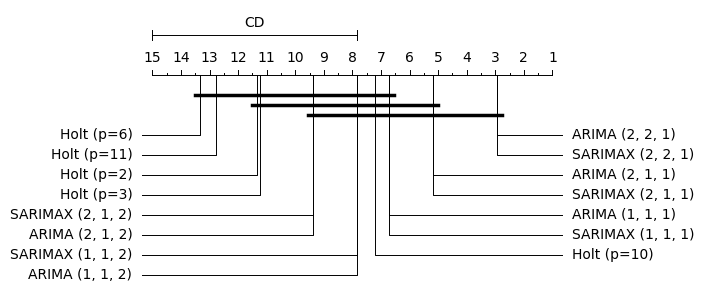

In [113]:
from autorank import autorank, plot_stats

result = autorank(df_median_price_psf_metrics, alpha=0.05, verbose=False, order='ascending')
plot_stats(result)
plt.show()

At alpha = 0.05, ARIMA/SARIMAX(2, 2, 1) have statistically significant better performance than Holt (p=2,3,6,11).

## Concluding remarks

The best models chosen from the analysis are:
- Mean `price_psf`: ARIMA/SARIMAX(1, 2, 2)
- Median `price_psf`: ARIMA/SARIMAX(2, 2, 1)

The best models are not estimated from ACF and PACF plots.

The next step is to perform modelling with machine learning methods. However, time series methods cannot be compared directly with machine learning models because the latter incorporate other features, which are useful external information.